# Generate Gene List for FunGen xQTL Analysis

## Overview
This analysis is trying to understand the functional pathway signals for the gene list we found from xQTL data. We are trying to answer the question -- we have limit genes overlapped with GVC and TWAS, does that true or we did incorrect analysis. For this, we need to answer it through: 
1. functional pathways enrichment 
    1. for GVC list -- to check the pathways for gold standard
    2. for genes in xQTL data we have -- to check the overview pathways we have;
    3. for specific genes in xQTL data only -- to check the additional pathways we have;
2. PPI analysis -- for the protein level evidence may show the indirect effect
3. Are xQTL-only genes missed by TWAS/GVC because they are tissue-specific/cell type specific? -- need to check the resource of those xQTL-only gene -- or aggregate
4. Identify if xQTL-only genes are regulators or targets in known gene regulatory circuits.
5. The prediction to disease? -- AUC

In [145]:
library(tidyverse)
library(data.table)

### load gene lists

In [217]:
gene_list <- fread("/data/resource/AD_genes_FunGen_AD_GVC_xQTL_20250325.tsv")
twas_list <- fread("/data/resource/AD_genes_FunGen_AD_twas_GVC_xQTL_20250325.tsv")

In [218]:
gene_list %>% head

gene_id         resource_in_FunGen_xQTL data_resources chr start    
1 ENSG00000002919 ColocBoost              FunGen_xQTL    17   48103356
2 ENSG00000005100 ColocBoost              FunGen_xQTL    17    5468981
3 ENSG00000006530 ColocBoost              FunGen_xQTL     7  141551277
4 ENSG00000008294 ColocBoost              FunGen_xQTL    17   51120867
5 ENSG00000013503 ColocBoost              FunGen_xQTL    12  106357747
6 ENSG00000015592                         FunGen_AD_PI    8   27258419
  end       gene_name
1  48103357 SNX11    
2   5468982 DHX33    
3 141551278 AGK      
4  51120868 SPAG9    
5 106357748 POLR3B   
6  27258420 STMN4

In [219]:
real_gvc_list <- gene_list %>% filter(str_detect(data_resources, 'ADSP_GVC')) # 20 genes from GVC table2

In [220]:
gvc_list <- gene_list %>% filter(str_detect(data_resources, 'FunGen_AD_PI|ADSP_GVC')) # 20 genes + PIs' genes

In [221]:
xQTL_list <- gene_list %>% filter(str_detect(data_resources, 'FunGen_xQTL')) # genes from xQTL evidence

In [222]:
intersect(gvc_list$gene_id, gene_list$gene_id) %>% length # the overlap between xQTL and gvc

[1] 62

In [223]:
# Intersect multiple gene_id vectors
strong_list <- Reduce(intersect, list(gvc_list$gene_id, gene_list$gene_id, twas_list$gene_id)) # the overlap between xQTL and gvc and twas

In [322]:
twas_xqtl_list <- intersect(twas_list$gene_id, gene_list$gene_id)
twas_xqtl_list %>% length

[1] 96

In [224]:
gene_ref <- fread('/data/resource/references/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list')


In [225]:
gvc_table1 <- fread('../Mar/GVC - table1.tsv')
# Set column names from the second row and remove header rows
colnames(gvc_table1) <- gvc_table1[2,] %>% as.character()
gvc_table1 <- gvc_table1[-c(1:2),]

# Map gene names to gene reference data and add resource identifier
gvc_table1 <- gene_ref %>% 
  filter(gene_name %in% gvc_table1$`Reported Gene/ Closest gene`) %>% 
  mutate(data_resource = 'FunGen_ADSP')

In [226]:
xQTL_list %>% dim
gene_list %>% dim

[1] 240   7

[1] 287   7

In [227]:
xQTL_only <- Reduce(setdiff, list(xQTL_list$gene_id, gvc_list$gene_id, twas_list$gene_id)) # the genes unqiue from xQTL, NOT from gvc and twas
xQTL_only <- xQTL_list %>% filter(gene_id %in% xQTL_only)
xQTL_only %>% dim

[1] 151   7

In [228]:
xQTL_only %>% pull(resource_in_FunGen_xQTL) %>% table # check their resources from FunGen xQTL

.
                                                  ColocBoost 
                                                         116 
                         ColocBoost,multi_context,multi_gene 
                                                           1 
                                   ColocBoost,single_context 
                                                           1 
                     ColocBoost,single_context,multi_context 
                                                           4 
           ColocBoost,single_context,multi_context,MetaBrain 
                                                           2 
ColocBoost,single_context,multi_context,MetaBrain,multi_gene 
                                                           2 
                        ColocBoost,single_context,multi_gene 
                                                           2 
                                                   MetaBrain 
                                                           1 
      

In [229]:
twas_diff_list <- Reduce(setdiff, list(twas_list$gene_id, gene_list$gene_id, gvc_list$gene_id)) # the genes unqiue from twas, NOT from gvc and xQTL
twas_diff_list %>% length

[1] 271

### load colocboost results for double check

In [ ]:
cb_apr25 <- fread('/data/analysis_result//ColocBoost//export//summary//ad_xqtl_colocboost_export_filtered.bed.gz') # load colocboost results for double check

In [ ]:
cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id) %>% pull(gene_ID) %>% unique %>% length # 128 xQTL only genes are from colocboost

In [ ]:
xQTL_only_1_se_cb <- cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id)  %>% 
              mutate(n_count = str_count(event_ID, ';') + 1, 
                     only_1_se = ifelse((str_detect(event_ID, 'sQTL') & n_count == 2), TRUE, FALSE)) %>% filter(only_1_se)
xQTL_only_1_se_cb %>% pull(gene_ID) %>% unique %>% length # should we filter the genes that only colocalized between 1 splicing event and AD? although that is not much

In [23]:
gene_ref <- fread('/data/resource/references/Homo_sapiens.GRCh38.103.chr.reformatted.collapse_only.gene.region_list')
xQTL_only_1_se_cb <- xQTL_only_1_se_cb %>% merge(., gene_ref %>% select('gene_id', 'gene_name'), by.x = 'gene_ID', by.y = 'gene_id')

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'merge': object 'xQTL_only_1_se_cb' not found


In [ ]:
cb_apr25 %>% filter(gene_ID %in% xQTL_only$gene_id)  %>% mutate(n_count = str_count(event_ID, ';') + 1)  %>% filter(n_count == 2) %>% pull(gene_ID) %>% unique %>% length

### Identify overlapping genes between metabolite-colocalized genes and AD genes to uncover potential links between AD and metabolites
and pathway enrichment results there

In [ ]:
metabolites_list <- readLines('../May/FunGen_xQTL_metabolites_coloc_genes.txt')

In [ ]:
intersect(metabolites_list, gene_list$gene_id) # only 2 genes can overlap to the gene list from AD loci

Only two genes are present, which is insufficient for meaningful enrichment analysis.

### split twas gene lists

In [24]:
twas <- fread('/data/analysis_result/twas/export/summary/FunGen_twas.exported.bed.gz')

In [25]:
twas_xQTL <- twas %>%
  filter(molecular_id %in% xQTL_list$gene_id) %>%
  group_by(molecular_id) %>%
  slice_max(twas_z, n = 1, with_ties = FALSE) %>%
  select(molecular_id, context) %>% mutate(
      context = ifelse(str_detect(context, 'sQTL|pQTL'), str_extract(context, "^[^_]+_[^_]+_[^_]+"), context)
  )

In [26]:
# Split the data frame by 'context' column into a list of data frames
twas_xQTL_list <- split(twas_xQTL, twas_xQTL$context)

## GO enrichment

### real gvc list - 20 genes from GVC table2

In [4]:
library(clusterProfiler)
library(org.Hs.eg.db)




clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: 'clusterProfiler'


The following object is masked from 'package:stats':

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, ma

In [375]:
# Run GO enrichment analysis for Biological Process (BP)
ego <- enrichGO(
  gene          = real_gvc_list$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.2
)

ID        
GO:0042987 GO:0042987
GO:0042982 GO:0042982
GO:0034205 GO:0034205
GO:0050435 GO:0050435
GO:1902992 GO:1902992
GO:1902003 GO:1902003
           Description                                                       
GO:0042987 amyloid precursor protein catabolic process                       
GO:0042982 amyloid precursor protein metabolic process                       
GO:0034205 amyloid-beta formation                                            
GO:0050435 amyloid-beta metabolic process                                    
GO:1902992 negative regulation of amyloid precursor protein catabolic process
GO:1902003 regulation of amyloid-beta formation                              
           GeneRatio BgRatio   pvalue       p.adjust     qvalue      
GO:0042987 8/20      83/21261  4.626889e-15 7.139289e-12 3.248563e-12
GO:0042982 8/20      112/21261 5.496876e-14 4.240840e-11 1.929693e-11
GO:0034205 7/20      65/21261  1.344059e-13 6.912941e-11 3.145568e-11
GO:0050435 7/20      73/21261  3.132134e-13 1.208221e-10 5.497719e-11
GO:1902992 5/20      34/21261  1.172045e-10 3.616931e-08 1.645798e-08
GO:1902003 5/20      57/21261  1.739932e-09 4.474526e-07 2.036026e-07
           geneID                                                                                                                         
GO:0042987 ENSG00000064687/ENSG00000073921/ENSG00000080815/ENSG00000130203/ENSG00000136717/ENSG00000137642/ENSG00000137845/ENSG00000143801
GO:0042982 ENSG00000064687/ENSG00000073921/ENSG00000080815/ENSG00000130203/ENSG00000136717/ENSG00000137642/ENSG00000137845/ENSG00000143801
GO:0034205 ENSG00000064687/ENSG00000073921/ENSG00000080815/ENSG00000130203/ENSG00000136717/ENSG00000137642/ENSG00000143801                
GO:0050435 ENSG00000064687/ENSG00000073921/ENSG00000080815/ENSG00000130203/ENSG00000136717/ENSG00000137642/ENSG00000143801                
GO:1902992 ENSG00000064687/ENSG00000073921/ENSG00000130203/ENSG00000136717/ENSG00000137642                                                
GO:1902003 ENSG00000064687/ENSG00000073921/ENSG00000130203/ENSG00000136717/ENSG00000137642                                                
           Count
GO:0042987 8    
GO:0042982 8    
GO:0034205 7    
GO:0050435 7    
GO:1902992 5    
GO:1902003 5

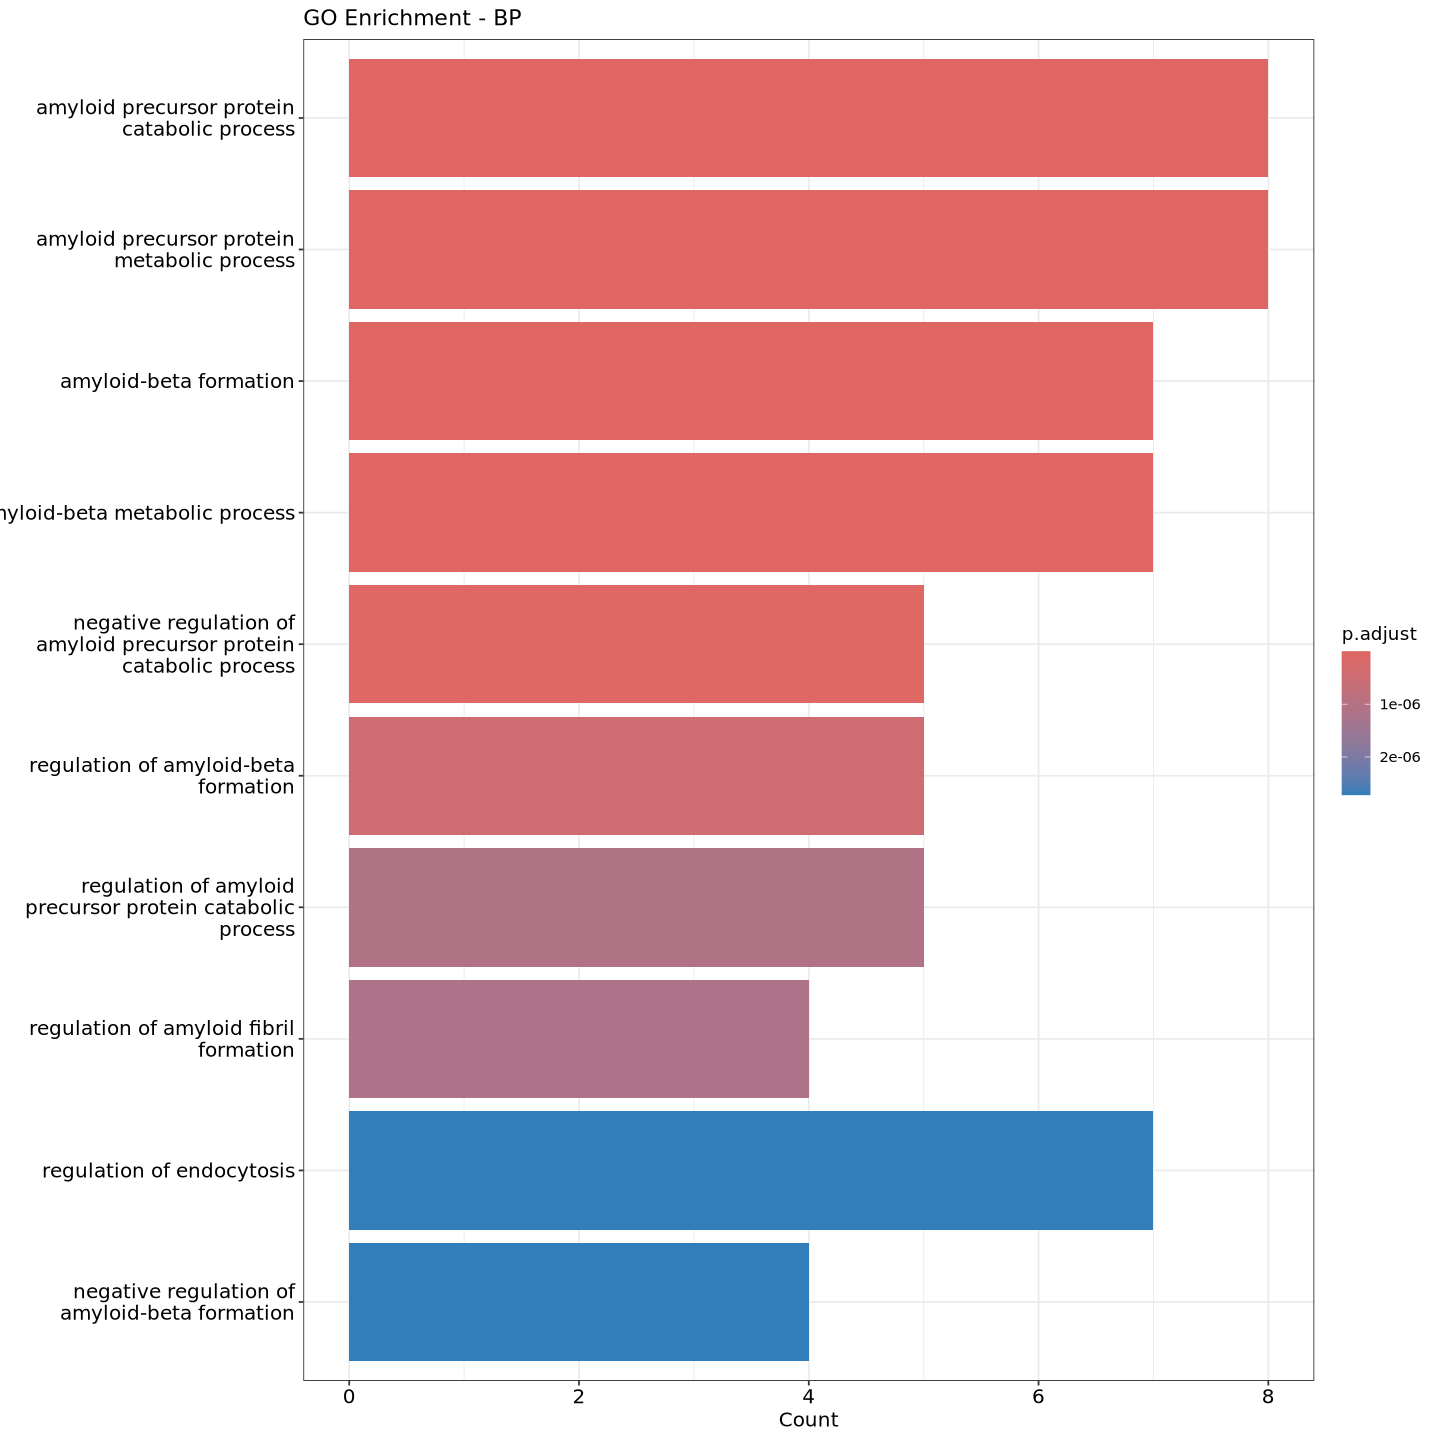

In [376]:
# View results
head(ego)

# Plot results
barplot(ego, showCategory = 10, title = "GO Enrichment - BP")

### gvc list1 -76 genes

'select()' returned 1:many mapping between keys and columns



In [377]:
# Run GO enrichment analysis for Biological Process (BP)
gvc_table1_ego <- enrichGO(
  gene          = gvc_table1$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.2
)

ID         Description                                 GeneRatio
GO:0050435 GO:0050435 amyloid-beta metabolic process              7/73     
GO:0042987 GO:0042987 amyloid precursor protein catabolic process 6/73     
GO:0002274 GO:0002274 myeloid leukocyte activation                9/73     
GO:0018108 GO:0018108 peptidyl-tyrosine phosphorylation           9/73     
GO:0018212 GO:0018212 peptidyl-tyrosine modification              9/73     
GO:0030183 GO:0030183 B cell differentiation                      7/73     
           BgRatio   pvalue       p.adjust     qvalue      
GO:0050435 73/21261  5.699259e-09 1.238449e-05 8.296922e-06
GO:0042987 83/21261  4.070155e-07 4.422223e-04 2.962644e-04
GO:0002274 292/21261 6.914695e-07 5.008544e-04 3.355447e-04
GO:0018108 316/21261 1.331243e-06 5.279251e-04 3.536805e-04
GO:0018212 318/21261 1.402387e-06 5.279251e-04 3.536805e-04
GO:0030183 163/21261 1.457685e-06 5.279251e-04 3.536805e-04
           geneID                                                                                                                                         
GO:0050435 ENSG00000136717/ENSG00000196549/ENSG00000120885/ENSG00000137642/ENSG00000138613/ENSG00000159640/ENSG00000064687                                
GO:0042987 ENSG00000151694/ENSG00000136717/ENSG00000120885/ENSG00000137642/ENSG00000138613/ENSG00000064687                                                
GO:0002274 ENSG00000109684/ENSG00000168421/ENSG00000095970/ENSG00000120885/ENSG00000066336/ENSG00000197943/ENSG00000103241/ENSG00000030582/ENSG00000142192
GO:0018108 ENSG00000151694/ENSG00000095970/ENSG00000146904/ENSG00000120899/ENSG00000157368/ENSG00000197943/ENSG00000159640/ENSG00000087589/ENSG00000142192
GO:0018212 ENSG00000151694/ENSG00000095970/ENSG00000146904/ENSG00000120899/ENSG00000157368/ENSG00000197943/ENSG00000159640/ENSG00000087589/ENSG00000142192
GO:0030183 ENSG00000203710/ENSG00000151694/ENSG00000168918/ENSG00000120899/ENSG00000066336/ENSG00000095585/ENSG00000197943                                
           Count
GO:0050435 7    
GO:0042987 6    
GO:0002274 9    
GO:0018108 9    
GO:0018212 9    
GO:0030183 7

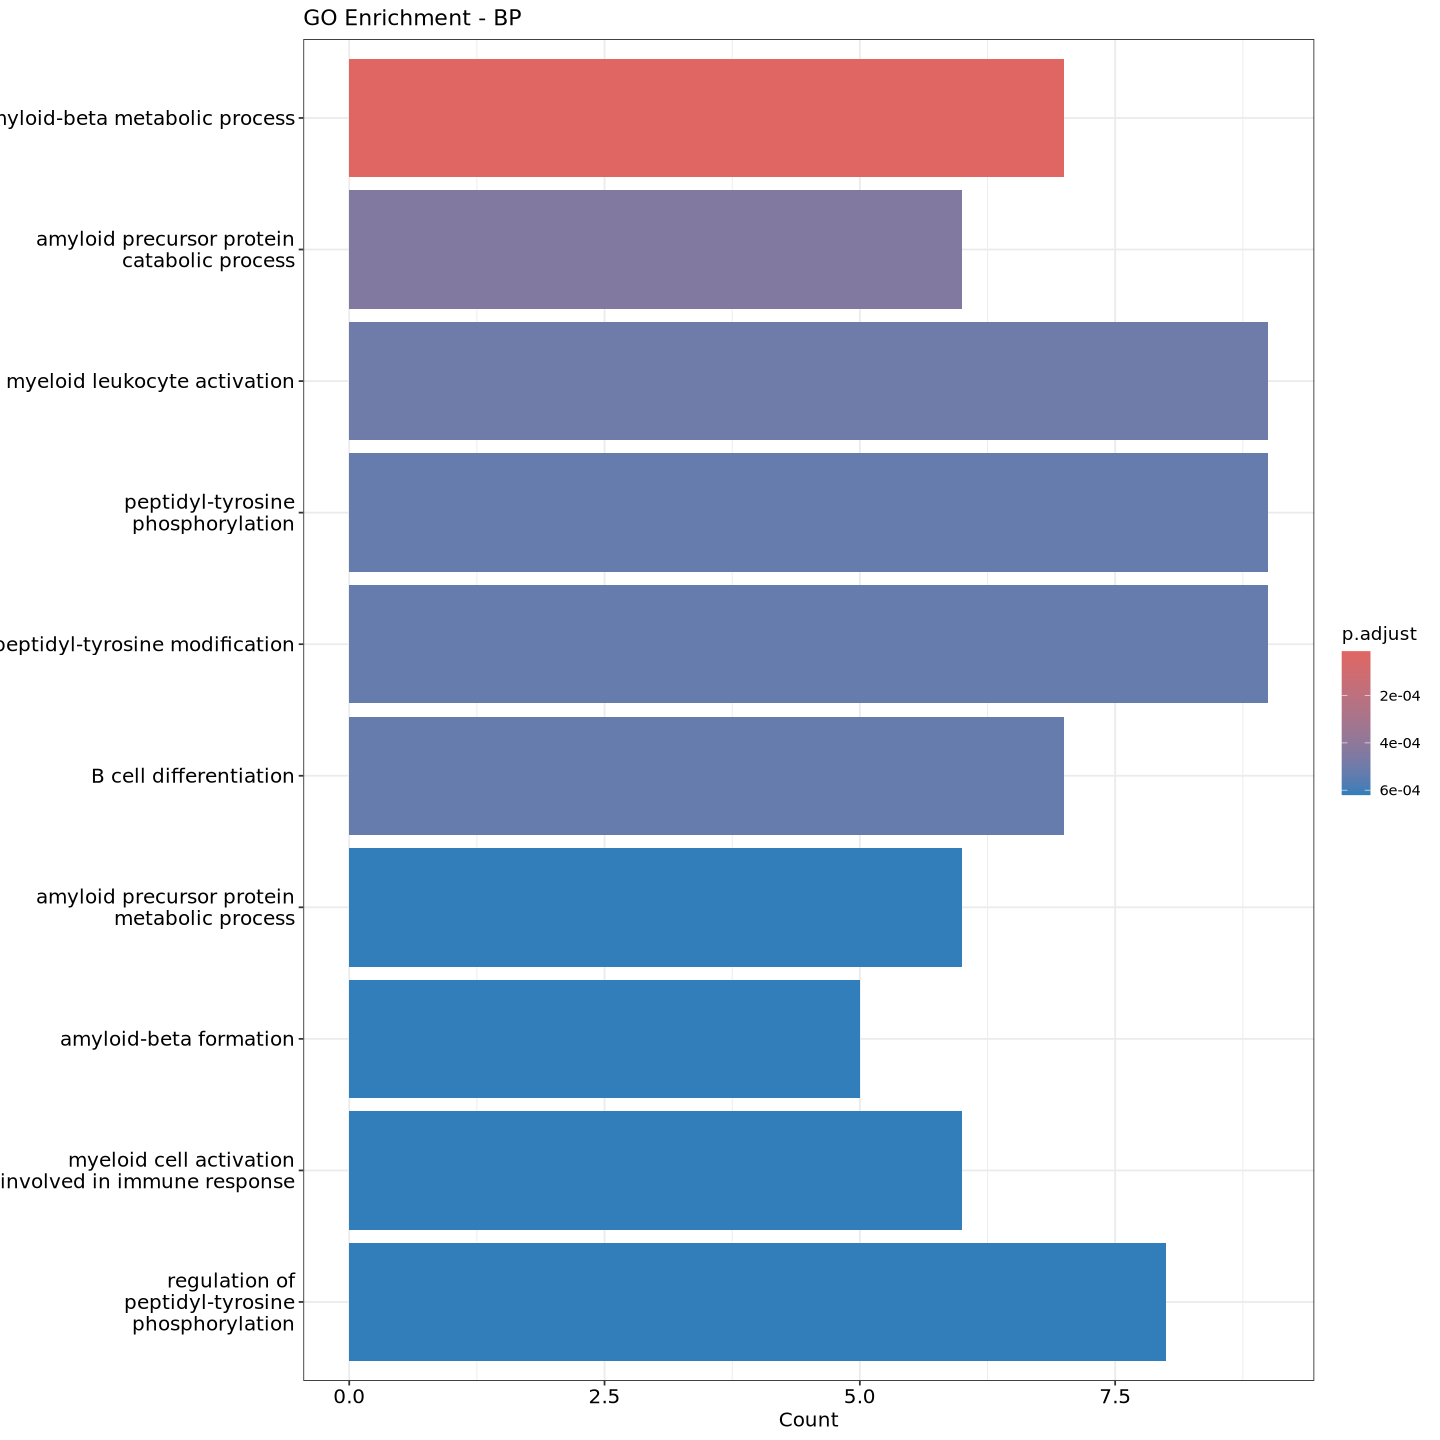

In [378]:
# View results
head(gvc_table1_ego)

# Plot results
barplot(gvc_table1_ego, showCategory = 10, title = "GO Enrichment - BP")

### strong list - overlapped between xQTL, GVC and TWAS

In [48]:

ego <- enrichGO(
  gene          = strong_list,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 0.05,
  qvalueCutoff  = 0.2
)


'select()' returned 1:1 mapping between keys and columns



In [49]:
head(ego)

ID        
GO:0042987 GO:0042987
GO:1902992 GO:1902992
GO:0042982 GO:0042982
GO:1905245 GO:1905245
GO:1902003 GO:1902003
GO:1902991 GO:1902991
           Description                                                       
GO:0042987 amyloid precursor protein catabolic process                       
GO:1902992 negative regulation of amyloid precursor protein catabolic process
GO:0042982 amyloid precursor protein metabolic process                       
GO:1905245 regulation of aspartic-type peptidase activity                    
GO:1902003 regulation of amyloid-beta formation                              
GO:1902991 regulation of amyloid precursor protein catabolic process         
           GeneRatio BgRatio  pvalue       p.adjust     qvalue      
GO:0042987 5/21      68/18870 1.018064e-08 1.487391e-05 7.330060e-06
GO:1902992 4/21      32/18870 3.993694e-08 2.850115e-05 1.404574e-05
GO:0042982 5/21      96/18870 5.852392e-08 2.850115e-05 1.404574e-05
GO:1905245 3/21      10/18870 1.418278e-07 5.180262e-05 2.552901e-05
GO:1902003 4/21      48/18870 2.136190e-07 6.241947e-05 3.076113e-05
GO:1902991 4/21      55/18870 3.725395e-07 8.367501e-05 4.123615e-05
           geneID                Count
GO:0042987 8301/348/274/6653/102 5    
GO:1902992 8301/348/274/6653     4    
GO:0042982 8301/348/274/6653/102 5    
GO:1905245 8301/274/6653         3    
GO:1902003 8301/348/274/6653     4    
GO:1902991 8301/348/274/6653     4

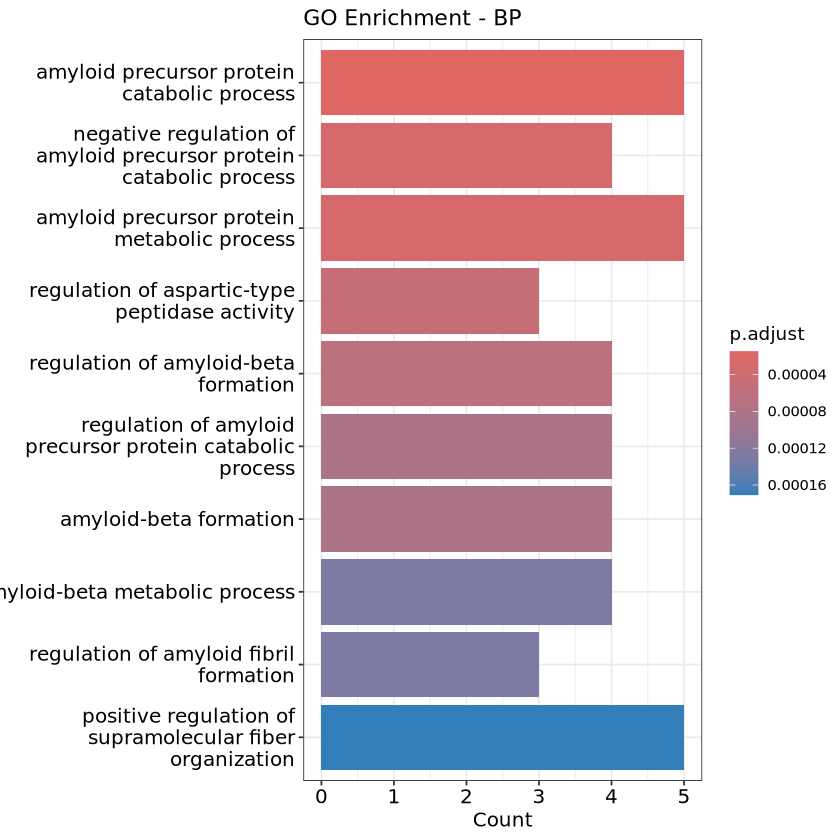

In [50]:
barplot(ego, showCategory = 10, title = "GO Enrichment - BP")

### xQTL list

#### GO

In [267]:
xQTL_ego <- enrichGO(
  gene          = xQTL_list$gene_name,
  OrgDb         = org.Hs.eg.db,
  keyType       = "SYMBOL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [268]:
head(xQTL_ego, n=5)

ID         Description                                      
GO:0002274 GO:0002274 myeloid leukocyte activation                     
GO:0030100 GO:0030100 regulation of endocytosis                        
GO:0002281 GO:0002281 macrophage activation involved in immune response
GO:0045806 GO:0045806 negative regulation of endocytosis               
GO:0045785 GO:0045785 positive regulation of cell adhesion             
           GeneRatio BgRatio   pvalue       p.adjust    qvalue     
GO:0002274 14/215    241/18870 7.287466e-07 0.001336395 0.001100642
GO:0030100 15/215    291/18870 1.315310e-06 0.001336395 0.001100642
GO:0002281 5/215     19/18870  1.871302e-06 0.001336395 0.001100642
GO:0045806 8/215     75/18870  2.184779e-06 0.001336395 0.001100642
GO:0045785 19/215    482/18870 2.856012e-06 0.001336395 0.001100642
           geneID                                                                                                             
GO:0002274 GRN/TREM2/STX4/CD33/HAVCR1/CLU/NECTIN2/HAVCR2/DYSF/APP/FCER1G/RHOH/C5AR1/PLCG2                                     
GO:0030100 ATG5/PICALM/TREM2/RIN3/SIRPB1/LILRB1/CLU/APOC1/DYSF/BIN1/DGKQ/FCER1G/PLCG2/SIRPA/APOC2                             
GO:0002281 GRN/TREM2/HAVCR2/DYSF/PLCG2                                                                                        
GO:0045806 ATG5/PICALM/RIN3/LILRB1/APOC1/DYSF/SIRPA/APOC2                                                                     
GO:0045785 CBFB/NCK2/ACTL6B/CASS4/STK4/SIRPB1/CORO1A/STX4/LILRB1/ITGB1BP1/PTK2B/HAVCR2/EPHA1/STX3/SERPINF2/RHOH/CD55/SIRPA/CR1
           Count
GO:0002274 14   
GO:0030100 15   
GO:0002281  5   
GO:0045806  8   
GO:0045785 19

In [269]:
xQTL_ego %>% as.data.frame %>% filter(str_detect(Description, 'amyloid')) %>% head

ID        
GO:0050435 GO:0050435
GO:0042987 GO:0042987
GO:0034205 GO:0034205
GO:1902992 GO:1902992
GO:0042982 GO:0042982
GO:1905906 GO:1905906
           Description                                                       
GO:0050435 amyloid-beta metabolic process                                    
GO:0042987 amyloid precursor protein catabolic process                       
GO:0034205 amyloid-beta formation                                            
GO:1902992 negative regulation of amyloid precursor protein catabolic process
GO:0042982 amyloid precursor protein metabolic process                       
GO:1905906 regulation of amyloid fibril formation                            
           GeneRatio BgRatio  pvalue       p.adjust    qvalue     
GO:0050435 6/215     65/18870 9.625198e-05 0.008784523 0.007234844
GO:0042987 6/215     68/18870 1.239814e-04 0.009283489 0.007645788
GO:0034205 5/215     56/18870 4.365566e-04 0.014128981 0.011636486
GO:1902992 4/215     32/18870 4.588274e-04 0.014228284 0.011718271
GO:0042982 6/215     96/18870 8.066540e-04 0.019811423 0.016316488
GO:1905906 3/215     17/18870 8.814851e-04 0.020977978 0.017277251
           geneID                             Count
GO:0050435 PICALM/CLU/BIN1/SORL1/APH1B/ACE    6    
GO:0042987 PICALM/CLU/BIN1/SORL1/APH1B/ADAM17 6    
GO:0034205 PICALM/CLU/BIN1/SORL1/APH1B        5    
GO:1902992 PICALM/CLU/BIN1/SORL1              4    
GO:0042982 PICALM/CLU/BIN1/SORL1/APH1B/ADAM17 6    
GO:1905906 TREM2/CLU/APP                      3

In [274]:
xQTL_ego %>%
  as.data.frame() %>%
  filter(str_detect(Description, regex('lysosome|lysosomal membrane|lysosomal lumen|autophagy|macroautophagy|vacuole|endosome|phagosome|lipid droplet', ignore_case = TRUE))) %>%
  head() # GO terms related to lysosome

ID         Description                         GeneRatio BgRatio  
GO:0007040 GO:0007040 lysosome organization               6/215     109/18870
GO:0080171 GO:0080171 lytic vacuole organization          6/215     109/18870
GO:0035751 GO:0035751 regulation of lysosomal lumen pH    3/215     30/18870 
GO:0007033 GO:0007033 vacuole organization                8/215     232/18870
GO:1905671 GO:1905671 regulation of lysosome organization 2/215     12/18870 
GO:0061684 GO:0061684 chaperone-mediated autophagy        2/215     15/18870 
           pvalue      p.adjust   qvalue    
GO:0007040 0.001559714 0.02816660 0.02319773
GO:0080171 0.001559714 0.02816660 0.02319773
GO:0035751 0.004720251 0.05682812 0.04680307
GO:0007033 0.005230031 0.06151798 0.05066559
GO:1905671 0.007910467 0.07489316 0.06168125
GO:0061684 0.012305649 0.09661980 0.07957509
           geneID                                               Count
GO:0007040 GRN/CORO1A/TMEM106B/TMEM175/ACP2/ABCA1               6    
GO:0080171 GRN/CORO1A/TMEM106B/TMEM175/ACP2/ABCA1               6    
GO:0035751 GRN/TMEM106B/TMEM175                                 3    
GO:0007033 GRN/ATG5/CORO1A/TMEM106B/TMEM175/ACP2/TP53INP1/ABCA1 8    
GO:1905671 GRN/TMEM106B                                         2    
GO:0061684 ATG5/CLU                                             2

In [272]:
xQTL_ego %>%
  as.data.frame() %>%
  filter(str_detect(Description, regex('synaptic transmission|synapse organization|cognition|synaptic plasticity|neuron projection morphogenesis|axon guidance|nervous system development|modulation of chemical synaptic transmission|generation of neurons|learning or memory|neuron projection|postsynaptic membrane|dendrite|axon|cell body|postsynapse|presynapse|synaptic membrane|synapse', ignore_case = TRUE))) %>% head  
# GO terms related to neuron function

ID        
GO:0098814 GO:0098814
GO:0099003 GO:0099003
GO:0099643 GO:0099643
GO:0002753 GO:0002753
GO:0001771 GO:0001771
GO:0098969 GO:0098969
           Description                                                 
GO:0098814 spontaneous synaptic transmission                           
GO:0099003 vesicle-mediated transport in synapse                       
GO:0099643 signal release from synapse                                 
GO:0002753 cytosolic pattern recognition receptor signaling pathway    
GO:0001771 immunological synapse formation                             
GO:0098969 neurotransmitter receptor transport to postsynaptic membrane
           GeneRatio BgRatio   pvalue       p.adjust   qvalue    
GO:0098814 3/215     14/18870  0.0004839086 0.01428461 0.01176466
GO:0099003 9/215     220/18870 0.0009731495 0.02231430 0.01837783
GO:0099643 6/215     144/18870 0.0061904976 0.06811766 0.05610102
GO:0002753 6/215     146/18870 0.0066103893 0.06955848 0.05728766
GO:0001771 2/215     15/18870  0.0123056490 0.09661980 0.07957509
GO:0098969 2/215     16/18870  0.0139590195 0.10276784 0.08463856
           geneID                                             Count
GO:0098814 APP/DOC2A/DOC2B                                    3    
GO:0099003 SLC4A8/PICALM/BIN1/DGKQ/DOC2A/STX3/CPLX1/GAK/DOC2B 9    
GO:0099643 SLC4A8/DYSF/DOC2A/STX3/CPLX1/DOC2B                 6    
GO:0002753 DHX33/TREM2/HAVCR2/OTULIN/SCIMP/PLCG2              6    
GO:0001771 NCK2/HAVCR2                                        2    
GO:0098969 STX3/CPLX1                                         2

In [275]:
xQTL_ego %>% as.data.frame %>% filter(str_detect(Description, 'lipid|Lipid|fatty|Fatty')) %>% head


ID         Description                               GeneRatio
GO:0033700 GO:0033700 phospholipid efflux                       3/215    
GO:0071825 GO:0071825 protein-lipid complex organization        4/215    
GO:0055088 GO:0055088 lipid homeostasis                         7/215    
GO:0065005 GO:0065005 protein-lipid complex assembly            3/215    
GO:0046834 GO:0046834 lipid phosphorylation                     2/215    
GO:1905953 GO:1905953 negative regulation of lipid localization 4/215    
           BgRatio   pvalue       p.adjust   qvalue    
GO:0033700 14/18870  0.0004839086 0.01428461 0.01176466
GO:0071825 53/18870  0.0031013959 0.04442263 0.03658603
GO:0055088 175/18870 0.0039847419 0.05183541 0.04269112
GO:0065005 30/18870  0.0047202510 0.05682812 0.04680307
GO:0046834 11/18870  0.0066416292 0.06955848 0.05728766
GO:1905953 66/18870  0.0068071776 0.06966012 0.05737137
           geneID                                     Count
GO:0033700 APOC1/ABCA1/APOC2                          3    
GO:0071825 APOC1/BIN1/ABCA1/APOC2                     4    
GO:0055088 POLD1/TREM2/MTCH2/THADA/TLCD3B/ABCA1/APOC2 7    
GO:0065005 APOC1/BIN1/ABCA1                           3    
GO:0046834 AGK/DGKQ                                   2    
GO:1905953 TREM2/APOC1/ABCA1/APOC2                    4

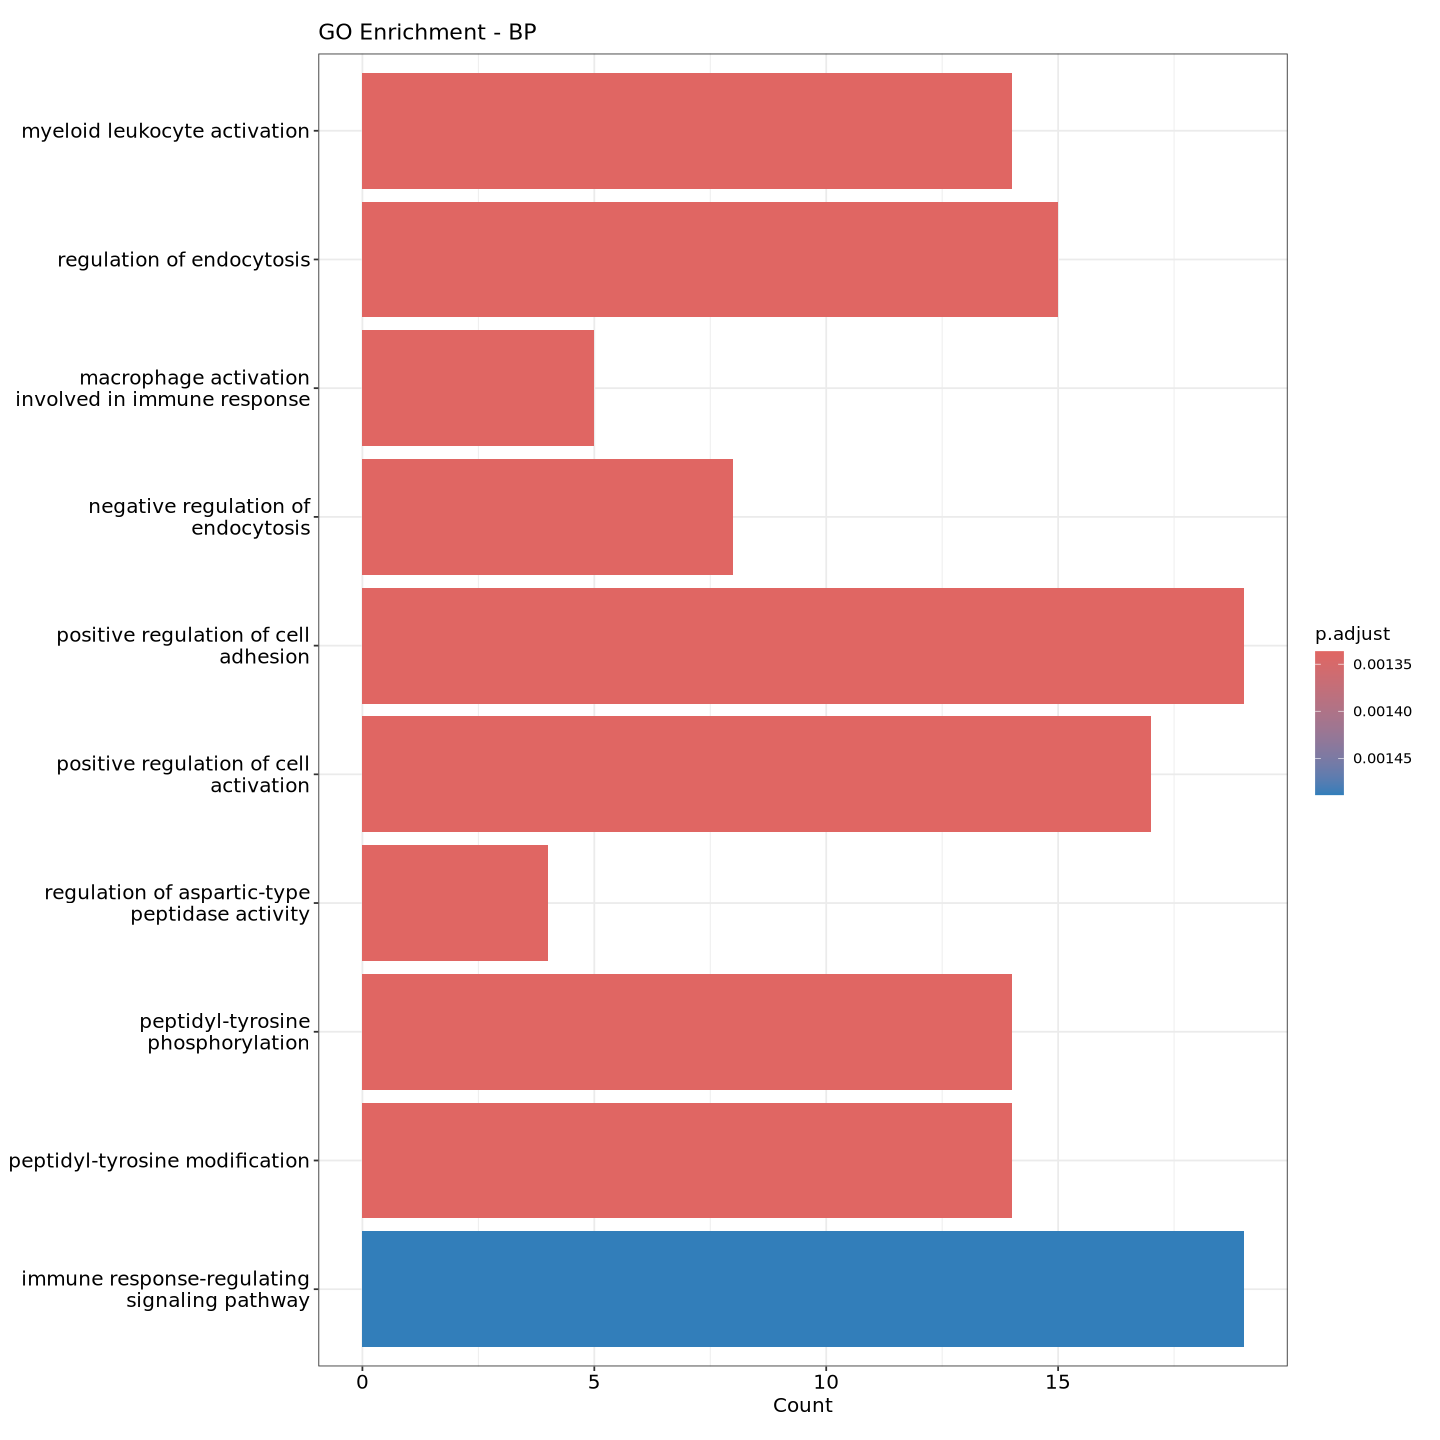

In [277]:
barplot(xQTL_ego,
        showCategory = 10,
        title = "GO Enrichment - BP") +
  theme(plot.margin = margin(t = 5, r = 5, b = 5, l = 10, unit = "mm"))

In [201]:
ggsave('./figs/xQTL_list_GO.pdf', width = 6, height = 6)

#### KEGG

In [278]:
entrez_ids <- bitr(xQTL_list$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene = entrez_ids$ENTREZID,
                          organism = 'hsa',
                          pvalueCutoff = 1,
                          qvalueCutoff = 1) 

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(xQTL_list$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
"2.08% of input gene IDs are fail to map..."


In [279]:
kegg_enrich %>% head(n=4)

category           subcategory                  ID      
hsa04610 Organismal Systems Immune system                hsa04610
hsa04662 Organismal Systems Immune system                hsa04662
hsa04380 Organismal Systems Development and regeneration hsa04380
hsa04148 NA                 NA                           hsa04148
         Description                         GeneRatio BgRatio  pvalue      
hsa04610 Complement and coagulation cascades 7/106     88/8866  8.205886e-05
hsa04662 B cell receptor signaling pathway   7/106     91/8866  1.016015e-04
hsa04380 Osteoclast differentiation          8/106     143/8866 2.999088e-04
hsa04148 Efferocytosis                       8/106     157/8866 5.618405e-04
         p.adjust   qvalue     geneID                                         
hsa04610 0.01127777 0.01069490 1380/1191/5345/716/1604/728/1378               
hsa04662 0.01127777 0.01069490 29760/5595/10859/1380/3635/353514/5336         
hsa04380 0.02219325 0.02104623 29760/54209/10326/5595/10859/353514/5336/140885
hsa04148 0.03118215 0.02957055 10326/5595/26762/84868/91937/6868/19/140885    
         Count
hsa04610 7    
hsa04662 7    
hsa04380 8    
hsa04148 8

In [281]:
kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'lipid|Lipid|fatty|Fatty|Alzheimer|Cholesterol'))
kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'Alzheimer'))

category                            
hsa04979 Organismal Systems                  
hsa00604 Metabolism                          
hsa00603 Metabolism                          
hsa00561 Metabolism                          
hsa05010 Human Diseases                      
hsa04071 Environmental Information Processing
hsa04932 Human Diseases                      
hsa00564 Metabolism                          
hsa05417 Human Diseases                      
         subcategory                        ID      
hsa04979 Digestive system                   hsa04979
hsa00604 Glycan biosynthesis and metabolism hsa00604
hsa00603 Glycan biosynthesis and metabolism hsa00603
hsa00561 Lipid metabolism                   hsa00561
hsa05010 Neurodegenerative disease          hsa05010
hsa04071 Signal transduction                hsa04071
hsa04932 Endocrine and metabolic disease    hsa04932
hsa00564 Lipid metabolism                   hsa00564
hsa05417 Cardiovascular disease             hsa05417
         Description                                                GeneRatio
hsa04979 Cholesterol metabolism                                     3/106    
hsa00604 Glycosphingolipid biosynthesis - ganglio series            1/106    
hsa00603 Glycosphingolipid biosynthesis - globo and isoglobo series 1/106    
hsa00561 Glycerolipid metabolism                                    2/106    
hsa05010 Alzheimer disease                                          7/106    
hsa04071 Sphingolipid signaling pathway                             2/106    
hsa04932 Non-alcoholic fatty liver disease                          2/106    
hsa00564 Glycerophospholipid metabolism                             1/106    
hsa05417 Lipid and atherosclerosis                                  2/106    
         BgRatio  pvalue     p.adjust  qvalue   
hsa04979 51/8866  0.02284626 0.3088180 0.2928573
hsa00604 15/8866  0.16519819 0.7616641 0.7222988
hsa00603 16/8866  0.17519581 0.7616641 0.7222988
hsa00561 65/8866  0.18221177 0.7616641 0.7222988
hsa05010 391/8866 0.18673497 0.7616641 0.7222988
hsa04071 122/8866 0.43021701 0.7977285 0.7564993
hsa04932 157/8866 0.56344595 0.8140899 0.7720151
hsa00564 103/8866 0.71237338 0.8364174 0.7931886
hsa05417 216/8866 0.73485076 0.8364174 0.7931886
         geneID                              Count
hsa04979 341/19/344                          3    
hsa00604 6483                                1    
hsa00603 6483                                1    
hsa00561 55750/1609                          2    
hsa05010 5595/1350/83464/351/6868/91252/4722 7    
hsa04071 5595/2207                           2    
hsa04932 1350/4722                           2    
hsa00564 1609                                1    
hsa05417 5595/19                             2

category       subcategory               ID       Description      
hsa05010 Human Diseases Neurodegenerative disease hsa05010 Alzheimer disease
         GeneRatio BgRatio  pvalue   p.adjust  qvalue   
hsa05010 7/106     391/8866 0.186735 0.7616641 0.7222988
         geneID                              Count
hsa05010 5595/1350/83464/351/6868/91252/4722 7

In [321]:
entrez_ids %>% filter(ENTREZID == '1609') %>% merge(.,gene_ref, by.x = 'ENSEMBL', by.y = 'gene_id')
entrez_ids %>% filter(ENTREZID == '6483') %>% merge(.,gene_ref, by.x = 'ENSEMBL', by.y = 'gene_id')

ENSEMBL         ENTREZID #chr start  end    gene_name
1 ENSG00000145214 1609     chr4 986894 986895 DGKQ

ENSEMBL         ENTREZID #chr  start    end      gene_name
1 ENSG00000157350 6483     chr16 70439236 70439237 ST3GAL2

In [333]:
entrez_ids %>% filter(ENTREZID%in% (kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'Alzheimer')) %>% pull(geneID) %>% str_split(., '/') %>% unlist)) %>% merge(.,gene_ref, by.x = 'ENSEMBL', by.y = 'gene_id')

ENSEMBL         ENTREZID #chr  start    end      gene_name
1 ENSG00000102882 5595     chr16 30123505 30123506 MAPK3    
2 ENSG00000127184 1350     chr5  86617927 86617928 COX7C    
3 ENSG00000138613 83464    chr15 63276017 63276018 APH1B    
4 ENSG00000142192 351      chr21 26171127 26171128 APP      
5 ENSG00000151694 6868     chr2   9556731  9556732 ADAM17   
6 ENSG00000165915 91252    chr11 47407131 47407132 SLC39A13 
7 ENSG00000213619 4722     chr11 47565335 47565336 NDUFS3

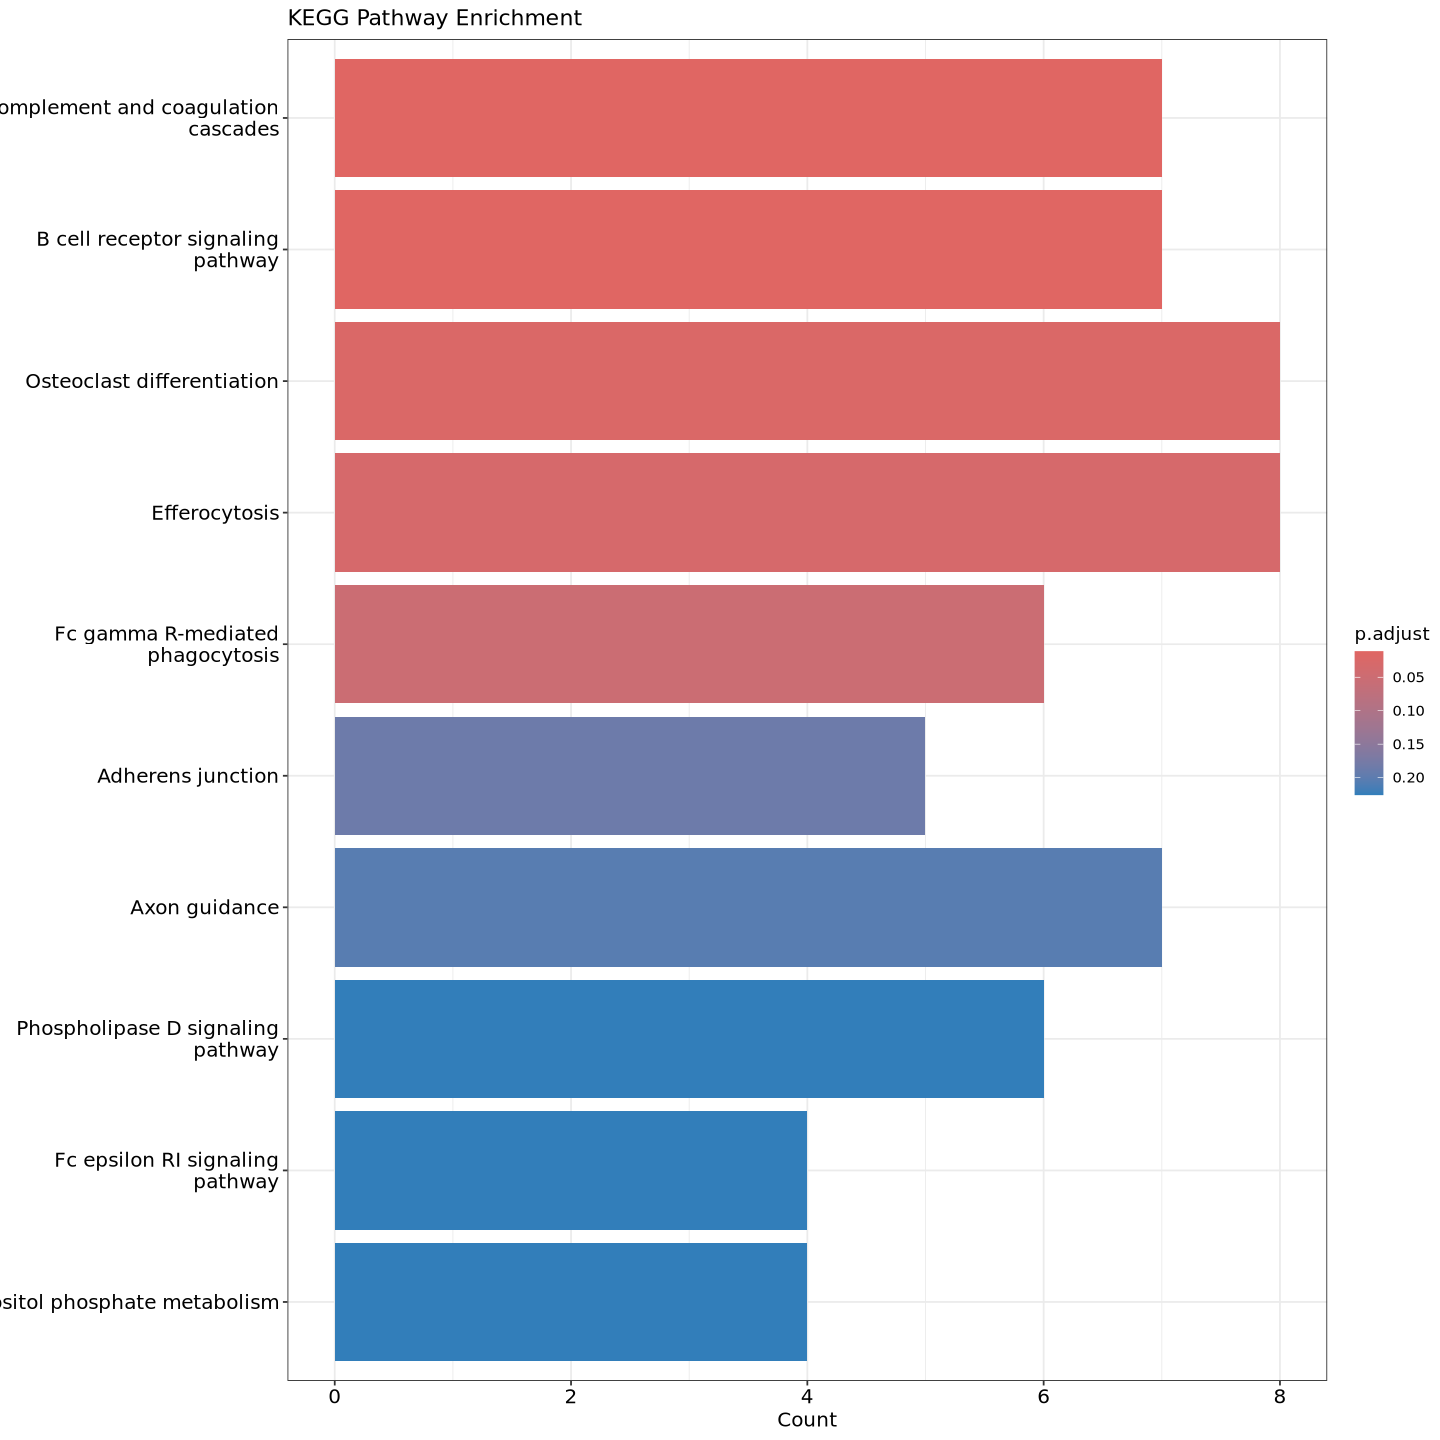

In [297]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")

In [298]:
ggsave('./figs/xQTL_list_KEGG.pdf', width = 6, height = 6)

In [284]:
kegg_enrich %>%
  as.data.frame() %>%
  filter(str_detect(Description, regex('lysosome|autophagy|endocytosis|phagosome|vacuole|lipid', ignore_case = TRUE))) %>%
  head()
# KEGG pathways related to lysosome functions

category           subcategory                        ID      
hsa04142 Cellular Processes Transport and catabolism           hsa04142
hsa00604 Metabolism         Glycan biosynthesis and metabolism hsa00604
hsa00603 Metabolism         Glycan biosynthesis and metabolism hsa00603
hsa00561 Metabolism         Lipid metabolism                   hsa00561
hsa04136 Cellular Processes Transport and catabolism           hsa04136
hsa04140 Cellular Processes Transport and catabolism           hsa04140
         Description                                                GeneRatio
hsa04142 Lysosome                                                   5/106    
hsa00604 Glycosphingolipid biosynthesis - ganglio series            1/106    
hsa00603 Glycosphingolipid biosynthesis - globo and isoglobo series 1/106    
hsa00561 Glycerolipid metabolism                                    2/106    
hsa04136 Autophagy - other                                          1/106    
hsa04140 Autophagy - animal                                         3/106    
         BgRatio  pvalue     p.adjust  qvalue    geneID                  Count
hsa04142 133/8866 0.02139461 0.3088180 0.2928573 23062/1512/3425/53/1508 5    
hsa00604 15/8866  0.16519819 0.7616641 0.7222988 6483                    1    
hsa00603 16/8866  0.17519581 0.7616641 0.7222988 6483                    1    
hsa00561 65/8866  0.18221177 0.7616641 0.7222988 55750/1609              2    
hsa04136 32/8866  0.31993655 0.7977285 0.7564993 9474                    1    
hsa04140 169/8866 0.32892441 0.7977285 0.7564993 9474/5595/1508          3

In [285]:
kegg_enrich %>%
  as.data.frame() %>%
  filter(str_detect(Description, regex('synapse|neuro|axon|dendrite|memory|learning|brain|glutamatergic|GABAergic|cholinergic|dopaminergic|serotonergic', ignore_case = TRUE))) %>%
  head()

# KEGG pathways related to neuron function

category           subcategory                  ID      
hsa04360 Organismal Systems Development and regeneration hsa04360
hsa04722 Organismal Systems Nervous system               hsa04722
hsa04726 Organismal Systems Nervous system               hsa04726
hsa04727 Organismal Systems Nervous system               hsa04727
hsa05022 Human Diseases     Neurodegenerative disease    hsa05022
hsa04724 Organismal Systems Nervous system               hsa04724
         Description                                       GeneRatio BgRatio 
hsa04360 Axon guidance                                     7/106     184/8866
hsa04722 Neurotrophin signaling pathway                    3/106     120/8866
hsa04726 Serotonergic synapse                              2/106     115/8866
hsa04727 GABAergic synapse                                 1/106     89/8866 
hsa05022 Pathways of neurodegeneration - multiple diseases 5/106     483/8866
hsa04724 Glutamatergic synapse                             1/106     116/8866
         pvalue      p.adjust  qvalue    geneID                             
hsa04360 0.006415158 0.2034522 0.1929371 8440/5595/5921/2041/3985/23365/5336
hsa04722 0.173133337 0.7616641 0.7222988 4214/5595/5336                     
hsa04726 0.401087493 0.7977285 0.7564993 5595/351                           
hsa04727 0.658994838 0.8359820 0.7927757 4905                               
hsa05022 0.692328902 0.8364174 0.7931886 5595/83544/1350/351/4722           
hsa04724 0.754488647 0.8374824 0.7941986 5595                               
         Count
hsa04360 7    
hsa04722 3    
hsa04726 2    
hsa04727 1    
hsa05022 5    
hsa04724 1

##### plot AD path

In [286]:
gene.data <- kegg_enrich %>%
  as.data.frame() %>%
  filter(str_detect(Description, 'Alzheimer')) %>%
  pull(geneID) %>%
  str_split('/') %>%
  unlist()

gene.data <- setNames(as.numeric(rep(1, length(gene.data))), gene.data)

In [291]:
library(pathview)


# Generate the pathway plot with highlighted genes
pathview(
  gene.data = gene.data,
  pathway.id = "hsa05010",
  species = "hsa",
  out.suffix = "xQTL_list",
  kegg.native = TRUE
)

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /home/user/project/FunGen_xQTL/2025/May

Info: Writing image file hsa05010.xQTL_list.png



### xQTL only list

#### GO

In [339]:
xqtl_only_ego <- enrichGO(
  gene          = xQTL_only$gene_id,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)

In [340]:
xqtl_only_ego %>% head

ID         Description                   GeneRatio BgRatio  
GO:0016482 GO:0016482 cytosolic transport           7/134     205/21261
GO:0031338 GO:0031338 regulation of vesicle fusion  3/134     26/21261 
GO:0048284 GO:0048284 organelle fusion              6/134     170/21261
GO:1902017 GO:1902017 regulation of cilium assembly 4/134     75/21261 
GO:0006906 GO:0006906 vesicle fusion                5/134     129/21261
GO:0090174 GO:0090174 organelle membrane fusion     5/134     131/21261
           pvalue       p.adjust  qvalue   
GO:0016482 0.0003266830 0.3308869 0.3181081
GO:0031338 0.0005723755 0.3308869 0.3181081
GO:0048284 0.0007385666 0.3308869 0.3181081
GO:1902017 0.0012972001 0.3308869 0.3181081
GO:0006906 0.0013601269 0.3308869 0.3181081
GO:0090174 0.0014560405 0.3308869 0.3181081
           geneID                                                                                                         
GO:0016482 ENSG00000008294/ENSG00000099992/ENSG00000102879/ENSG00000141258/ENSG00000167716/ENSG00000178950/ENSG00000188529
GO:0031338 ENSG00000102879/ENSG00000168993/ENSG00000272636                                                                
GO:0048284 ENSG00000102879/ENSG00000103496/ENSG00000127419/ENSG00000140379/ENSG00000168993/ENSG00000272636                
GO:1902017 ENSG00000057663/ENSG00000103540/ENSG00000138036/ENSG00000182541                                                
GO:0006906 ENSG00000102879/ENSG00000103496/ENSG00000127419/ENSG00000168993/ENSG00000272636                                
GO:0090174 ENSG00000102879/ENSG00000103496/ENSG00000127419/ENSG00000168993/ENSG00000272636                                
           Count
GO:0016482 7    
GO:0031338 3    
GO:0048284 6    
GO:1902017 4    
GO:0006906 5    
GO:0090174 5

In [341]:
xqtl_only_ego %>% as.data.frame %>% filter(str_detect(Description, 'amyloid'))

ID         Description                                 GeneRatio
GO:0097242 GO:0097242 amyloid-beta clearance                      1/134    
GO:0042987 GO:0042987 amyloid precursor protein catabolic process 1/134    
GO:0042982 GO:0042982 amyloid precursor protein metabolic process 1/134    
           BgRatio   pvalue    p.adjust  qvalue    geneID          Count
GO:0097242 46/21261  0.2525944 0.5085526 0.4889124 ENSG00000197405 1    
GO:0042987 83/21261  0.4089122 0.5944998 0.5715403 ENSG00000151694 1    
GO:0042982 112/21261 0.5083500 0.6579564 0.6325463 ENSG00000151694 1

In [356]:
amyloid_genes <- (xqtl_only_ego %>% as.data.frame %>% filter(str_detect(Description, 'amyloid')) %>% pull(geneID) %>% str_split(., '/') %>% unlist )
gene_ref %>% filter(gene_id %in% amyloid_genes)

#chr  start    end      gene_id         gene_name
1 chr2   9556731  9556732 ENSG00000151694 ADAM17   
2 chr19 47290022 47290023 ENSG00000197405 C5AR1

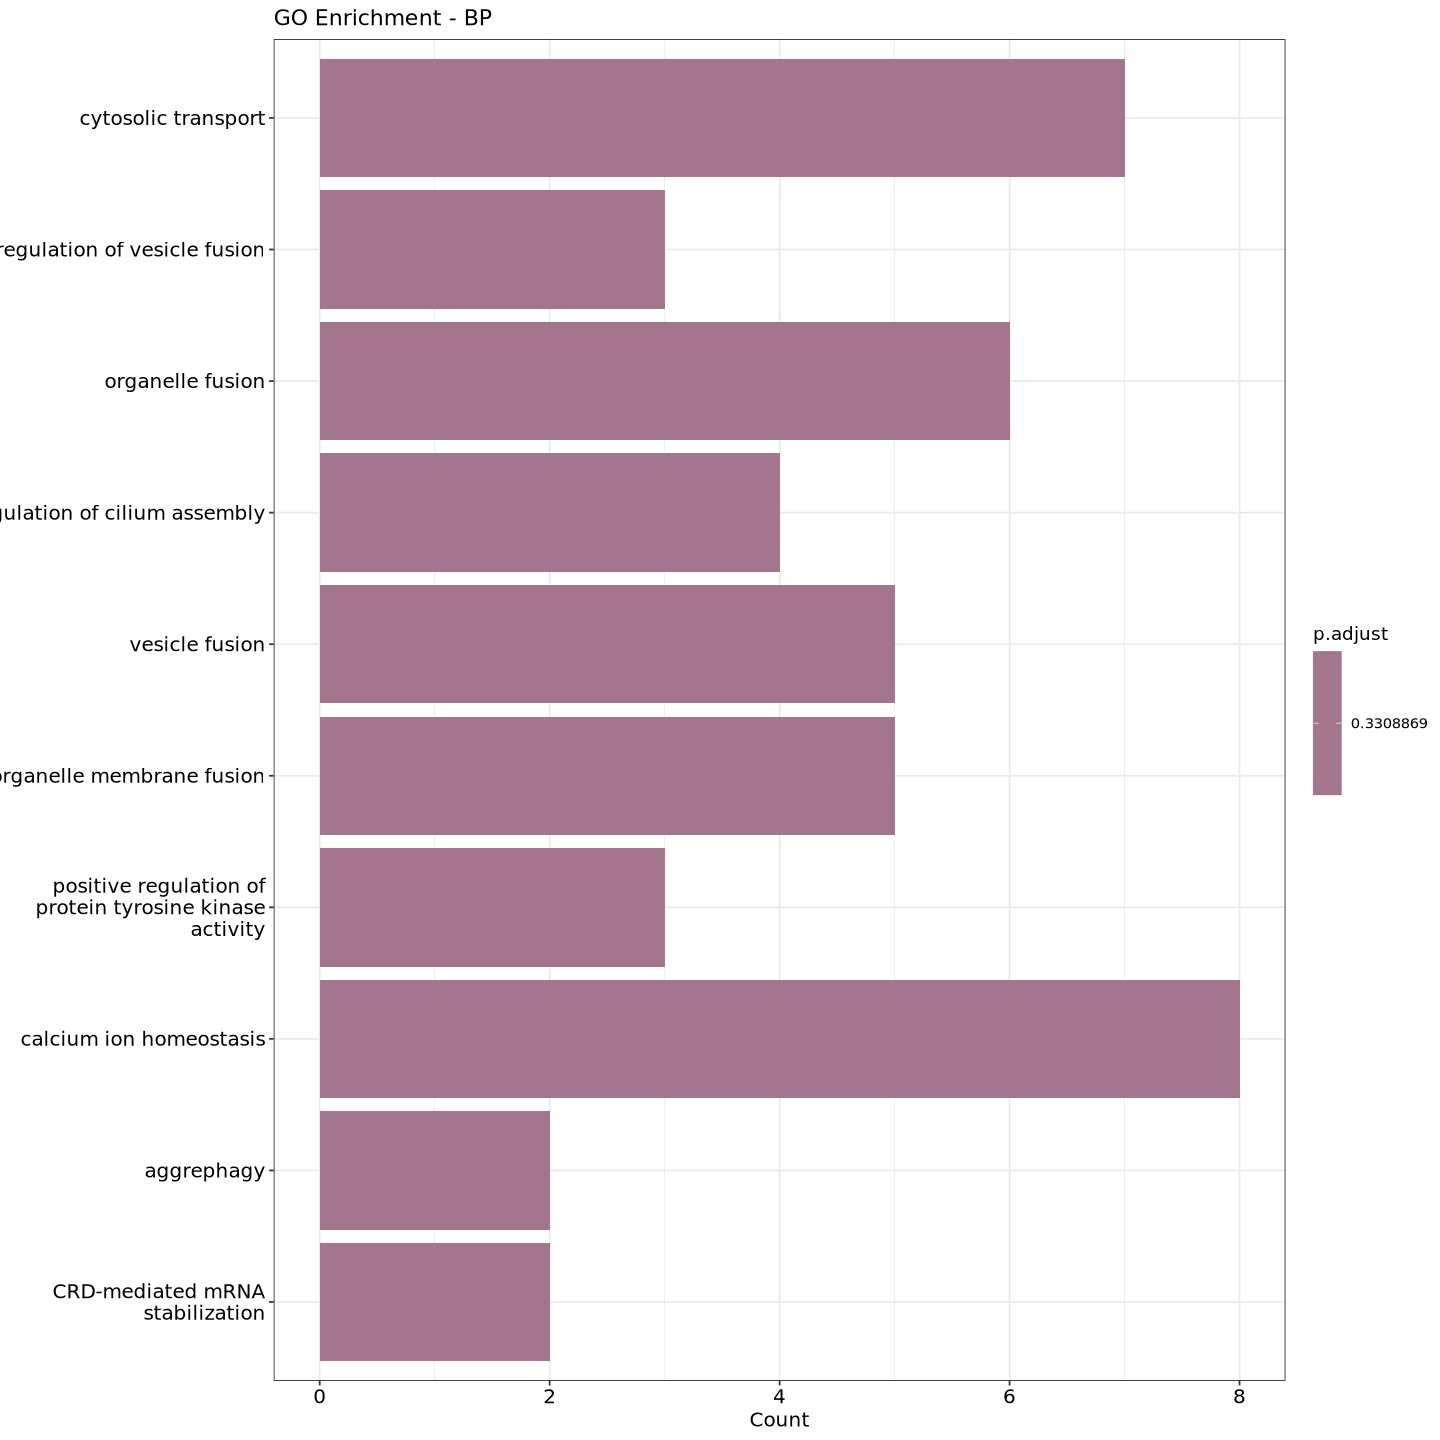

In [322]:
barplot(xqtl_only_ego, showCategory = 10, title = "GO Enrichment - BP")

#### KEGG

In [399]:
entrez_ids <- bitr(xQTL_only$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich_only <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(xQTL_only$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
"1.32% of input gene IDs are fail to map..."


In [400]:
kegg_enrich_only %>% as.data.frame %>% filter(str_detect(Description, 'lipid|Lipid|fatty|Fatty|Alzheimer|Cholesterol'))
kegg_enrich_only %>% as.data.frame %>% filter(str_detect(Description, 'Alzheimer'))

category       subcategory                        ID      
hsa00561 Metabolism     Lipid metabolism                   hsa00561
hsa00604 Metabolism     Glycan biosynthesis and metabolism hsa00604
hsa00603 Metabolism     Glycan biosynthesis and metabolism hsa00603
hsa00564 Metabolism     Lipid metabolism                   hsa00564
hsa04932 Human Diseases Endocrine and metabolic disease    hsa04932
hsa05010 Human Diseases Neurodegenerative disease          hsa05010
         Description                                                GeneRatio
hsa00561 Glycerolipid metabolism                                    2/59     
hsa00604 Glycosphingolipid biosynthesis - ganglio series            1/59     
hsa00603 Glycosphingolipid biosynthesis - globo and isoglobo series 1/59     
hsa00564 Glycerophospholipid metabolism                             1/59     
hsa04932 Non-alcoholic fatty liver disease                          1/59     
hsa05010 Alzheimer disease                                          2/59     
         BgRatio  pvalue     p.adjust  qvalue    geneID     Count
hsa00561 65/8863  0.06939863 0.7798039 0.7798039 55750/1609 2    
hsa00604 15/8863  0.09540382 0.7798039 0.7798039 6483       1    
hsa00603 16/8863  0.10143582 0.7798039 0.7798039 6483       1    
hsa00564 103/8863 0.49940342 0.7838754 0.7838754 1609       1    
hsa04932 157/8863 0.65284917 0.8107516 0.8107516 1350       1    
hsa05010 391/8863 0.74112307 0.8497582 0.8497582 1350/6868  2

category       subcategory               ID       Description      
hsa05010 Human Diseases Neurodegenerative disease hsa05010 Alzheimer disease
         GeneRatio BgRatio  pvalue    p.adjust  qvalue    geneID    Count
hsa05010 2/59      391/8863 0.7411231 0.8497582 0.8497582 1350/6868 2

In [401]:
kegg_enrich_only %>% as.data.frame %>% filter(str_detect(subcategory, 'Neurodegenerative'))

category       subcategory               ID      
hsa05016 Human Diseases Neurodegenerative disease hsa05016
hsa05014 Human Diseases Neurodegenerative disease hsa05014
hsa05010 Human Diseases Neurodegenerative disease hsa05010
hsa05022 Human Diseases Neurodegenerative disease hsa05022
hsa05012 Human Diseases Neurodegenerative disease hsa05012
hsa05020 Human Diseases Neurodegenerative disease hsa05020
         Description                                       GeneRatio BgRatio 
hsa05016 Huntington disease                                3/59      311/8863
hsa05014 Amyotrophic lateral sclerosis                     2/59      371/8863
hsa05010 Alzheimer disease                                 2/59      391/8863
hsa05022 Pathways of neurodegeneration - multiple diseases 2/59      483/8863
hsa05012 Parkinson disease                                 1/59      271/8863
hsa05020 Prion disease                                     1/59      278/8863
         pvalue    p.adjust  qvalue    geneID          Count
hsa05016 0.3426881 0.7798039 0.7798039 7019/83544/1350 3    
hsa05014 0.7139881 0.8474438 0.8474438 83544/1350      2    
hsa05010 0.7411231 0.8497582 0.8497582 1350/6868       2    
hsa05022 0.8396301 0.8612552 0.8612552 83544/1350      2    
hsa05012 0.8409106 0.8612552 0.8612552 1350            1    
hsa05020 0.8484045 0.8619790 0.8619790 1350            1

In [346]:
entrez_ids %>% filter(ENTREZID%in% (kegg_enrich %>% as.data.frame %>% filter(str_detect(Description, 'Alzheimer')) %>% pull(geneID) %>% str_split(., '/') %>% unlist)) %>% merge(.,gene_ref, by.x = 'ENSEMBL', by.y = 'gene_id')

ENSEMBL         ENTREZID #chr start    end      gene_name
1 ENSG00000127184 1350     chr5 86617927 86617928 COX7C    
2 ENSG00000151694 6868     chr2  9556731  9556732 ADAM17

In [406]:
gene.data # xQTL list

5595  1350 83464   351  6868 91252  4722 
    1     1     1     1     1     1     1

In [411]:
gene.data[names(gene.data) %in% c('1350', '6868')] <- 2

In [413]:
gene.data # xQTL list highlight xQTL only

5595  1350 83464   351  6868 91252  4722 
    1     2     1     1     2     1     1

In [415]:
# Make sure gene.data is numeric named vector with correct format and proper range for color mapping
pathview(
  gene.data = gene.data,
  pathway.id = "hsa05010",
  species = "hsa",
  out.suffix = "xQTL_only",
  kegg.native = TRUE,
  limit = list(gene = max(abs(gene.data))),  # set gene color scale limit properly
  low = "green",
  mid = "yellow",
  high = "red",
  na.col = "white"   # color for genes without data
)

'select()' returned 1:1 mapping between keys and columns

Info: Working in directory /home/user/project/FunGen_xQTL/2025/May

Info: Writing image file hsa05010.xQTL_only.png



#### Amyloid pathway genes

In [349]:
go_genes <- AnnotationDbi::select(org.Hs.eg.db, keytype="GOALL", keys="GO:0097242", columns=c("ENSEMBL", "SYMBOL"))


'select()' returned 1:many mapping between keys and columns



In [350]:
go_genes %>% pull(ENSEMBL) %>% unique %>% length

[1] 46

In [389]:
go_genes[,-2] %>% distinct %>% pull(SYMBOL)

[1] "APOE"    "C3"      "C5AR1"   "CD36"    "CLU"     "CLTC"    "CYP51A1"
 [8] "HDAC1"   "HMGCR"   "IDE"     "IFNG"    "IFNGR1"  "IGF1R"   "IL4"    
[15] "INSR"    "ITGAM"   "ITGB2"   "LDLR"    "LRP1"    "LRP2"    "LRP4"   
[22] "LRPAP1"  "MME"     "MSR1"    "RAB5A"   "ROCK1"   "SRF"     "TNF"    
[29] "TNF"     "TNF"     "TNF"     "TNF"     "TNF"     "TNF"     "TNF"    
[36] "TTPA"    "PICALM"  "MARCO"   "RAB11A"  "RAB11B"  "ABCA7"   "PLA2G3" 
[43] "TREM2"   "MYOCD"   "MIR34A"  "MIR1908"

In [362]:
go_genes[,-2] %>% distinct %>% filter(ENSEMBL %in% xQTL_list$gene_id)

GOALL      ONTOLOGYALL ENSEMBL         SYMBOL
1 GO:0097242 BP          ENSG00000197405 C5AR1 
2 GO:0097242 BP          ENSG00000120885 CLU   
3 GO:0097242 BP          ENSG00000073921 PICALM
4 GO:0097242 BP          ENSG00000095970 TREM2

In [364]:
go_genes[,-2] %>% distinct %>% filter(ENSEMBL %in% c(gene_list$gene_id, twas_list$gene_id))

GOALL      ONTOLOGYALL ENSEMBL         SYMBOL
1 GO:0097242 BP          ENSG00000130203 APOE  
2 GO:0097242 BP          ENSG00000197405 C5AR1 
3 GO:0097242 BP          ENSG00000120885 CLU   
4 GO:0097242 BP          ENSG00000119912 IDE   
5 GO:0097242 BP          ENSG00000073921 PICALM
6 GO:0097242 BP          ENSG00000064687 ABCA7 
7 GO:0097242 BP          ENSG00000095970 TREM2

#### context: gene diff list

In [366]:
context_res <- list()
for(i in 1:length(twas_xQTL_list)){
    # entrez_ids <- bitr(diff_list[diff_list %in% twas_xQTL_list[[i]]$molecular_id], fromType = "ENSEMBL", 
    #                toType = "ENTREZID", OrgDb = org.Hs.eg.db)

    context_res[[i]] <- enrichGO(
      gene          = diff_list[diff_list %in% twas_xQTL_list[[i]]$molecular_id],
      OrgDb         = org.Hs.eg.db,
      keyType       = "ENSEMBL",
      ont           = "BP",
      pAdjustMethod = "BH",
      pvalueCutoff  = 0.05,
      qvalueCutoff  = 0.2
    )
}


In [367]:
names(context_res) <- names(twas_xQTL_list)

In [368]:
res <- data.frame()
for(i in seq_along(context_res)){
    if(nrow(head(context_res[[i]])) > 0) {
        print(names(context_res)[[i]])
        res <- rbind(res, as.data.frame(context_res[[i]]) %>% mutate(context = names(context_res)[[i]]))
    }
}

[1] "Ast_DeJager_eQTL"
[1] "Ast_mega_eQTL"
[1] "BM_10_MSBB_eQTL"
[1] "BM_22_MSBB_eQTL"
[1] "BM_36_MSBB_eQTL"
[1] "BM_44_MSBB_eQTL"
[1] "DLPFC_Bennett_pQTL"
[1] "DLPFC_Klein_gpQTL"
[1] "Exc_DeJager_eQTL"
[1] "Exc_mega_eQTL"
[1] "Inh_DeJager_eQTL"
[1] "Inh_mega_eQTL"
[1] "Mic_DeJager_eQTL"
[1] "Mic_mega_eQTL"
[1] "OPC_mega_eQTL"
[1] "Oli_DeJager_eQTL"
[1] "Oli_mega_eQTL"
[1] "PCC_DeJager_eQTL"


In [369]:
res

ID        
GO:0045746  GO:0045746
GO:0005978  GO:0005978
GO:0009250  GO:0009250
GO:0000271  GO:0000271
GO:0005977  GO:0005977
GO:0044042  GO:0044042
GO:0006112  GO:0006112
GO:0008593  GO:0008593
GO:0005976  GO:0005976
GO:0043524  GO:0043524
GO:0051168  GO:0051168
GO:0007219  GO:0007219
GO:0016051  GO:0016051
GO:0043523  GO:0043523
GO:0051402  GO:0051402
GO:0006913  GO:0006913
GO:0051169  GO:0051169
GO:0015980  GO:0015980
GO:0075509  GO:0075509
GO:0046794  GO:0046794
GO:0051209  GO:0051209
GO:0051283  GO:0051283
GO:0051282  GO:0051282
GO:0051208  GO:0051208
GO:0010508  GO:0010508
GO:0035725  GO:0035725
GO:0046718  GO:0046718
GO:0044409  GO:0044409
GO:0097553  GO:0097553
GO:0044000  GO:0044000
...         ...       
GO:0043484  GO:0043484
GO:0009650  GO:0009650
GO:0009411  GO:0009411
GO:0009416  GO:0009416
GO:0006979  GO:0006979
GO:0009314  GO:0009314
GO:0097067  GO:0097067
GO:0006590  GO:0006590
GO:0046697  GO:0046697
GO:0042403  GO:0042403
GO:0001893  GO:0001893
GO:0097066  GO:0097066
GO:0030574  GO:0030574
GO:0060135  GO:0060135
GO:0032963  GO:0032963
GO:0018958  GO:0018958
GO:00065751 GO:0006575
GO:0001890  GO:0001890
GO:0007565  GO:0007565
GO:00467182 GO:0046718
GO:00444092 GO:0044409
GO:0044703  GO:0044703
GO:0044706  GO:0044706
GO:00440002 GO:0044000
GO:00517012 GO:0051701
GO:0042445  GO:0042445
GO:00190581 GO:0019058
GO:00444031 GO:0044403
GO:1904357  GO:1904357
GO:0032205  GO:0032205
            Description                                                         
GO:0045746  negative regulation of Notch signaling pathway                      
GO:0005978  glycogen biosynthetic process                                       
GO:0009250  glucan biosynthetic process                                         
GO:0000271  polysaccharide biosynthetic process                                 
GO:0005977  glycogen metabolic process                                          
GO:0044042  glucan metabolic process                                            
GO:0006112  energy reserve metabolic process                                    
GO:0008593  regulation of Notch signaling pathway                               
GO:0005976  polysaccharide metabolic process                                    
GO:0043524  negative regulation of neuron apoptotic process                     
GO:0051168  nuclear export                                                      
GO:0007219  Notch signaling pathway                                             
GO:0016051  carbohydrate biosynthetic process                                   
GO:0043523  regulation of neuron apoptotic process                              
GO:0051402  neuron apoptotic process                                            
GO:0006913  nucleocytoplasmic transport                                         
GO:0051169  nuclear transport                                                   
GO:0015980  energy derivation by oxidation of organic compounds                 
GO:0075509  endocytosis involved in viral entry into host cell                  
GO:0046794  transport of virus                                                  
GO:0051209  release of sequestered calcium ion into cytosol                     
GO:0051283  negative regulation of sequestering of calcium ion                  
GO:0051282  regulation of sequestering of calcium ion                           
GO:0051208  sequestering of calcium ion                                         
GO:0010508  positive regulation of autophagy                                    
GO:0035725  sodium ion transmembrane transport                                  
GO:0046718  viral entry into host cell                                          
GO:0044409  entry into host                                                     
GO:0097553  calcium ion transmembrane import into cytosol                       
GO:0044000  movement in host                                                    
...         ...                                                            

### twas only list

In [370]:
twas_diff_ego <- enrichGO(
  gene          = twas_diff_list,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)

In [371]:
twas_diff_ego %>% head

ID         Description                                   GeneRatio
GO:0030198 GO:0030198 extracellular matrix organization             14/242   
GO:0043062 GO:0043062 extracellular structure organization          14/242   
GO:0045229 GO:0045229 external encapsulating structure organization 14/242   
GO:0009743 GO:0009743 response to carbohydrate                      11/242   
GO:0051458 GO:0051458 corticotropin secretion                       3/242    
GO:0009650 GO:0009650 UV protection                                 3/242    
           BgRatio   pvalue       p.adjust  qvalue   
GO:0030198 376/21261 0.0001118404 0.1186644 0.1127558
GO:0043062 377/21261 0.0001149963 0.1186644 0.1127558
GO:0045229 379/21261 0.0001215408 0.1186644 0.1127558
GO:0009743 255/21261 0.0001733033 0.1269013 0.1205826
GO:0051458 11/21261  0.0002246324 0.1315897 0.1250375
GO:0009650 12/21261  0.0002969951 0.1428420 0.1357296
           geneID                                                                                                                                                                                                                         
GO:0030198 ENSG00000060718/ENSG00000069399/ENSG00000082293/ENSG00000085998/ENSG00000104884/ENSG00000111799/ENSG00000120708/ENSG00000133392/ENSG00000135862/ENSG00000154175/ENSG00000164692/ENSG00000178031/ENSG00000187498/ENSG00000196569
GO:0043062 ENSG00000060718/ENSG00000069399/ENSG00000082293/ENSG00000085998/ENSG00000104884/ENSG00000111799/ENSG00000120708/ENSG00000133392/ENSG00000135862/ENSG00000154175/ENSG00000164692/ENSG00000178031/ENSG00000187498/ENSG00000196569
GO:0045229 ENSG00000060718/ENSG00000069399/ENSG00000082293/ENSG00000085998/ENSG00000104884/ENSG00000111799/ENSG00000120708/ENSG00000133392/ENSG00000135862/ENSG00000154175/ENSG00000164692/ENSG00000178031/ENSG00000187498/ENSG00000196569
GO:0009743 ENSG00000010310/ENSG00000012061/ENSG00000012232/ENSG00000075391/ENSG00000121691/ENSG00000127616/ENSG00000136504/ENSG00000145242/ENSG00000156711/ENSG00000169375/ENSG00000225697                                                
GO:0051458 ENSG00000120088/ENSG00000166128/ENSG00000263715                                                                                                                                                                                
GO:0009650 ENSG00000012061/ENSG00000104884/ENSG00000121691                                                                                                                                                                                
           Count
GO:0030198 14   
GO:0043062 14   
GO:0045229 14   
GO:0009743 11   
GO:0051458  3   
GO:0009650  3

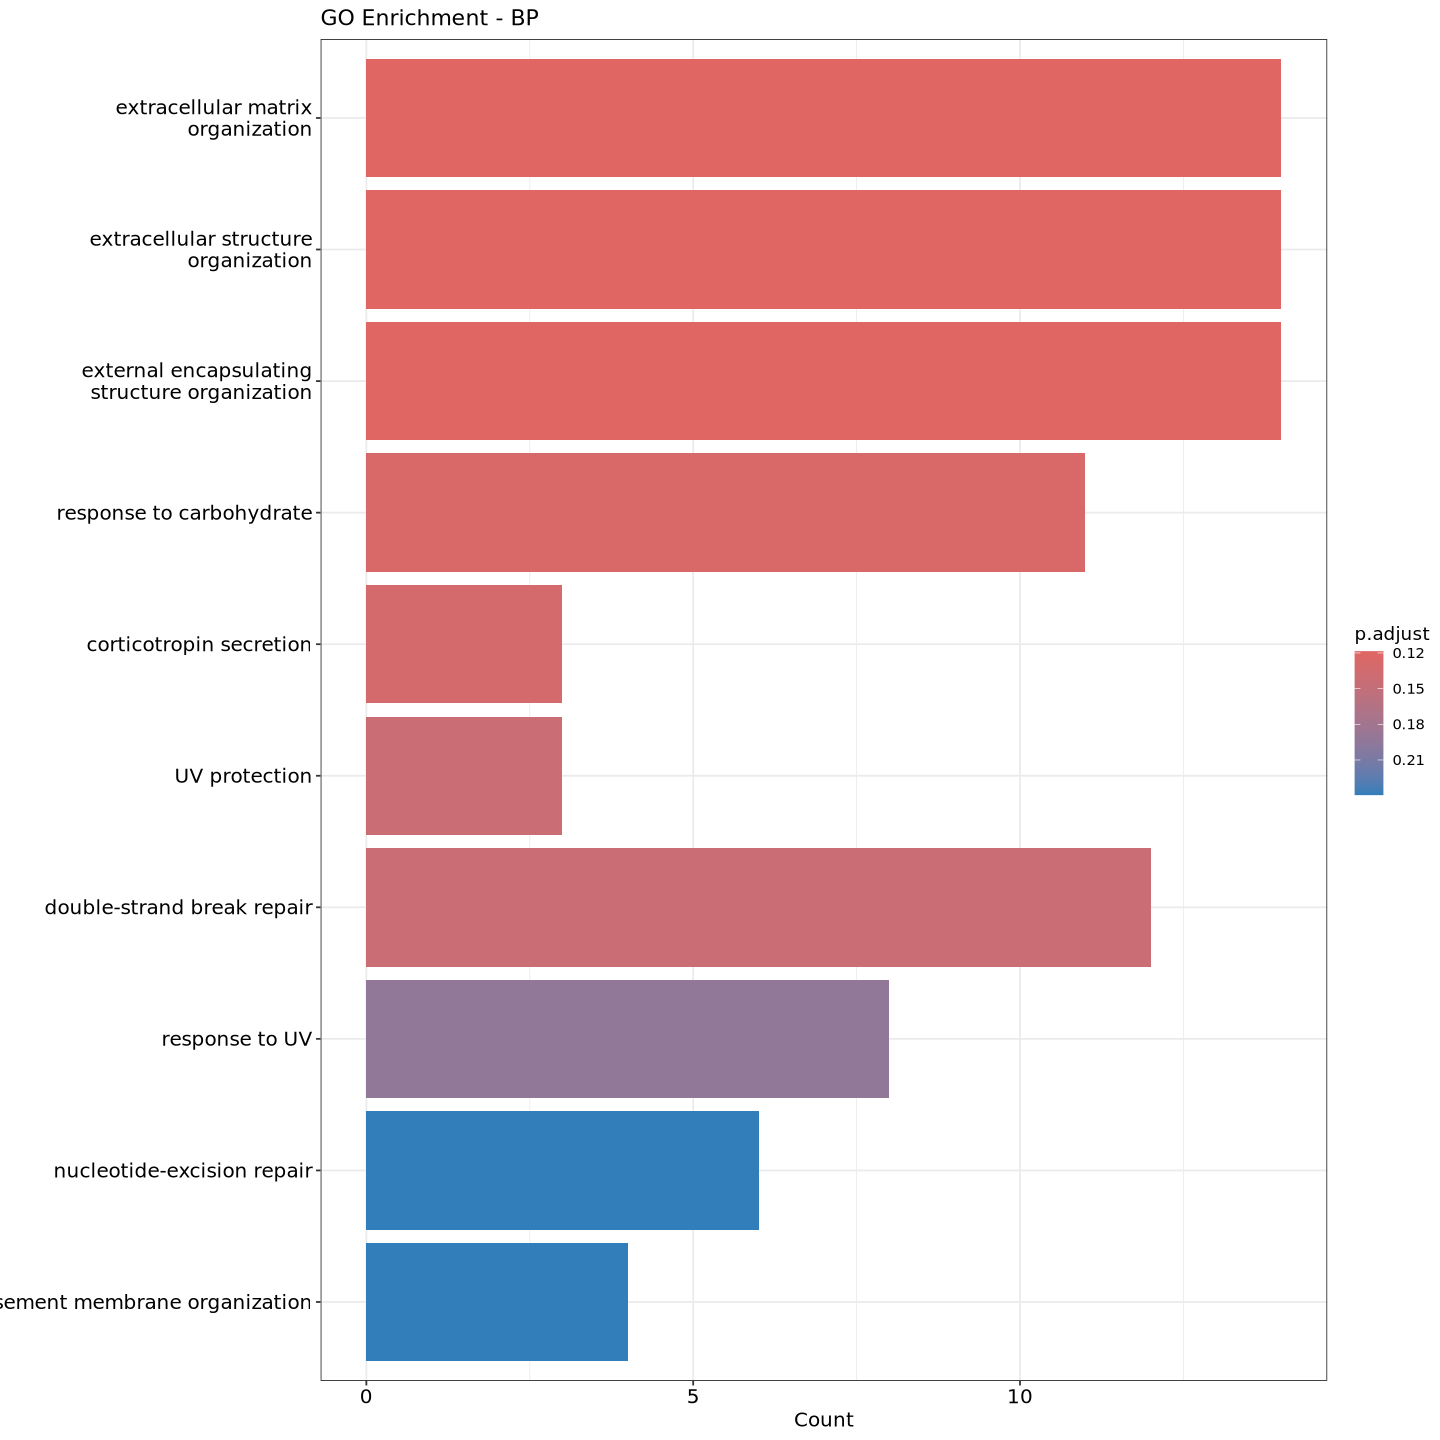

In [372]:
barplot(twas_diff_ego, showCategory = 10, title = "GO Enrichment - BP")

In [373]:
twas_diff_ego %>% as.data.frame %>% filter(str_detect(Description, 'amyloid'))

ID        
GO:0050435 GO:0050435
GO:1902430 GO:1902430
GO:1902992 GO:1902992
GO:0097242 GO:0097242
GO:1902003 GO:1902003
GO:1990000 GO:1990000
GO:0034205 GO:0034205
GO:1902991 GO:1902991
GO:0042987 GO:0042987
GO:0042982 GO:0042982
           Description                                                       
GO:0050435 amyloid-beta metabolic process                                    
GO:1902430 negative regulation of amyloid-beta formation                     
GO:1902992 negative regulation of amyloid precursor protein catabolic process
GO:0097242 amyloid-beta clearance                                            
GO:1902003 regulation of amyloid-beta formation                              
GO:1990000 amyloid fibril formation                                          
GO:0034205 amyloid-beta formation                                            
GO:1902991 regulation of amyloid precursor protein catabolic process         
GO:0042987 amyloid precursor protein catabolic process                       
GO:0042982 amyloid precursor protein metabolic process                       
           GeneRatio BgRatio   pvalue    p.adjust  qvalue   
GO:0050435 2/242     73/21261  0.2018901 0.6088825 0.5785647
GO:1902430 1/242     31/21261  0.2989164 0.6298750 0.5985120
GO:1902992 1/242     34/21261  0.3226202 0.6467313 0.6145289
GO:0097242 1/242     46/21261  0.4097161 0.6749486 0.6413412
GO:1902003 1/242     57/21261  0.4797158 0.6962773 0.6616079
GO:1990000 1/242     61/21261  0.5030658 0.7075611 0.6723299
GO:0034205 1/242     65/21261  0.5253720 0.7150625 0.6794578
GO:1902991 1/242     70/21261  0.5518575 0.7277760 0.6915382
GO:0042987 1/242     83/21261  0.6140317 0.7582204 0.7204667
GO:0042982 1/242     112/21261 0.7234908 0.8074249 0.7672212
           geneID                          Count
GO:0050435 ENSG00000119912/ENSG00000125744 2    
GO:1902430 ENSG00000125744                 1    
GO:1902992 ENSG00000125744                 1    
GO:0097242 ENSG00000119912                 1    
GO:1902003 ENSG00000125744                 1    
GO:1990000 ENSG00000186868                 1    
GO:0034205 ENSG00000125744                 1    
GO:1902991 ENSG00000125744                 1    
GO:0042987 ENSG00000125744                 1    
GO:0042982 ENSG00000125744                 1

### multi gene case - YPEL3

In [120]:
# multi_gene_list <- c('YPEL3', 'INO80E', 'DOC2A', 'MAPK3', 'CORO1A', 'BCKDK', 'TLCD3B', 'ZNF267')
multi_gene_list <- c('ENSG00000090238','ENSG00000169592','ENSG00000149927','ENSG00000102879','ENSG00000149930','ENSG00000149932','ENSG00000102882','ENSG00000103507','ENSG00000149926','ENSG00000185947', 'ENSG00000285043', 'ENSG00000052344')


In [126]:
gene_ref %>% filter(gene_id %in% multi_gene_list)

#chr  start    end      gene_id         gene_name 
1  chr16 29940884 29940885 ENSG00000149932 TMEM219   
2  chr16 29973867 29973868 ENSG00000149930 TAOK2     
3  chr16 29995714 29995715 ENSG00000169592 INO80E    
4  chr16 30023269 30023270 ENSG00000149927 DOC2A     
5  chr16 30052977 30052978 ENSG00000149926 TLCD3B    
6  chr16 30053089 30053090 ENSG00000285043 AC093512.2
7  chr16 30096914 30096915 ENSG00000090238 YPEL3     
8  chr16 30123505 30123506 ENSG00000102882 MAPK3     
9  chr16 30182826 30182827 ENSG00000102879 CORO1A    
10 chr16 31106106 31106107 ENSG00000103507 BCKDK     
11 chr16 31135726 31135727 ENSG00000052344 PRSS8     
12 chr16 31873806 31873807 ENSG00000185947 ZNF267

In [121]:
multigene_ego <- enrichGO(
  gene          = multi_gene_list,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)

In [122]:
multigene_ego %>% head

ID         Description                                              
GO:0031338 GO:0031338 regulation of vesicle fusion                             
GO:0098927 GO:0098927 vesicle-mediated transport between endosomal compartments
GO:0032206 GO:0032206 positive regulation of telomere maintenance              
GO:0006906 GO:0006906 vesicle fusion                                           
GO:0032204 GO:0032204 regulation of telomere maintenance                       
GO:0090174 GO:0090174 organelle membrane fusion                                
           GeneRatio BgRatio   pvalue       p.adjust   qvalue    
GO:0031338 2/11      26/21261  7.855737e-05 0.03055882 0.01852300
GO:0098927 2/11      53/21261  3.305544e-04 0.06429282 0.03897062
GO:0032206 2/11      92/21261  9.931434e-04 0.07133644 0.04324006
GO:0006906 2/11      129/21261 1.938415e-03 0.07133644 0.04324006
GO:0032204 2/11      130/21261 1.968147e-03 0.07133644 0.04324006
GO:0090174 2/11      131/21261 1.998097e-03 0.07133644 0.04324006
           geneID                          Count
GO:0031338 ENSG00000149927/ENSG00000102879 2    
GO:0098927 ENSG00000102879/ENSG00000102882 2    
GO:0032206 ENSG00000169592/ENSG00000102882 2    
GO:0006906 ENSG00000149927/ENSG00000102879 2    
GO:0032204 ENSG00000169592/ENSG00000102882 2    
GO:0090174 ENSG00000149927/ENSG00000102879 2

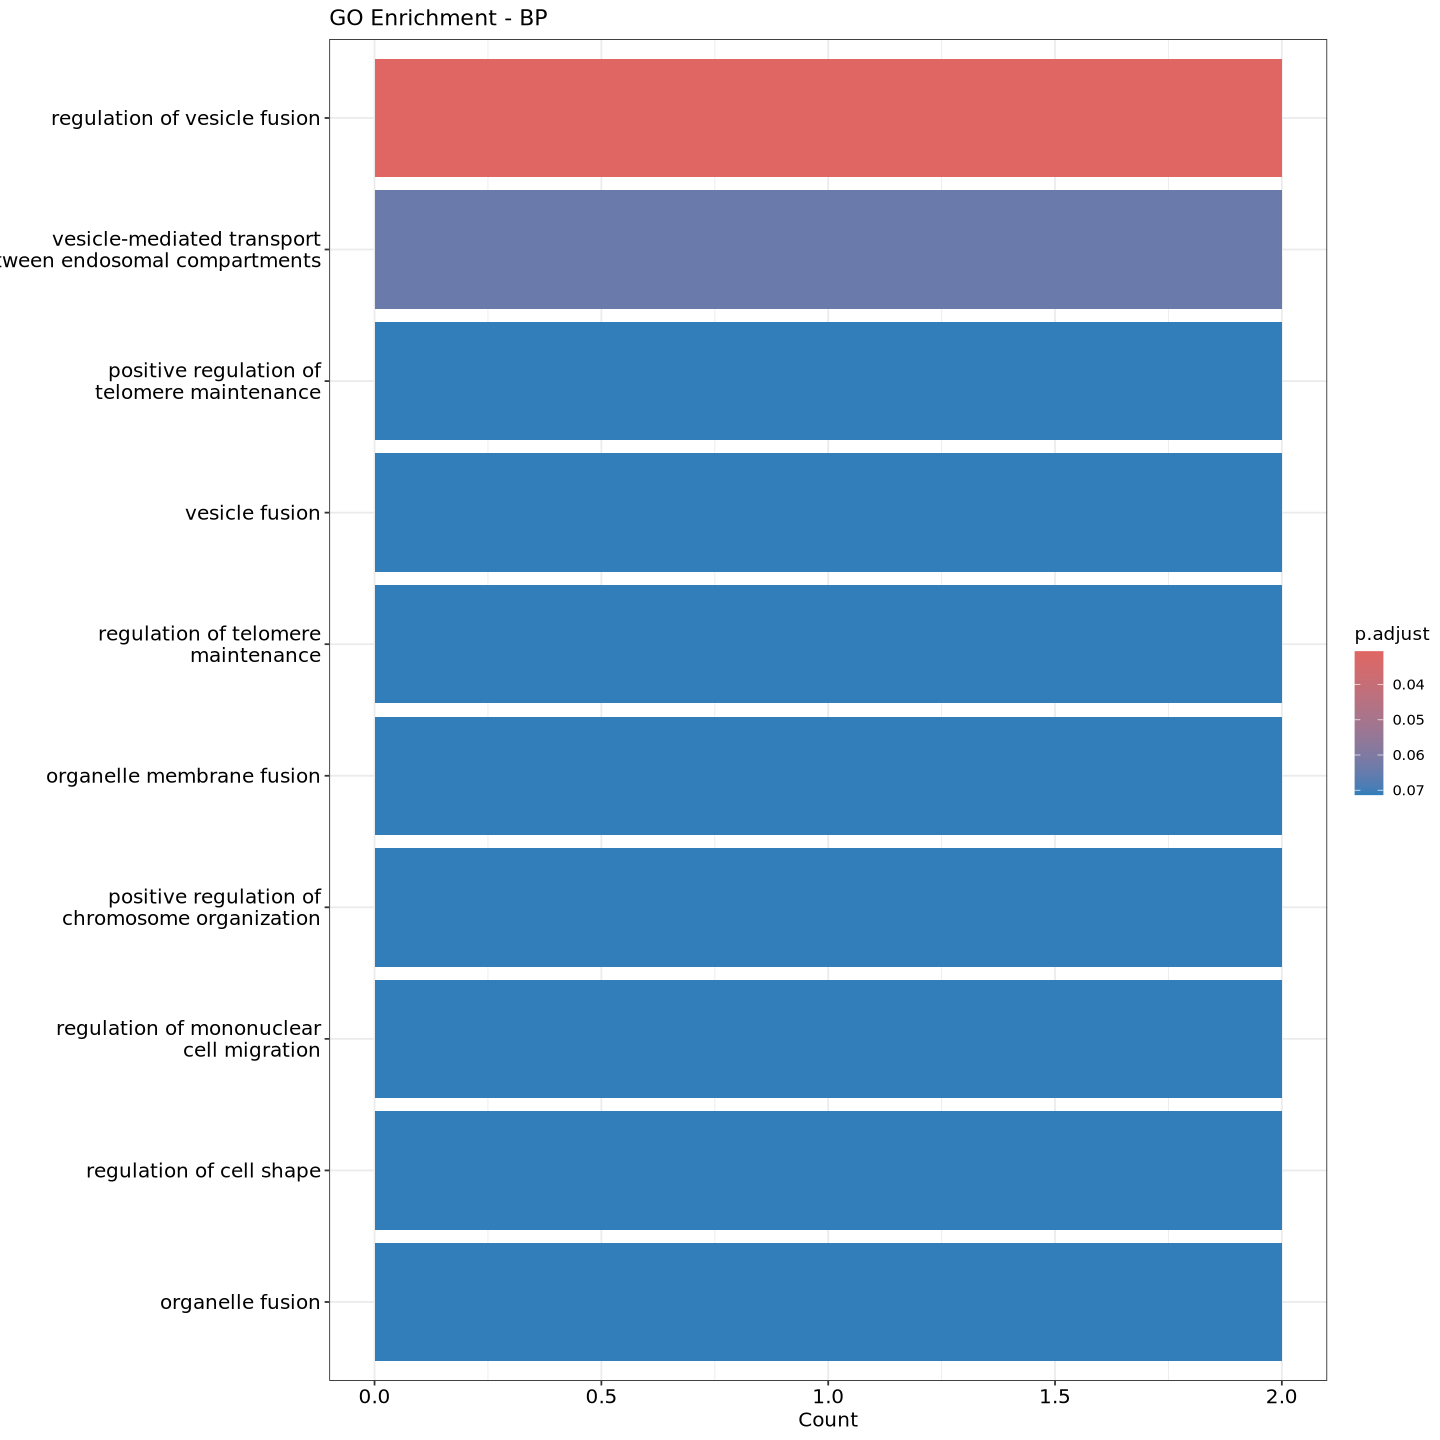

In [123]:
barplot(multigene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [124]:
multigene_ego %>% as.data.frame %>% filter(str_detect(Description, 'amyloid'))

ID Description GeneRatio BgRatio pvalue p.adjust qvalue geneID Count

### multi gene case - NBEAL1

In [444]:
multi_gene_list2 <- c('WDR81', 'TSC22D4', 'ICA1L', 'FAM117B', 'NBEAL1', 'CARF', 'WDR12', "DHX33", "EMG1", "DYSF")
multi_gene_list2 <- gene_ref %>% filter(gene_name %in% multi_gene_list2) %>% pull(gene_id)

In [445]:

multigene_ego <- enrichGO(
  gene          = multi_gene_list2,
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)

In [446]:
multigene_ego %>% as.data.frame %>% arrange(desc(Count))

ID        
GO:0006364 GO:0006364
GO:0016072 GO:0016072
GO:0042254 GO:0042254
GO:0034470 GO:0034470
GO:0043551 GO:0043551
GO:0035973 GO:0035973
GO:0070475 GO:0070475
GO:0000463 GO:0000463
GO:0042117 GO:0042117
GO:0007000 GO:0007000
GO:0050765 GO:0050765
GO:1900227 GO:1900227
GO:0002281 GO:0002281
GO:0141087 GO:0141087
GO:0000466 GO:0000466
GO:0031167 GO:0031167
GO:0000470 GO:0000470
GO:0045943 GO:0045943
GO:0000154 GO:0000154
GO:0000460 GO:0000460
GO:0043550 GO:0043550
GO:0045022 GO:0045022
GO:1900225 GO:1900225
GO:0006356 GO:0006356
GO:0044546 GO:0044546
GO:0141085 GO:0141085
GO:0098927 GO:0098927
GO:0140632 GO:0140632
GO:0141084 GO:0141084
GO:0070050 GO:0070050
...        ...       
GO:0071248 GO:0071248
GO:0006836 GO:0006836
GO:0043414 GO:0043414
GO:1902075 GO:1902075
GO:0031334 GO:0031334
GO:0071241 GO:0071241
GO:0050821 GO:0050821
GO:0048588 GO:0048588
GO:0060560 GO:0060560
GO:0006909 GO:0006909
GO:0042593 GO:0042593
GO:0033500 GO:0033500
GO:0002274 GO:0002274
GO:0032259 GO:0032259
GO:0002221 GO:0002221
GO:0051091 GO:0051091
GO:0002758 GO:0002758
GO:0030100 GO:0030100
GO:0002366 GO:0002366
GO:0002263 GO:0002263
GO:0002218 GO:0002218
GO:0016236 GO:0016236
GO:0031647 GO:0031647
GO:0010038 GO:0010038
GO:1902074 GO:1902074
GO:0030522 GO:0030522
GO:0001701 GO:0001701
GO:0043254 GO:0043254
GO:0051090 GO:0051090
GO:0045089 GO:0045089
           Description                                                                              
GO:0006364 rRNA processing                                                                          
GO:0016072 rRNA metabolic process                                                                   
GO:0042254 ribosome biogenesis                                                                      
GO:0034470 ncRNA processing                                                                         
GO:0043551 regulation of phosphatidylinositol 3-kinase activity                                     
GO:0035973 aggrephagy                                                                               
GO:0070475 rRNA base methylation                                                                    
GO:0000463 maturation of LSU-rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA) 
GO:0042117 monocyte activation                                                                      
GO:0007000 nucleolus organization                                                                   
GO:0050765 negative regulation of phagocytosis                                                      
GO:1900227 positive regulation of NLRP3 inflammasome complex assembly                               
GO:0002281 macrophage activation involved in immune response                                        
GO:0141087 positive regulation of inflammasome-mediated signaling pathway                           
GO:0000466 maturation of 5.8S rRNA from tricistronic rRNA transcript (SSU-rRNA, 5.8S rRNA, LSU-rRNA)
GO:0031167 rRNA methylation                                                                         
GO:0000470 maturation of LSU-rRNA                                                                   
GO:0045943 positive regulation of transcription by RNA polymerase I                                 
GO:0000154 rRNA modification                                                                        
GO:0000460 maturation of 5.8S rRNA                                                                  
GO:0043550 regulation of lipid kinase activity                                                      
GO:0045022 early endosome to late endosome transport                                                
GO:1900225 regulation of NLRP3 inflammasome complex assembly                                        
GO:0006356 regulation of transcription by RNA polymerase I                                          
GO:0044546 NLRP3 inflammasome complex assembly                                                      
GO:0141085 regulation

In [449]:
entrez_ids <- bitr(multi_gene_list2, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich_only <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)
kegg_enrich_only %>% head

'select()' returned 1:1 mapping between keys and columns



category                       subcategory   ID      
hsa04621 Organismal Systems             Immune system hsa04621
hsa03008 Genetic Information Processing Translation   hsa03008
         Description                         GeneRatio BgRatio  pvalue    
hsa04621 NOD-like receptor signaling pathway 1/2       189/8863 0.04219683
hsa03008 Ribosome biogenesis in eukaryotes   1/2       467/8863 0.10261122
         p.adjust   qvalue     geneID Count
hsa04621 0.08439366 0.04441772 56919  1    
hsa03008 0.10261122 0.05400591 10436  1

## PPI

### xQTL 

In [ ]:
# Load necessary libraries
library(STRINGdb)
library(dplyr)
library(igraph)

# Initialize STRINGdb (change species if needed, 9606 = Homo sapiens)
string_db <- STRINGdb$new(version="11.5", species=9606, score_threshold=400, input_directory="")

# Example gene list (use your own gene symbols or Entrez IDs)
genes <- xQTL_list$gene_name

# Map gene names to STRING IDs
mapped_genes <- string_db$map(data.frame(gene=genes), "gene", removeUnmappedRows = TRUE)

# Retrieve interaction network for the genes
ppi_network <- string_db$get_interactions(mapped_genes$STRING_id)

In [ ]:
ppi_network_unique <- ppi_network %>%
  mutate(pair = paste0(pmin(from, to), "_", pmax(from, to))) %>%
  distinct(pair, .keep_all = TRUE)

In [ ]:
genes_with_ppi <- mapped_genes %>% filter(STRING_id %in% c(ppi_network$from, ppi_network$to))
genes_with_ppi %>% dim 

In [ ]:
xQTL_list %>% pull(resource_in_FunGen_xQTL) %>% table

In [241]:
xQTL_list %>% dim

[1] 240   7

In [242]:
xQTL_list %>% filter(!(gene_name %in% genes_with_ppi$gene)) %>% pull(resource_in_FunGen_xQTL) %>% table # the xQTL genes not have any PPI

.
                                                  ColocBoost 
                                                          40 
                                   ColocBoost,single_context 
                                                           2 
                     ColocBoost,single_context,multi_context 
                                                           2 
           ColocBoost,single_context,multi_context,MetaBrain 
                                                           1 
                        ColocBoost,single_context,multi_gene 
                                                           1 
                                                   MetaBrain 
                                                           2 
                                        MetaBrain,ColocBoost 
                                                           1 
                                              single_context 
                                                           1 
      

In [29]:
# whether the genes from ColocBoost are siginificant different from all genes and PPI genes
# Create contingency table
#            | PPI     | No PPI
# ---------- | ------- | -------
# methodA    | 120     | 40
# notMethodA | 66      | 14

# Total genes with PPI = 186
# Total genes without PPI = 240 - 186 = 54
# Total methodA = 160; of which 40 are without PPI → 120 with PPI
# Total not methodA = 80; of which 14 are without PPI → 66 with PPI

mat <- matrix(c(120, 40, 66, 14), nrow = 2,
              dimnames = list(Method = c("methodA", "notMethodA"),
                              PPI = c("PPI", "No_PPI")))

# Perform Fisher's exact test
fisher.test(mat)


	Fisher's Exact Test for Count Data

data:  mat
p-value = 0.2508
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.297715 1.302572
sample estimates:
odds ratio 
 0.6375147 


Even it is not significant, I am still wondering if there are more genes in PPI are detected by >1 methods

In [243]:
symbol_lookup <- dplyr::select(mapped_genes, STRING_id, gene)
symbol_lookup <- dplyr::distinct(symbol_lookup)

In [244]:
options(repr.plot.width = 12, repr.plot.height = 12)
library(igraph)


In [245]:
# Build igraph object
g <- graph_from_data_frame(ppi_network[, c("from", "to")], directed=FALSE)
g <- igraph::simplify(g, remove.multiple = TRUE, remove.loops = TRUE)
# Replace vertex names with gene symbols
V(g)$name <- symbol_lookup$gene[match(V(g)$name, symbol_lookup$STRING_id)]
# Optional: make highlighted genes larger
# V(g)$size <- ifelse(V(g)$name %in% highlight_genes, 8, 4)


#### xQTL only genes labelled by methods 

In [246]:
xQTL_shared_method <- xQTL_list %>% filter(gene_name %in% genes_with_ppi$gene, gene_name %in% xQTL_only$gene_name) %>% filter(str_detect(resource_in_FunGen_xQTL, ',')) %>% pull(gene_name)


Attaching package: 'tidygraph'


The following object is masked from 'package:igraph':

    groups


The following object is masked from 'package:stats':

    filter


Warning message:
"ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


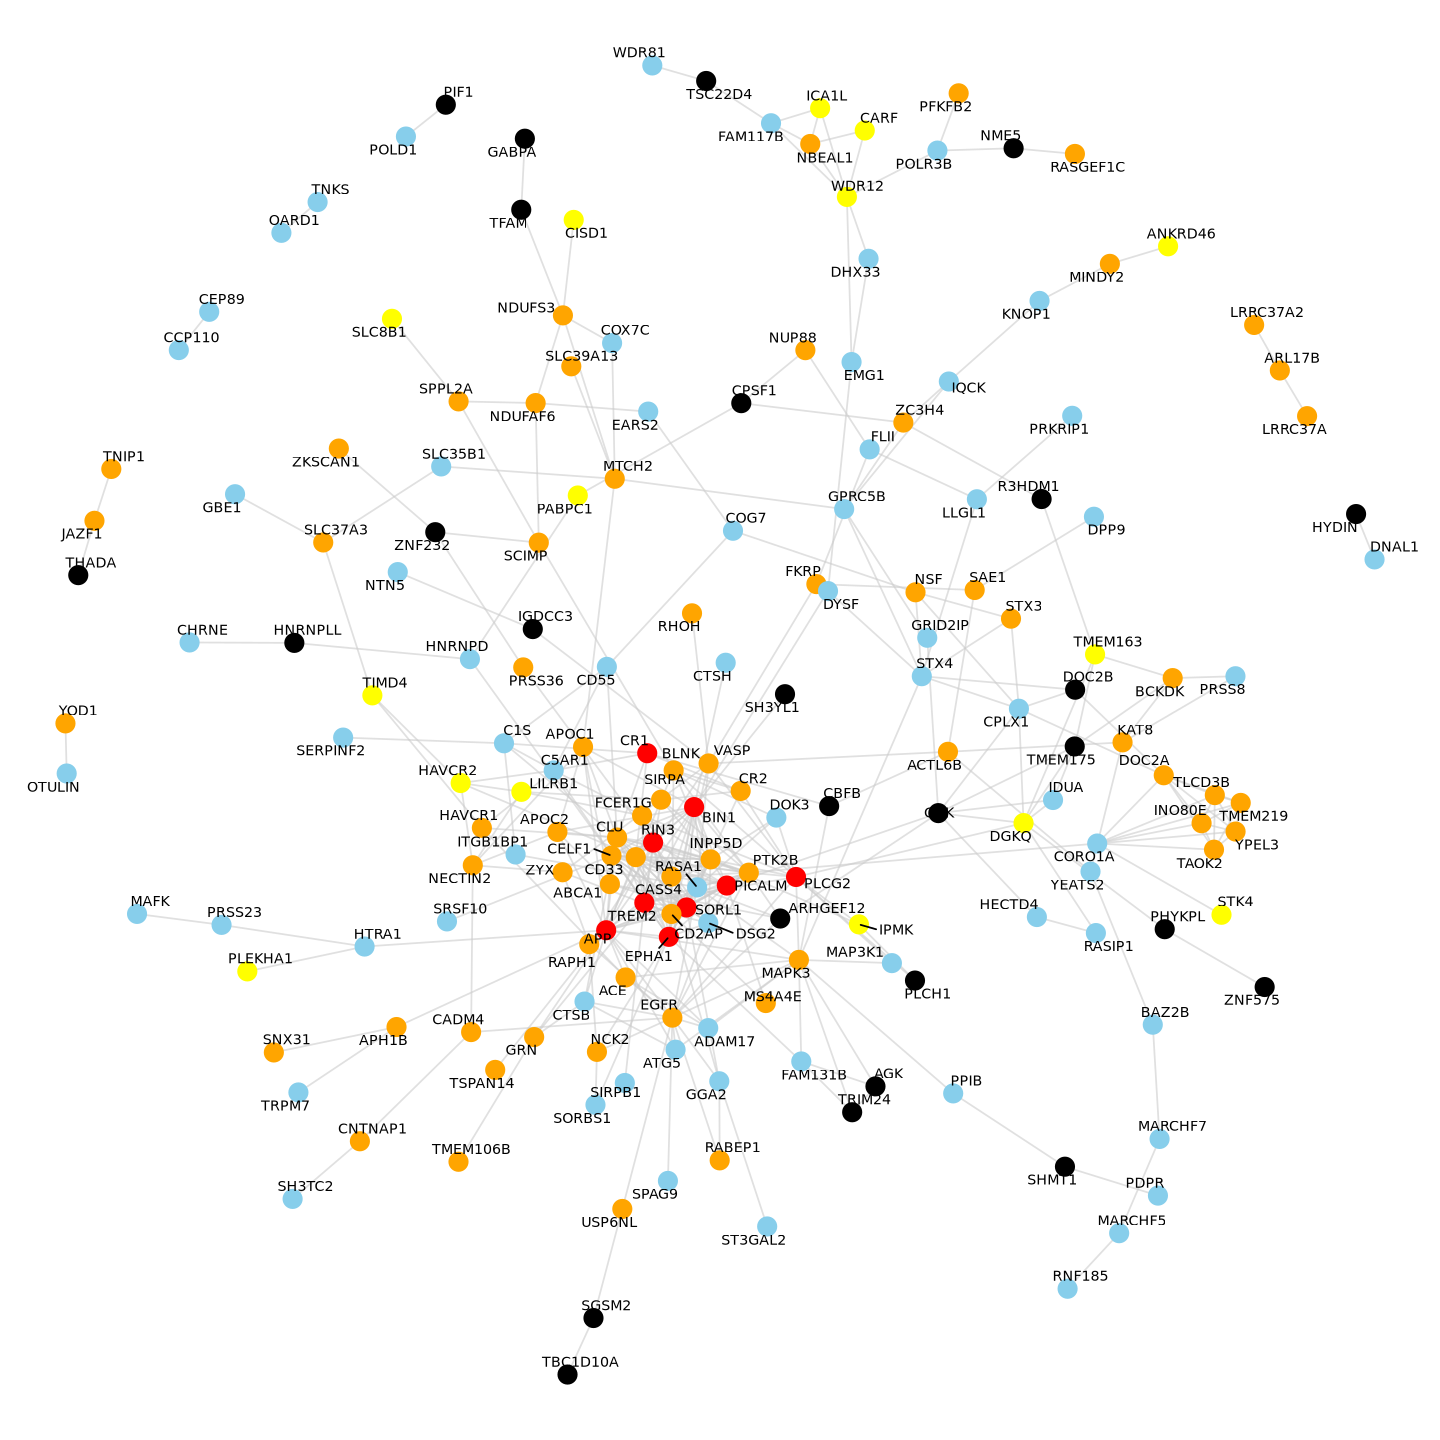

In [34]:
library(tidygraph)
library(ggraph)
tg <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% real_gvc_list$gene_name, "GVC", # highlight GVC2 genes as 'core genes'
                            ifelse(name %in% xQTL_shared_method, "xQTL_only_shared_method", # the genes are xQTL only, but more than 1 methods
                                   ifelse(name %in% xQTL_only_1_se_cb$gene_name, "xQTL_only_only_1_se_cb", # the genes are only from 1 splicing event colocalized results, which are alarming
                                       ifelse(name %in% xQTL_only$gene_name, "xQTL_only_single_method", "shared"))))) # the genes are xQTL only but only from one methods / shared with GVC or TWAS

set.seed(123)
ggraph(tg, layout = "fr") +  # fr: Fruchterman-Reingold layout
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("GVC" = "red", "shared" = "orange", "xQTL_only_shared_method" = "yellow", "xQTL_only_only_1_se_cb" = "black", "xQTL_only_single_method" = "skyblue")) +
  theme_void() +
  theme(legend.position = "none")

#### xQTL only genes labelled by non proxy AD genes 

In [293]:
nonproxy_ad_genes <- readLines('Non_proxy_AD_gene_xQTL.txt')
nonproxy_ad_genes_names <- gene_ref %>% filter(gene_id %in% nonproxy_ad_genes) %>% pull(gene_name)

In [295]:
nonproxy_ad_genes_names %>% length

[1] 128

Warning message:
"ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


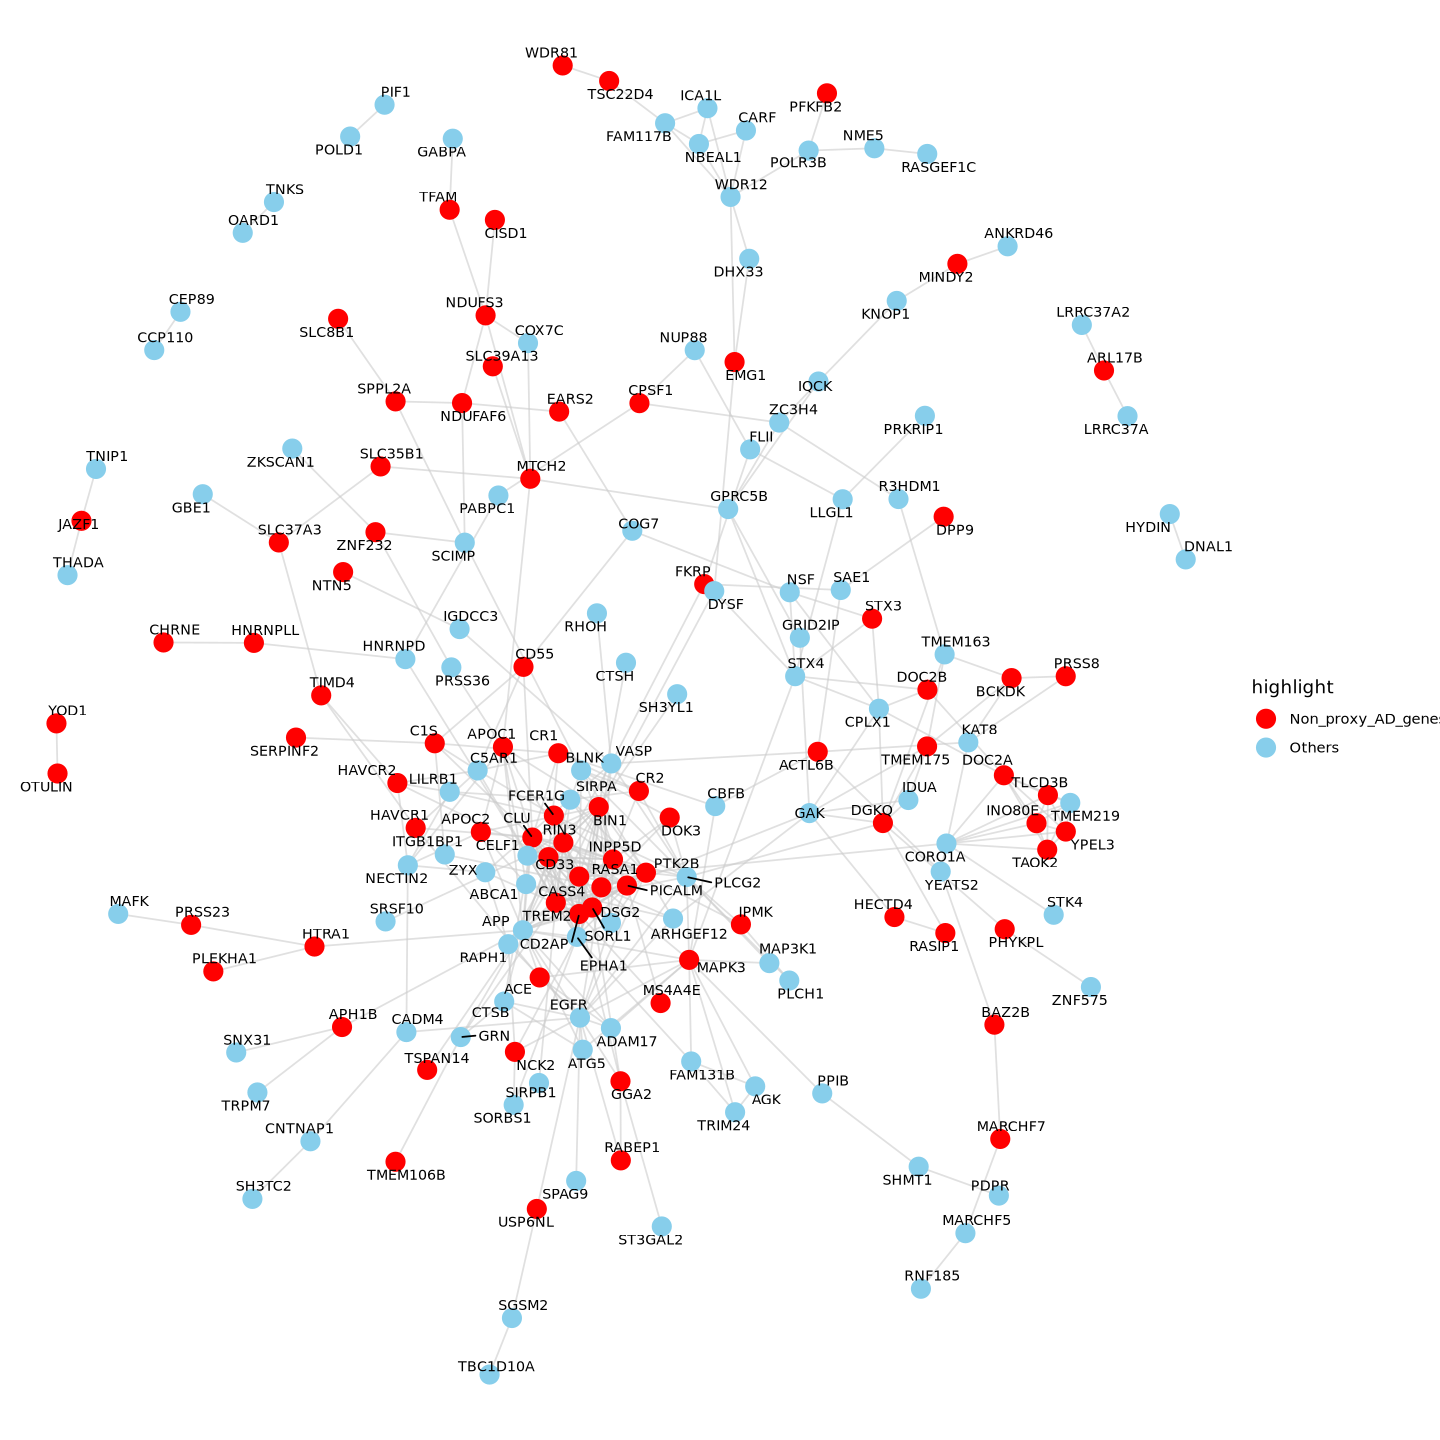

In [296]:
library(tidygraph)
library(ggraph)
tg <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% nonproxy_ad_genes_names, "Non_proxy_AD_genes", "Others")) # the genes are xQTL only but only from one methods / shared with GVC or TWAS

set.seed(123)
ggraph(tg, layout = "fr") +  # fr: Fruchterman-Reingold layout
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("Non_proxy_AD_genes" = "red", "Others" = "skyblue")) +
  theme_void() 

In [225]:
ggsave('./figs/xQTL_list_PPI.pdf', width=10, height=10)

In [35]:
which(tg['DYSF',]>0)

STX4 BIN1 FKRP EMG1 
  45   57   92  182

### xQTL + GVS table2

In [141]:
# Load necessary libraries
library(STRINGdb)
library(dplyr)
library(igraph)

# Initialize STRINGdb (change species if needed, 9606 = Homo sapiens)
string_db <- STRINGdb$new(version="11.5", species=9606, score_threshold=400, input_directory="")

# Example gene list (use your own gene symbols or Entrez IDs)
genes <- c(xQTL_list$gene_name, real_gvc_list$gene_name) %>% unique 

# Map gene names to STRING IDs
mapped_genes <- string_db$map(data.frame(gene=genes), "gene", removeUnmappedRows = TRUE)

# Retrieve interaction network for the genes
ppi_network <- string_db$get_interactions(mapped_genes$STRING_id)

In [142]:
ppi_network_unique <- ppi_network %>%
  mutate(pair = paste0(pmin(from, to), "_", pmax(from, to))) %>%
  distinct(pair, .keep_all = TRUE)

In [143]:
symbol_lookup <- dplyr::select(mapped_genes, STRING_id, gene)
symbol_lookup <- dplyr::distinct(symbol_lookup)

In [151]:
options(repr.plot.width = 12, repr.plot.height = 12)


In [145]:
# Build igraph object
g <- graph_from_data_frame(ppi_network[, c("from", "to")], directed=FALSE)
g <- simplify(g, remove.multiple = TRUE, remove.loops = TRUE)
# Replace vertex names with gene symbols
V(g)$name <- symbol_lookup$gene[match(V(g)$name, symbol_lookup$STRING_id)]
# Define genes to highlight
highlight_genes <- real_gvc_list$gene_name

# Assign color: red for highlighted, gray for others
V(g)$color <- ifelse(V(g)$name %in% highlight_genes, "red", "gray")

# Optional: make highlighted genes larger
V(g)$size <- ifelse(V(g)$name %in% highlight_genes, 8, 4)


In [ ]:
library(tidygraph)
library(ggraph)
tg <- as_tbl_graph(g) %>% 
  mutate(highlight = ifelse(name %in% real_gvc_list$gene_name, "Yes", "No"))


In [151]:
which(tg['CORO1A',] > 0)

SPI1   TAOK2   DOC2A   PTK2B  TLCD3B   YPEL3  INO80E    STK4 TMEM219 
     15      62      83      96      98     128     129     155     191

Warning message:
"ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


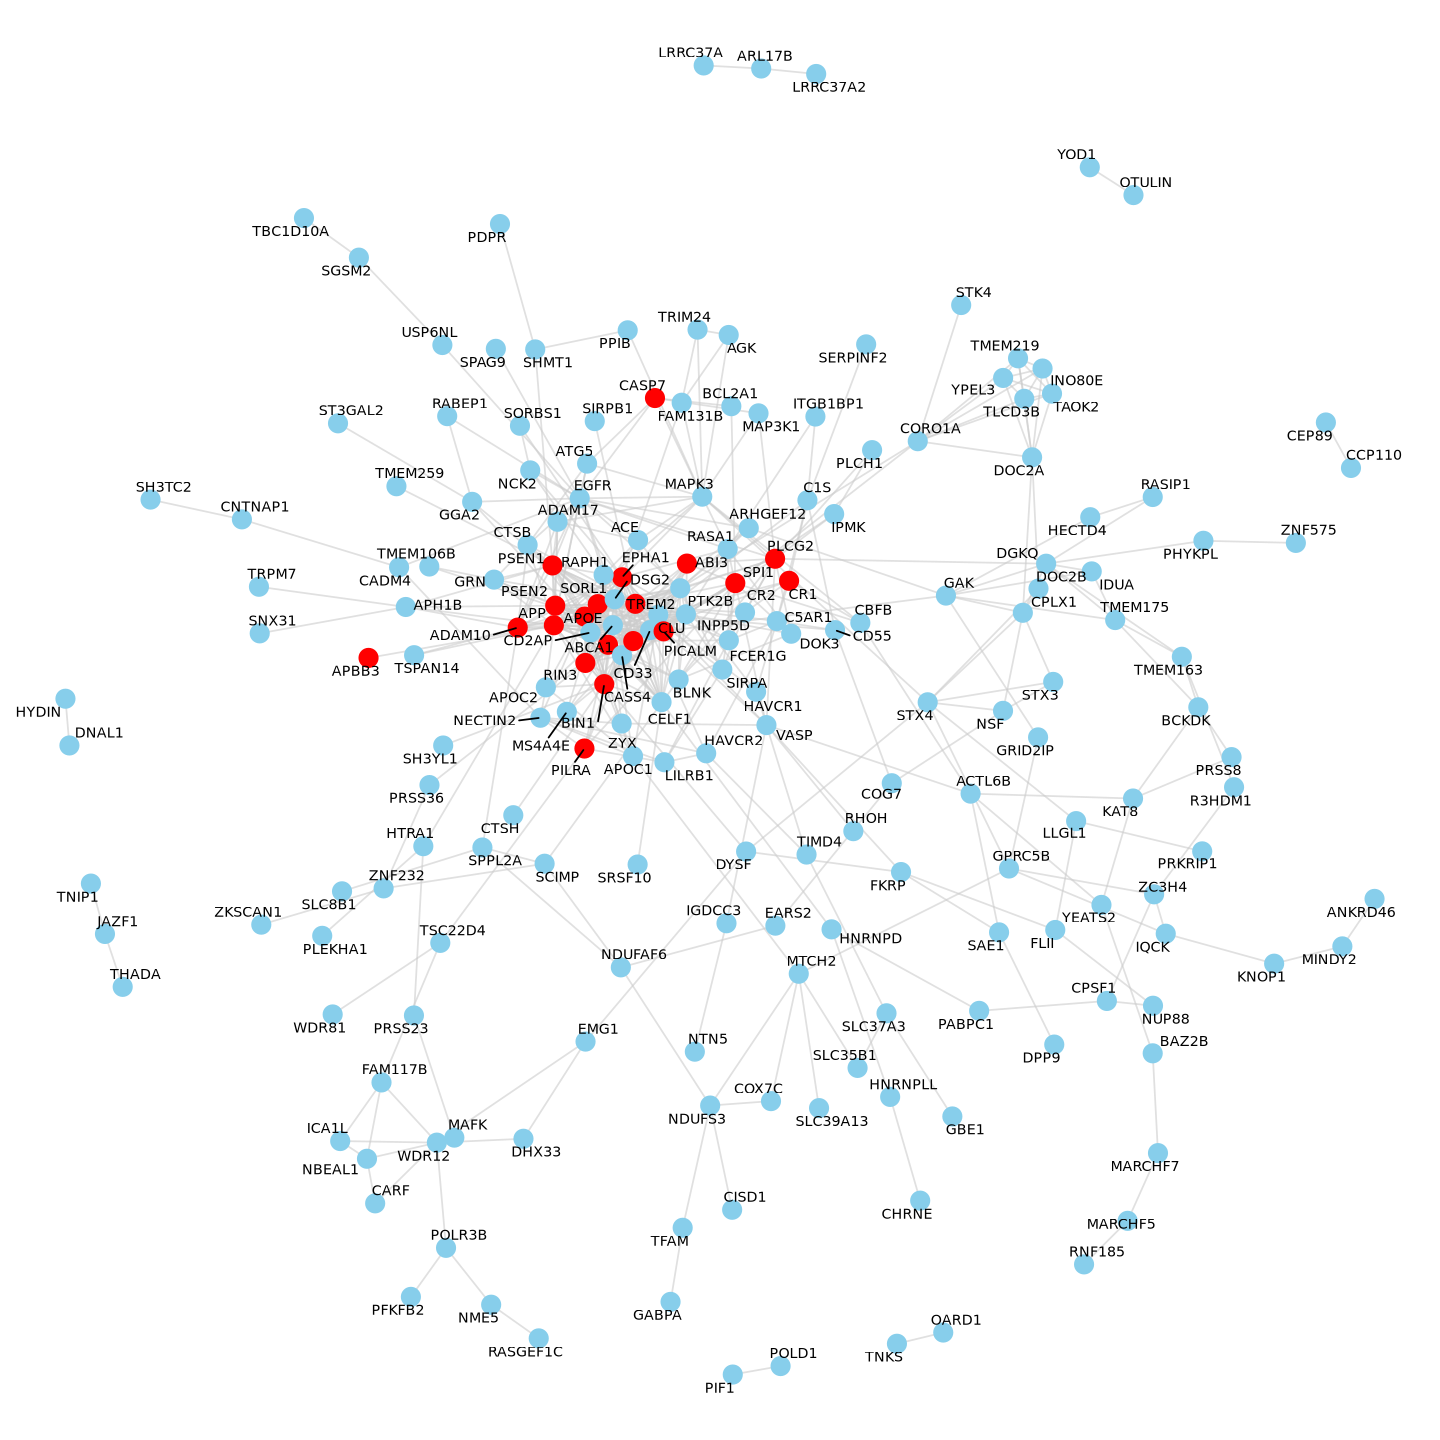

In [147]:
ggraph(tg, layout = "fr") +  # fr: Fruchterman-Reingold s
  geom_edge_link(color = "grey80", alpha = 0.6) +
  geom_node_point(aes(color = highlight), size = 5) +
  geom_node_text(aes(label = name), repel = TRUE, size = 3) +
  scale_color_manual(values = c("Yes" = "red", "No" = "skyblue")) +
  theme_void() +
  theme(legend.position = "none")

### check gene expression
we are wondering why CORO1A was picked by cTWAS, wondering if that gene has a higher expression correlation with others

In [99]:
exp <- fread('/data/eQTL/ROSMAP/DLPFC/analysis_ready/phenotype_preprocessing/dlpfc_batch_all.rnaseqc.low_expression_filtered.outlier_removed.tmm.expression.bed.chr16.mol_phe.bed.gz')

In [100]:
exp %>% head

#chr  start end   gene_id         SM-CTEFX    SM-CJIWX    03_120405 
1 chr16 18067 18068 ENSG00000234769  0.03732274  0.09452324  0.7263884
2 chr16 22909 22910 ENSG00000231439  0.24383900  0.39171142  0.1564774
3 chr16 35194 35195 ENSG00000260803 -0.91723547 -0.21454434 -0.3587397
4 chr16 38320 38321 ENSG00000226942  0.31229530  0.89081249  1.1037484
5 chr16 53607 53608 ENSG00000161980 -0.16537162  1.36698910  0.8940812
6 chr16 53827 53828 ENSG00000161981 -0.04611020  1.44356404  1.2875621
  04_120405  SM-CJIXW    07_120410    ... RISK_97    RISK_99    SM-CTEE8   
1 -0.2870415 -1.24833355 -0.755269049 ... -1.1492866 -1.0189406 -0.33542703
2  1.1450483  0.01536523  0.587425922 ... -1.0115907 -0.9072527  0.19437225
3  0.1631469 -1.16212698 -1.794838030 ... -1.2201268  1.6897891 -0.76994756
4  0.6925110 -1.19285876  0.947748620 ... -1.1928588  0.2574290  0.07910046
5  1.2063807  0.05709961 -0.006584885 ... -0.9650877 -1.8347016 -1.28756214
6  0.7263884  0.33078670  0.528434354 ... -0.8681925 -1.0300698 -1.06039107
  SM-2T6Z5    SM-2T717   SM-CJEHY   SM-AYO4G    SM-CJFL9   SM-AYOSS   
1  0.07029612  0.3146008 -0.6539642 -0.02853817 -2.3403738 -2.41438445
2 -1.02263626 -0.6925110 -0.7523529 -0.93068987 -1.9607137  0.01756047
3 -1.79483803 -0.1077605 -1.7948380 -0.62701716 -1.7948380 -1.79483803
4 -1.19285876  0.6621409  0.5666850 -1.19285876 -1.1928588  0.27790431
5 -1.01525878 -1.0681251 -2.4569939 -0.14981486 -1.6126061 -0.47859867
6 -2.45699387 -1.6126061 -2.3403738 -0.53602111 -0.9546498 -0.44926579
  SM-CJJ2G    
1  2.277320807
2  0.160922913
3  1.124158694
4 -0.006584885
5  0.940892269
6  0.203327376

In [175]:
multi_gene_list <- c('YPEL3', 'INO80E', 'DOC2A', 'MAPK3', 'CORO1A', 'BCKDK', 'TLCD3B', 'ZNF267', 'AC093512.2', 'PRSS8', 'TAOK2', 'TMEM219')
library(clusterProfiler)
library(org.Hs.eg.db)
ensembl_ids <- bitr(multi_gene_list, fromType = "SYMBOL", 
                   toType = "ENSEMBL", OrgDb = org.Hs.eg.db)

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(multi_gene_list, fromType = "SYMBOL", toType = "ENSEMBL", :
"8.33% of input gene IDs are fail to map..."


In [113]:
multigene_exp <- exp %>% filter(gene_id %in% ensembl_ids$ENSEMBL) %>% dplyr::select(-c(1:3)) %>% t
multigene_exp %>% dim

[1] 1142    8

In [114]:
colnames(multigene_exp) <- multigene_exp[1,]
multigene_exp <- multigene_exp[-1,]

In [115]:
colnames(multigene_exp) <- ensembl_ids$SYMBOL[match(colnames(multigene_exp), ensembl_ids$ENSEMBL)]

In [116]:
multigene_exp %>% head

INO80E      DOC2A       TLCD3B      YPEL3       MAPK3      
SM-CTEFX   1.1535456   0.1832001   0.2235373   0.3917114   0.2122988 
SM-CJIWX   1.43123012  1.84664506  1.44981422  1.20184892  0.49341939
03_120405  1.9386875   1.2531321   2.2489074   2.9197941   0.7093479 
04_120405 0.3377499   1.5367961   0.9443149   0.3775306   0.2779043  
SM-CJIXW   2.62141469  0.74075149  0.54363885  1.17955152  0.35406193
07_120410  2.41438445  0.75526905  1.11185698  2.79103738  1.52968559
          CORO1A      BCKDK       ZNF267     
SM-CTEFX   1.8466451  -0.5822173  -1.3782501 
SM-CJIWX   1.68070816  0.93748063 -0.07249667
03_120405  0.7758656  -0.6350527  -0.5770244 
04_120405 1.4312301   0.7523529   0.1876662  
SM-CJIXW   0.03512636 -0.30768933 -2.41438445
07_120410  0.07469757 -0.45169514 -1.19734174

In [248]:
cor(multigene_exp[,'YPEL3'] %>% as.numeric, multigene_exp[,'INO80E'] %>% as.numeric) ## YPEL3 & INO80E
cor(multigene_exp[,'YPEL3'] %>% as.numeric, multigene_exp[,'DOC2A'] %>% as.numeric)## YPEL3 & DOC2A
cor(multigene_exp[,'YPEL3'] %>% as.numeric, multigene_exp[,'CORO1A'] %>% as.numeric)## YPEL3 & CORO1A
cor(multigene_exp[,'INO80E'] %>% as.numeric, multigene_exp[,'CORO1A'] %>% as.numeric)## SPI1 & CORO1A
cor(multigene_exp[,'DOC2A'] %>% as.numeric, multigene_exp[,'CORO1A'] %>% as.numeric)## 
cor(multigene_exp[,'DOC2A'] %>% as.numeric, multigene_exp[,'INO80E'] %>% as.numeric)## 

[1] 0.8114209

[1] 0.8132936

[1] 0.7129139

[1] 0.7003085

[1] 0.8518774

[1] 0.7020182

In [119]:
multigene_exp[,c('YPEL3', 'DOC2A', 'INO80E')] %>% apply(., 2, as.numeric) %>% cor

YPEL3     DOC2A     INO80E   
YPEL3  1.0000000 0.8132936 0.8114209
DOC2A  0.8132936 1.0000000 0.7020182
INO80E 0.8114209 0.7020182 1.0000000

the conclusion is CORO1A not really showing a higher correlation than others  

## Prediction
Use gene set expression, show their prediction to disease

In [311]:
library(pROC)
library(ggplot2)
library(caret)

In [312]:
exp_raw <- fread('/data/eQTL/ROSMAP/DLPFC/analysis_ready/phenotype_preprocessing/DLPFC_samples_list.rnaseqc.gene_tpm.low_expression_filtered.outlier_removed.tmm.expression.remove_duplicates.bed.gz')

In [313]:
exp_raw %>% head

#chr start  end    gene_id         SM-CTDS5    SM-CJIXK  SM-CJGH9  
1 chr1  29569  29570 ENSG00000227232  0.86713223 0.4357151 -0.3668001
2 chr1  52472  52473 ENSG00000268020 -0.07955121 1.6378678  0.2688521
3 chr1  57597  57598 ENSG00000240361 -0.08410743 1.5720367  0.9143990
4 chr1  65418  65419 ENSG00000186092 -0.39610308 1.5798971  0.9638026
5 chr1 133722 133723 ENSG00000238009  0.10691669 0.8804360  0.6916925
6 chr1 135894 135895 ENSG00000268903  2.78006615 1.8077066  0.4658759
  SM-CTDS7     SM-CJGLT   SM-CTDT7    ... RISK_442   RISK_45_rerun SM-CTEGK  
1  0.006811543  0.2688521  1.79619337 ... -0.2383699 -1.377110     -0.5275293
2 -0.182650237  0.2081076 -0.02270692 ... -1.1703806 -1.170381     -1.1703806
3 -0.027249331  0.8905169 -0.11376979 ... -1.2334946 -1.233495     -0.5458851
4 -0.271206929  0.9352923 -0.76268350 ... -1.1243382 -1.875759     -0.6240288
5  0.217397537 -0.2150733  0.77795727 ... -0.3789700 -1.757666      0.4836656
6  0.897288076  1.2190477  0.36922970 ... -1.3626043 -1.362604     -1.3626043
  RISK_51_rerun RISK_67_rerun RISK_73_redo RISK_81   SM-CTEE8   RISK_93   
1 -0.4862194    -1.43189486   -1.5490204   -2.685304 -1.5959174 -2.6098584
2 -1.1703806    -1.17038063    0.7120250   -1.170381 -0.4307273 -1.1703806
3 -1.2334946    -0.62127258   -1.2334946   -1.233495 -1.2334946 -1.2334946
4 -0.4257502    -0.93529230    1.3654825   -1.172635 -1.2888111 -1.8757588
5 -1.7576660    -0.03633594    0.4862194   -1.757666  0.9783555 -0.5804752
6 -1.3626043    -1.36260432   -1.3626043   -1.362604 -1.3626043 -1.3626043
  RISK_97   
1 -0.9006891
2 -0.4034813
3 -0.5912576
4 -1.8757588
5  0.3474399
6 -1.3626043

In [314]:
exp <- exp_raw %>% select(-c(1:3)) %>% t()
colnames(exp) <- exp[1,]
exp <- exp[-1,]

In [315]:
xQTL_list %>% head

gene_id         resource_in_FunGen_xQTL data_resources chr start    
1 ENSG00000002919 ColocBoost              FunGen_xQTL    17   48103356
2 ENSG00000005100 ColocBoost              FunGen_xQTL    17    5468981
3 ENSG00000006530 ColocBoost              FunGen_xQTL     7  141551277
4 ENSG00000008294 ColocBoost              FunGen_xQTL    17   51120867
5 ENSG00000013503 ColocBoost              FunGen_xQTL    12  106357747
6 ENSG00000029725 ColocBoost              FunGen_xQTL    17    5282264
  end       gene_name
1  48103357 SNX11    
2   5468982 DHX33    
3 141551278 AGK      
4  51120868 SPAG9    
5 106357748 POLR3B   
6   5282265 RABEP1

In [316]:
meta <- fread('ROSMAP_clinical_metadata.tsv')
exp_meta <- meta %>% filter(specimenID %in% rownames(exp)) %>% select(specimenID, group)

In [317]:
exp_meta <- exp_meta %>% arrange(match(specimenID, colnames(exp_raw))) 

In [318]:
gvc_exp <- exp_raw %>% filter(gene_id %in% real_gvc_list$gene_id) 
rownames(gvc_exp) <- gvc_exp$gene_id
gvc_exp <- gvc_exp %>% select(any_of(exp_meta$specimenID)) %>% t

### model with glmnet

Loading required package: Matrix


Attaching package: 'Matrix'


The following object is masked from 'package:S4Vectors':

    expand


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



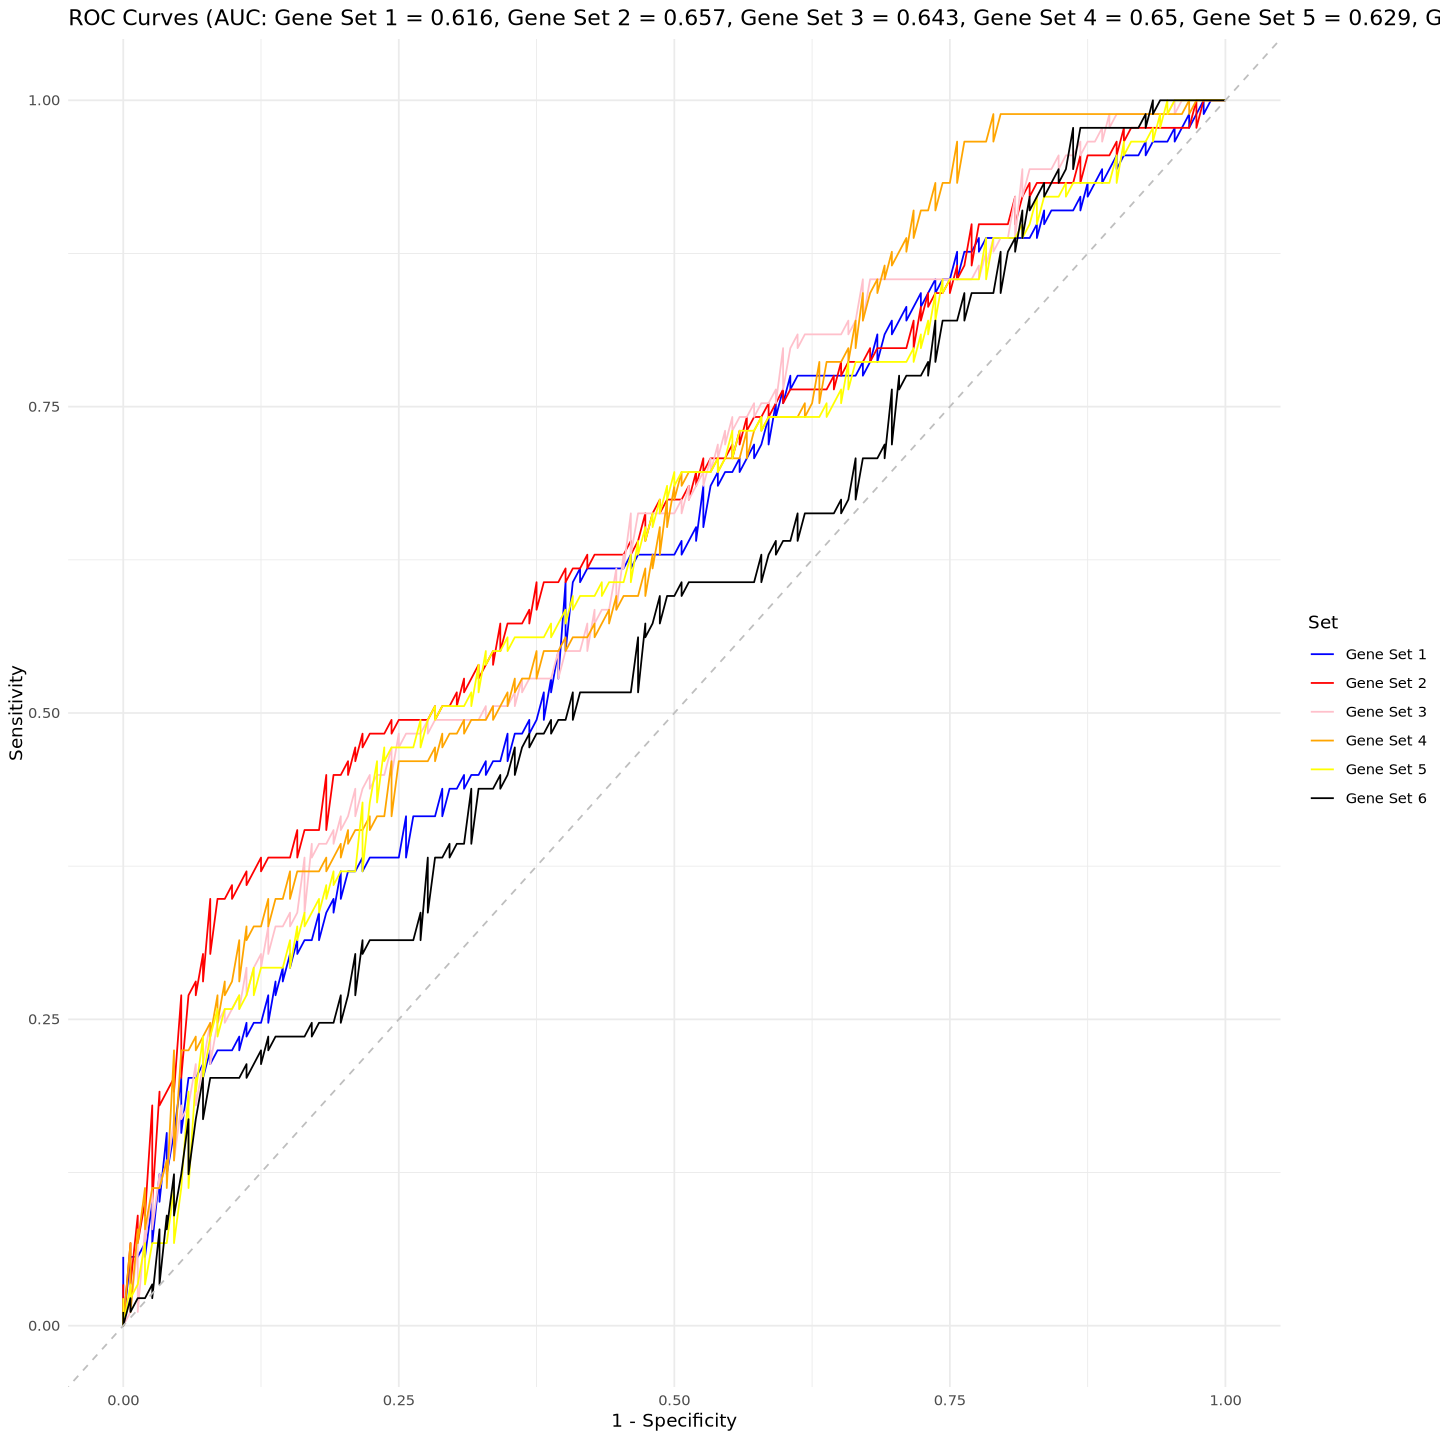

In [214]:

library(dplyr)
library(stringr)
library(caret)
library(pROC)
library(ggplot2)
library(glmnet)

# Function to process xQTL expression data
process_xQTL_exp <- function(exp_raw, gene_ids, exp_meta) {
  exp_data <- exp_raw %>% 
    filter(gene_id %in% gene_ids) %>% 
    column_to_rownames("gene_id") %>% 
    select(any_of(exp_meta$specimenID)) %>% 
    t()
  return(exp_data)
}

# Calculate n_methods and create shared gene sets
xQTL_list <- xQTL_list %>% 
  mutate(n_methods = str_count(resource_in_FunGen_xQTL, ',') + 1)

# Store gene sets for different n_methods thresholds
gene_sets <- list(
  "Gene Set 1" = list(genes = gvc_exp, is_matrix = TRUE),
  "Gene Set 2" = list(genes = xQTL_list$gene_id, is_matrix = FALSE),
  "Gene Set 3" = list(genes = xQTL_list %>% filter(n_methods > 1) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 4" = list(genes = xQTL_list %>% filter(n_methods > 2) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 5" = list(genes = xQTL_list %>% filter(n_methods > 3) %>% pull(gene_id), is_matrix = FALSE),
  "Gene Set 6" = list(genes = xQTL_list %>% filter(n_methods > 4) %>% pull(gene_id), is_matrix = FALSE)
)

# Prepare labels
labels <- exp_meta %>% 
  mutate(labels = ifelse(group == 'ad', 1, 0)) %>% 
  pull(labels)

# Process datasets and remove near-zero variance predictors
data_list <- lapply(names(gene_sets), function(set_name) {
  if (gene_sets[[set_name]]$is_matrix) {
    data <- data.frame(gvc_exp, Disease = as.factor(labels))
  } else {
    exp_data <- process_xQTL_exp(exp_raw, gene_sets[[set_name]]$genes, exp_meta)
    data <- data.frame(exp_data, Disease = as.factor(labels))
  }
  # Remove near-zero variance predictors
  nzv <- nearZeroVar(data[, -ncol(data)], saveMetrics = TRUE)
  data <- data[, !nzv$zeroVar & !nzv$nzv]
  return(data)
})
names(data_list) <- names(gene_sets)

# Split data into train/test
set.seed(123)
trainIndex <- createDataPartition(labels, p = 0.7, list = FALSE)
train_data <- lapply(data_list, function(data) data[trainIndex, ])
test_data <- lapply(data_list, function(data) data[-trainIndex, ])

# Train models with glmnet (L1 regularization) to handle high-dimensional data
models <- lapply(train_data, function(data) {
  x <- as.matrix(data[, -ncol(data)])
  y <- as.factor(data$Disease)
  # Use cross-validation to select lambda
  cv_model <- cv.glmnet(x, y, family = "binomial", alpha = 1, maxit = 1e6)
  return(cv_model)
})

# Make predictions
predictions <- mapply(function(model, test) {
  x_test <- as.matrix(test[, -ncol(test)])
  predict(model, newx = x_test, s = "lambda.min", type = "response")[, 1]
}, models, test_data, SIMPLIFY = FALSE)

# Calculate ROC and AUC
roc_results <- mapply(function(pred, test) {
  roc(test$Disease, pred, levels = c(0, 1), direction = "<")
}, predictions, test_data, SIMPLIFY = FALSE)

auc_values <- lapply(roc_results, auc)

# Prepare ROC data for plotting
roc_data <- do.call(rbind, mapply(function(roc, set_name) {
  data.frame(
    Specificity = 1 - roc$specificities,
    Sensitivity = roc$sensitivities,
    Set = set_name
  )
}, roc_results, names(gene_sets), SIMPLIFY = FALSE))

# Plot ROC curves
ggplot(roc_data, aes(x = Specificity, y = Sensitivity, color = Set)) +
  geom_line() +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(title = paste("ROC Curves (AUC: ", 
                     paste(names(auc_values), "=", round(unlist(auc_values), 3), collapse = ", "), ")", sep = ""),
       x = "1 - Specificity", y = "Sensitivity") +
  scale_color_manual(values = c("Gene Set 1" = "blue", "Gene Set 2" = "red", 
                                "Gene Set 3" = "pink", "Gene Set 4" = "orange", 
                                "Gene Set 5" = "yellow", "Gene Set 6" = "black")) +
  theme_minimal()


### model with glm

In [324]:
real_gvc_list_small <- intersect(xQTL_list$gene_id, real_gvc_list$gene_id)

In [325]:
xQTL_list %>% filter(n_methods > 1) %>% pull(gene_id) %>% unique %>% length

[1] 59

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



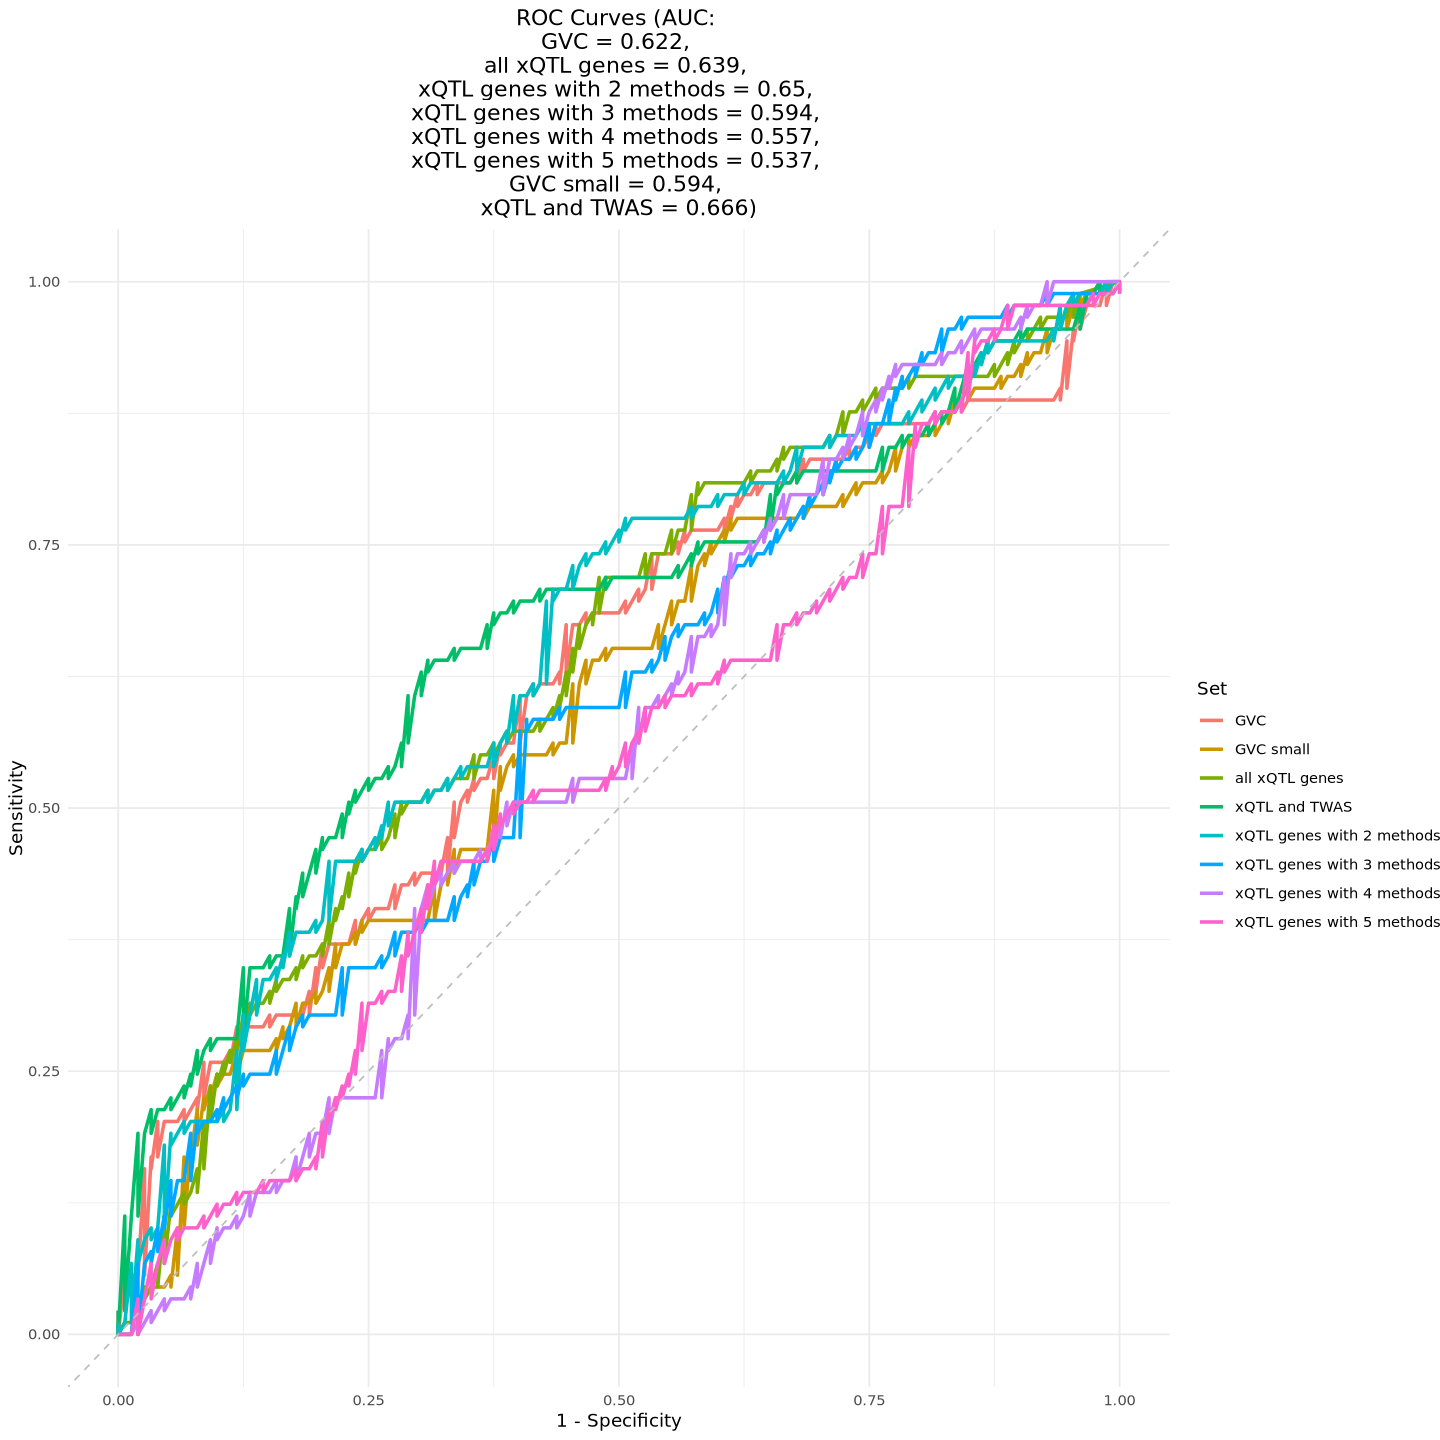

In [346]:
library(dplyr)
library(pROC)
library(ggplot2)
library(caret)
library(stringr)
set.seed(123456)
# Calculate number of methods for each gene
xQTL_list <- xQTL_list %>%
  mutate(n_methods = str_count(resource_in_FunGen_xQTL, ",") + 1)

# Create filtered lists based on number of methods
xQTL_list_shared <- lapply(2:5, function(n) {
  xQTL_list %>% filter(n_methods >= n)
})
names(xQTL_list_shared) <- paste0("shared_", 2:5)

# Function to get transposed expression matrix filtered by gene list
get_exp_matrix <- function(exp, gene_ids) {
  tmp <- exp_raw %>% filter(gene_id %in% gene_ids)
  rownames(tmp) <- tmp$gene_id
  t(tmp %>% select(any_of(exp_meta$specimenID)))
}

# Prepare expression matrices
gvc_small <- get_exp_matrix(gvc_exp, real_gvc_list_small)
xQTL_exp_all <- get_exp_matrix(exp_raw, xQTL_list$gene_id)
xQTL_exp_shared2 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_2$gene_id)
xQTL_exp_shared3 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_3$gene_id)
xQTL_exp_shared4 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_4$gene_id)
xQTL_exp_shared5 <- get_exp_matrix(exp_raw, xQTL_list_shared$shared_5$gene_id)
twas_xQTL_exp_all <- get_exp_matrix(exp_raw,twas_xqtl_list)
# Prepare labels
labels <- exp_meta %>% mutate(labels = ifelse(group == "ad", 1, 0)) %>% pull(labels)

# Create data frames with expression and labels
datasets <- list(
  data1 = data.frame(gvc_exp, Disease = factor(labels)),
  data2 = data.frame(xQTL_exp_all, Disease = factor(labels)),
  data3 = data.frame(xQTL_exp_shared2, Disease = factor(labels)),
  data4 = data.frame(xQTL_exp_shared3, Disease = factor(labels)),
  data5 = data.frame(xQTL_exp_shared4, Disease = factor(labels)),
  data6 = data.frame(xQTL_exp_shared5, Disease = factor(labels)),
  data7 = data.frame(gvc_small, Disease = factor(labels)),
  data8 = data.frame(twas_xQTL_exp_all, Disease = factor(labels))
)

# Split train/test indices
trainIndex <- createDataPartition(labels, p = 0.7, list = FALSE)

# Split datasets into train/test
train_test <- lapply(datasets, function(df) {
  list(train = df[trainIndex, ], test = df[-trainIndex, ])
})

# Fit logistic regression models
models <- lapply(train_test, function(data) {
  glm(Disease ~ ., data = data$train, family = binomial)
})

# Predict probabilities on test sets
predictions <- mapply(function(model, data) {
  predict(model, data$test, type = "response")
}, models, train_test, SIMPLIFY = FALSE)

# Calculate ROC and AUC
rocs <- mapply(function(pred, data) {
  roc(data$test$Disease, pred)
}, predictions, train_test, SIMPLIFY = FALSE)

aucs <- sapply(rocs, auc)

# Prepare ROC data for plotting
roc_data <- do.call(rbind, lapply(seq_along(rocs), function(i) {
  data.frame(
    Specificity = 1 - rocs[[i]]$specificities,
    Sensitivity = rocs[[i]]$sensitivities,
    Set = paste0("Gene Set ", i)
  )
}))

roc_data <- roc_data %>%
  mutate(Set = case_when(
    Set == "Gene Set 1" ~ "GVC",
    Set == "Gene Set 2" ~ "all xQTL genes",
    Set == "Gene Set 3" ~ "xQTL genes with 2 methods",
    Set == "Gene Set 4" ~ "xQTL genes with 3 methods",
    Set == "Gene Set 5" ~ "xQTL genes with 4 methods",
    Set == "Gene Set 6" ~ "xQTL genes with 5 methods",
    Set == "Gene Set 7" ~ "GVC small",
    Set == "Gene Set 8" ~ "xQTL and TWAS",
    TRUE ~ Set
  ))

ggplot(roc_data, aes(x = Specificity, y = Sensitivity, color = Set)) +
  geom_line(size = 1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(
    title = paste0(
      "ROC Curves (AUC: \n",
      paste0(c("GVC", "all xQTL genes", "xQTL genes with 2 methods",
               "xQTL genes with 3 methods", "xQTL genes with 4 methods",
               "xQTL genes with 5 methods", "GVC small", "xQTL and TWAS"),
             " = ", round(aucs, 3), collapse = ", \n"),
      ")"
    ),
    x = "1 - Specificity",
    y = "Sensitivity"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

In [238]:
ggsave('./figs/xQTL_list_AUC_glm.pdf', width=8, height=8)

#### cross sample 

In [348]:
# double check to make the outcome as the factor, so to preserve the class distribution of disease 
str(datasets[[1]]$Disease)

 Factor w/ 2 levels "0","1": 2 1 2 2 1 1 2 1 2 1 ...


In [349]:
                
# Replace train/test split and model training section with cross-validation
ctrl <- trainControl(method = "cv", number = 5, classProbs = TRUE, summaryFunction = twoClassSummary)

# Fit models with cross-validation
models_cv <- lapply(datasets, function(df) {
  df$Disease <- factor(df$Disease, levels = c(0, 1), labels = c("Control", "AD"))  # caret needs factor with levels
  train(Disease ~ ., data = df, method = "glm", family = "binomial",
        trControl = ctrl, metric = "ROC")
})

# Extract AUC from cross-validation
aucs <- sapply(models_cv, function(model) max(model$results$ROC))

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


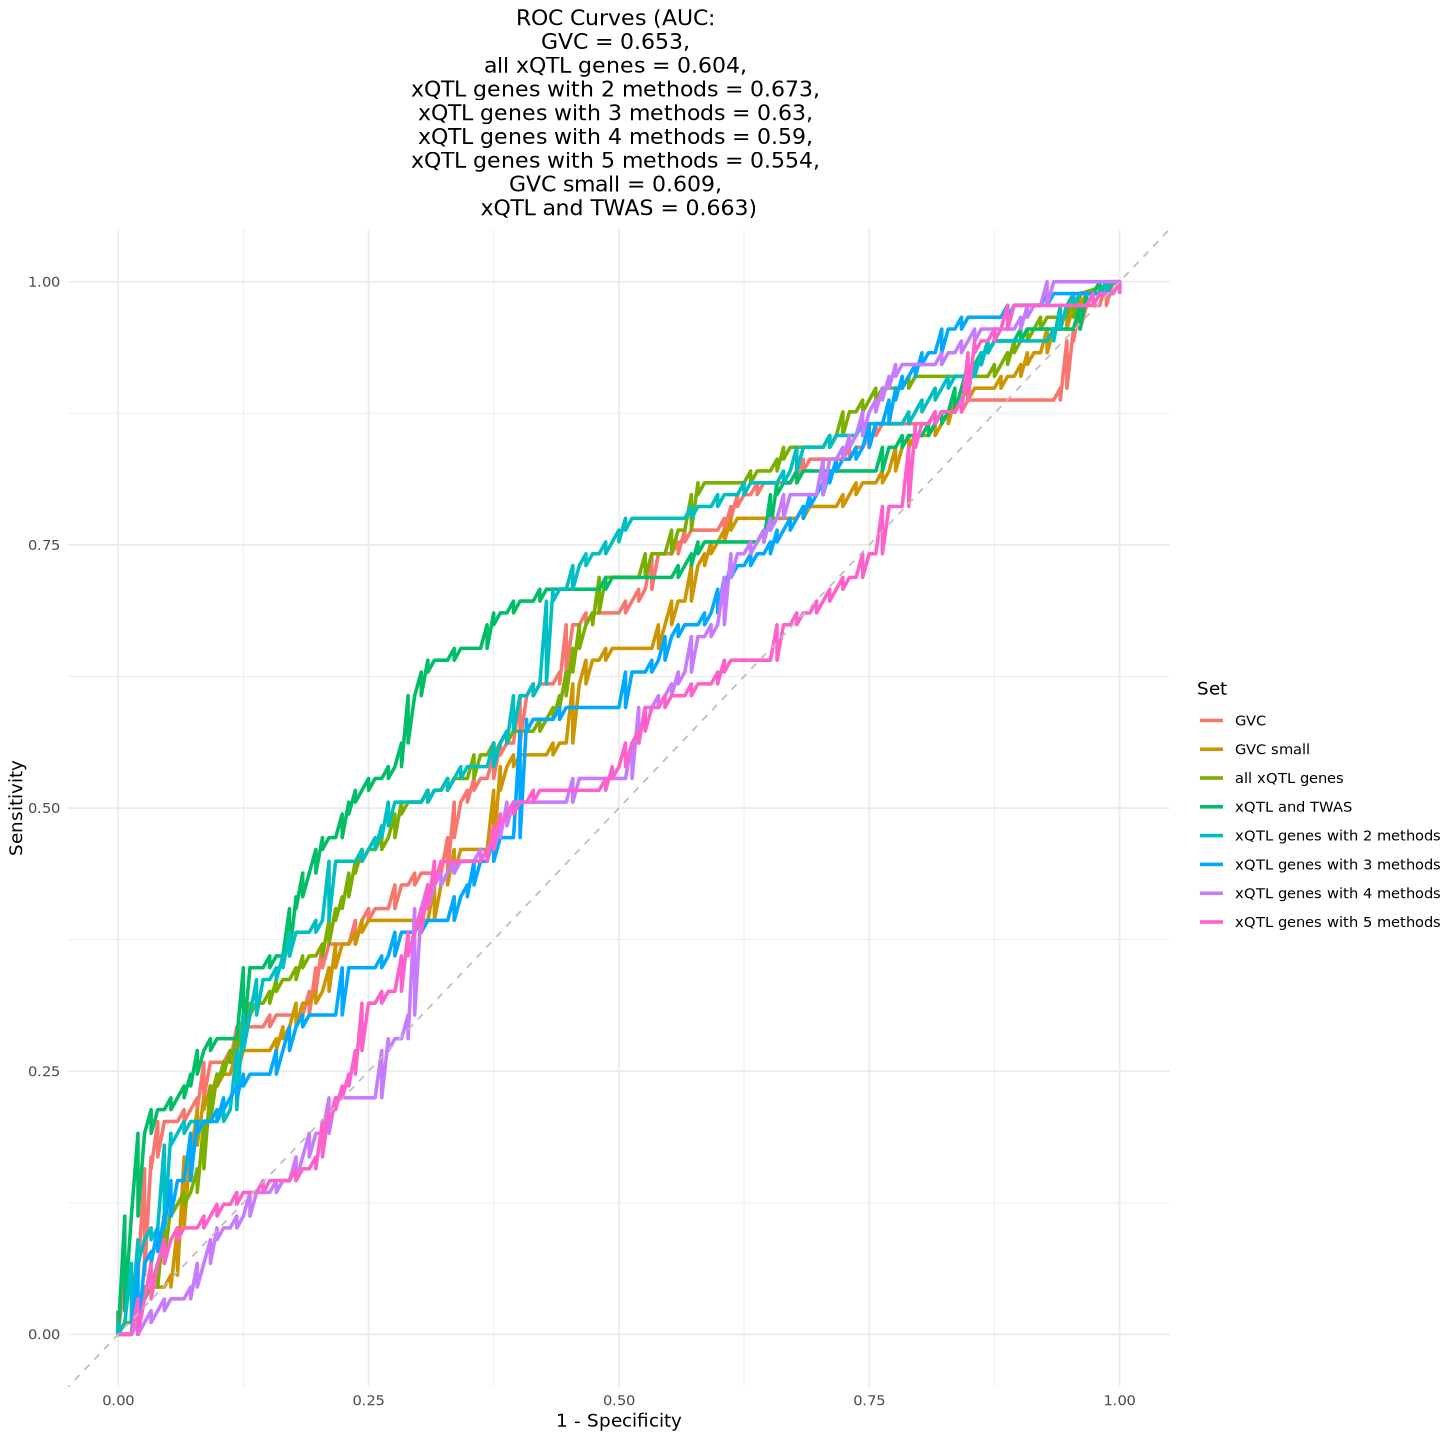

In [351]:
# Prepare ROC data for plotting
roc_data <- do.call(rbind, lapply(seq_along(rocs), function(i) {
  data.frame(
    Specificity = 1 - rocs[[i]]$specificities,
    Sensitivity = rocs[[i]]$sensitivities,
    Set = paste0("Gene Set ", i)
  )
}))

roc_data <- roc_data %>%
  mutate(Set = case_when(
    Set == "Gene Set 1" ~ "GVC",
    Set == "Gene Set 2" ~ "all xQTL genes",
    Set == "Gene Set 3" ~ "xQTL genes with 2 methods",
    Set == "Gene Set 4" ~ "xQTL genes with 3 methods",
    Set == "Gene Set 5" ~ "xQTL genes with 4 methods",
    Set == "Gene Set 6" ~ "xQTL genes with 5 methods",
    Set == "Gene Set 7" ~ "GVC small",
    Set == "Gene Set 8" ~ "xQTL and TWAS",
    TRUE ~ Set
  ))

ggplot(roc_data, aes(x = Specificity, y = Sensitivity, color = Set)) +
  geom_line(size = 1) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  labs(
    title = paste0(
      "ROC Curves (AUC: \n",
      paste0(c("GVC", "all xQTL genes", "xQTL genes with 2 methods",
               "xQTL genes with 3 methods", "xQTL genes with 4 methods",
               "xQTL genes with 5 methods", "GVC small", "xQTL and TWAS"),
             " = ", round(aucs, 3), collapse = ", \n"),
      ")"
    ),
    x = "1 - Specificity",
    y = "Sensitivity"
  ) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))

## GRN

In [123]:
# Load required packages
library(igraph)
library(dplyr)
library(readr)
reg_net_files <- list.files('/data/resource/Functional_annotation/GRN/', pattern = 'txt$', full.names = T)



Attaching package: 'igraph'


The following objects are masked from 'package:lubridate':

    %--%, union


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    as_data_frame


The following object is masked from 'package:IRanges':

    union


The following object is masked from 'package:S4Vectors':

    union


The following objects are masked from 'package:BiocGenerics':

    normalize, path, union


The following object is masked from 'package:clusterProfiler':

    simplify


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [254]:
xqtl_roles_df <- data.frame()
    xqtl_genes <- xQTL_list$gene_name

for(i in 1:length(reg_net_files)){
    reg_net <- read_tsv(reg_net_files[i])
    g <- graph_from_data_frame(reg_net, directed = TRUE)
       
    xqtl_roles <- data.frame(
      gene = xqtl_genes,
      is_in_graph = xqtl_genes %in% V(g)$name,
      out_degree = sapply(xqtl_genes, function(gene) if (gene %in% V(g)$name) degree(g, v = gene, mode = "out") else NA),
      in_degree = sapply(xqtl_genes, function(gene) if (gene %in% V(g)$name) degree(g, v = gene, mode = "in") else NA)
    )
    
    xqtl_roles <- xqtl_roles %>%
      mutate(
        role = case_when(
          is.na(in_degree) ~ "not_in_network",
          out_degree > 0 & in_degree == 0 ~ "regulator",
          in_degree > 0 & out_degree == 0 ~ "target",
          out_degree > 0 & in_degree > 0 ~ "intermediary",
          TRUE ~ "unclassified"),
        file = basename(reg_net_files[i] %>% gsub('.txt','',.))
        
      )
    xqtl_roles_df <- rbind(xqtl_roles_df, xqtl_roles)
}

Rows: 119370 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (7): TF, enhancer, promoter, TG, method, celltype, Regulation
dbl (2): edgeWeight, Correlation

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in graph_from_data_frame(reg_net, directed = TRUE):
"In `d' `NA' elements were replaced with string "NA""
Rows: 111592 Columns: 9
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (7): TF, enhancer, promoter, TG, method, celltype, Regulation
dbl (2): edgeWeight, Correlation

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in graph_from_data_frame(reg_net, directed = TRUE):
"In `d' `NA' elements were replaced with string "NA""
Rows: 

ERROR: Error in graph_from_data_frame(reg_net, directed = TRUE): the data frame should contain at least two columns


In [ ]:
xqtl_roles_df %>% head

In [260]:
fwrite(xqtl_roles_df, "xQTL_roles_df.GRN.tsv", sep = '\t')

In [57]:
xqtl_roles_df <- fread("xQTL_roles_df.GRN.tsv")

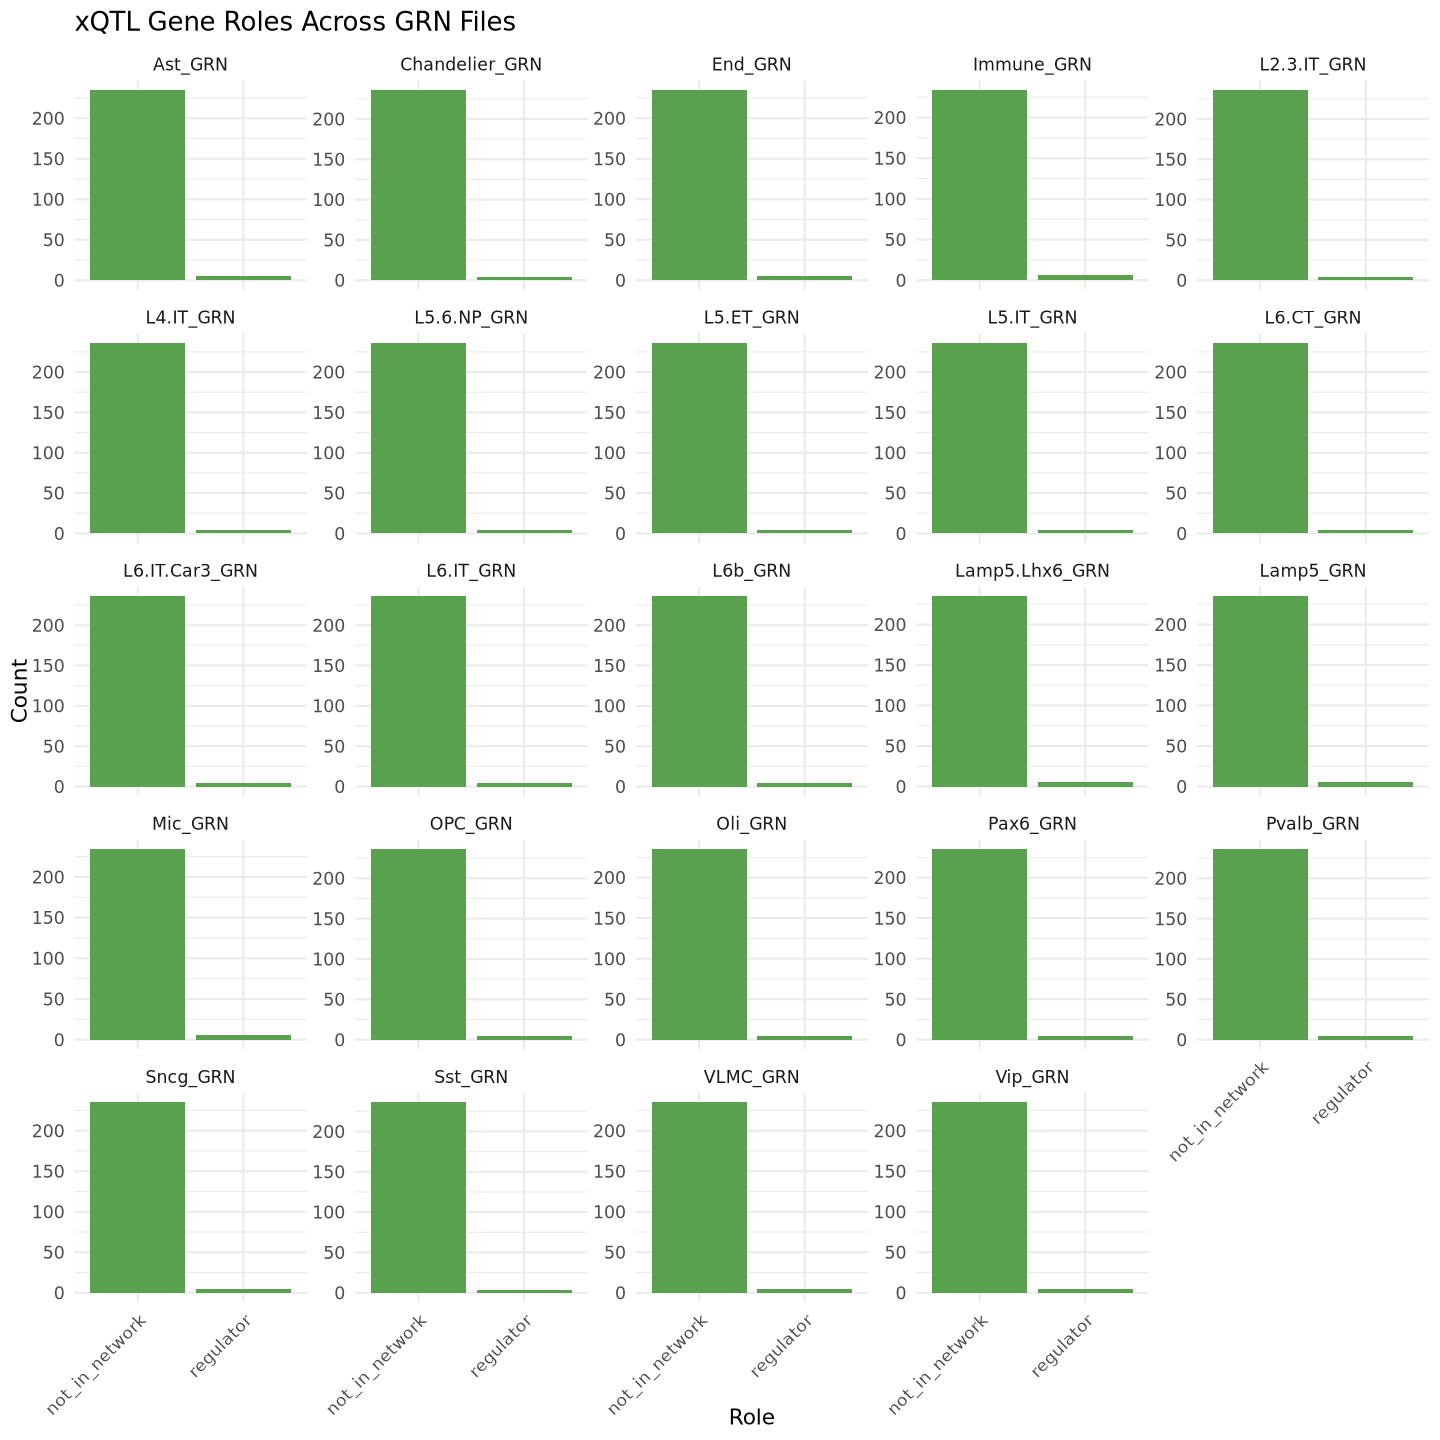

In [58]:
ggplot(xqtl_roles_df, aes(x = role)) +
  geom_bar(fill = "#59A14F") +
  facet_wrap(~ file, scales = "free_y") +
  labs(title = "xQTL Gene Roles Across GRN Files", x = "Role", y = "Count") +
  theme_minimal(base_size = 13) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### fisher test between xQTL and xQTL only genes

In [59]:
# Function to process one GRN file
process_grn <- function(grn_file) {
  grn <- read_tsv(grn_file, show_col_types = FALSE)
  if (!all(c("TF", "TG") %in% names(grn))) return(NULL)
  
  reg_net <- grn %>% select(source = TF, target = TG) %>% distinct()
  g <- graph_from_data_frame(reg_net, directed = TRUE)
  all_genes <- V(g)$name
  
  get_role <- function(gene) {
    if (!(gene %in% V(g)$name)) return("not_in_network")
    in_deg <- degree(g, gene, mode = "in")
    out_deg <- degree(g, gene, mode = "out")
    if (out_deg > 0 & in_deg == 0) return("regulator")
    else if (in_deg > 0 & out_deg == 0) return("target")
    else if (in_deg > 0 & out_deg > 0) return("intermediary")
    else return("unclassified")
  }
  
  role_df <- data.frame(
    gene = all_genes,
    role = sapply(all_genes, get_role),
    group = ifelse(all_genes %in% xQTL_list$gene_name, "xQTL_only", "background"),
    file = basename(grn_file),
    stringsAsFactors = FALSE
  )
  
  return(role_df)
}
# Function to run Fisher test per file (regulator vs others)
run_fisher_per_file <- function(df, set_role) {
  reg_table <- df %>%
    filter(role %in% c("regulator", "target", "intermediary")) %>%
    mutate(role_bin = ifelse(role == set_role, set_role, "other")) %>%
    count(group, role_bin) %>%
    pivot_wider(names_from = role_bin, values_from = n, values_fill = 0)

  # Check that we have exactly two groups and both role types
  required_cols <- c(set_role, "other")
  if (nrow(reg_table) != 2 || !all(required_cols %in% names(reg_table))) {
    return(NA_real_)
  }

  # Safely extract the contingency table
  mat <- matrix(c(
    reg_table[[set_role]][1], reg_table$other[1],
    reg_table[[set_role]][2], reg_table$other[2]
  ), nrow = 2, byrow = TRUE)

  # Ensure matrix is valid for Fisher test
  if (any(dim(mat) != 2) || any(rowSums(mat) == 0) || any(colSums(mat) == 0)) {
    return(NA_real_)
  }

  fisher.test(mat)$p.value
}

In [50]:
# Process all GRNs and combine
all_roles <- map_dfr(reg_net_files, process_grn)
all_roles_filtered <- all_roles %>% filter(role != "not_in_network")

count_table <- all_roles_filtered %>%
  count(file, group, role) %>%
  pivot_wider(names_from = role, values_from = n, values_fill = 0)

print(count_table)

# A tibble: 48 x 5
   file               group      intermediary regulator target
   <chr>              <chr>             <int>     <int>  <int>
 1 Ast_GRN.txt        background          257       127   7899
 2 Ast_GRN.txt        xQTL_only             4         1    127
 3 Chandelier_GRN.txt background          230       178   7441
 4 Chandelier_GRN.txt xQTL_only             3         1    128
 5 End_GRN.txt        background          239       114   7367
 6 End_GRN.txt        xQTL_only             4         1    117
 7 Immune_GRN.txt     background          242        98   7979
 8 Immune_GRN.txt     xQTL_only             6         0    152
 9 L2.3.IT_GRN.txt    background          279       107   9862
10 L2.3.IT_GRN.txt    xQTL_only             4         0    146
# i 38 more rows


In [73]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'regulator'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 x 2
   file               fisher_p_value
   <chr>                       <dbl>
 1 Immune_GRN.txt              0.267
 2 Mic_GRN.txt                 0.267
 3 Oli_GRN.txt                 0.267
 4 Sncg_GRN.txt                0.373
 5 Vip_GRN.txt                 0.373
 6 Chandelier_GRN.txt          0.374
 7 Lamp5_GRN.txt               0.375
 8 L6.IT.Car3_GRN.txt          0.408
 9 L5.IT_GRN.txt               0.409
10 L6b_GRN.txt                 0.409
# i 14 more rows


In [72]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'target'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 x 2
   file               fisher_p_value
   <chr>                       <dbl>
 1 Chandelier_GRN.txt          0.325
 2 Pvalb_GRN.txt               0.325
 3 Sst_GRN.txt                 0.421
 4 OPC_GRN.txt                 0.530
 5 Lamp5_GRN.txt               0.558
 6 L5.IT_GRN.txt               0.663
 7 L4.IT_GRN.txt               0.663
 8 L6.CT_GRN.txt               0.664
 9 L5.6.NP_GRN.txt             0.664
10 L6.IT.Car3_GRN.txt          0.664
# i 14 more rows


In [74]:
# Calculate Fisher p-values per file
fisher_results <- all_roles_filtered %>%
  group_by(file) %>%
  group_split() %>%
  map_dbl(~run_fisher_per_file(.x, set_role = 'intermediary'))

fisher_summary <- tibble(
  file = unique(all_roles_filtered$file),
  fisher_p_value = fisher_results
)

print(fisher_summary %>% arrange(fisher_p_value))

# A tibble: 24 x 2
   file            fisher_p_value
   <chr>                    <dbl>
 1 Mic_GRN.txt              0.465
 2 Immune_GRN.txt           0.470
 3 Pvalb_GRN.txt            0.596
 4 Sncg_GRN.txt             0.788
 5 End_GRN.txt              0.792
 6 Vip_GRN.txt              0.792
 7 Pax6_GRN.txt             0.793
 8 L5.6.NP_GRN.txt          0.799
 9 Lamp5_GRN.txt            0.799
10 Sst_GRN.txt              0.800
# i 14 more rows


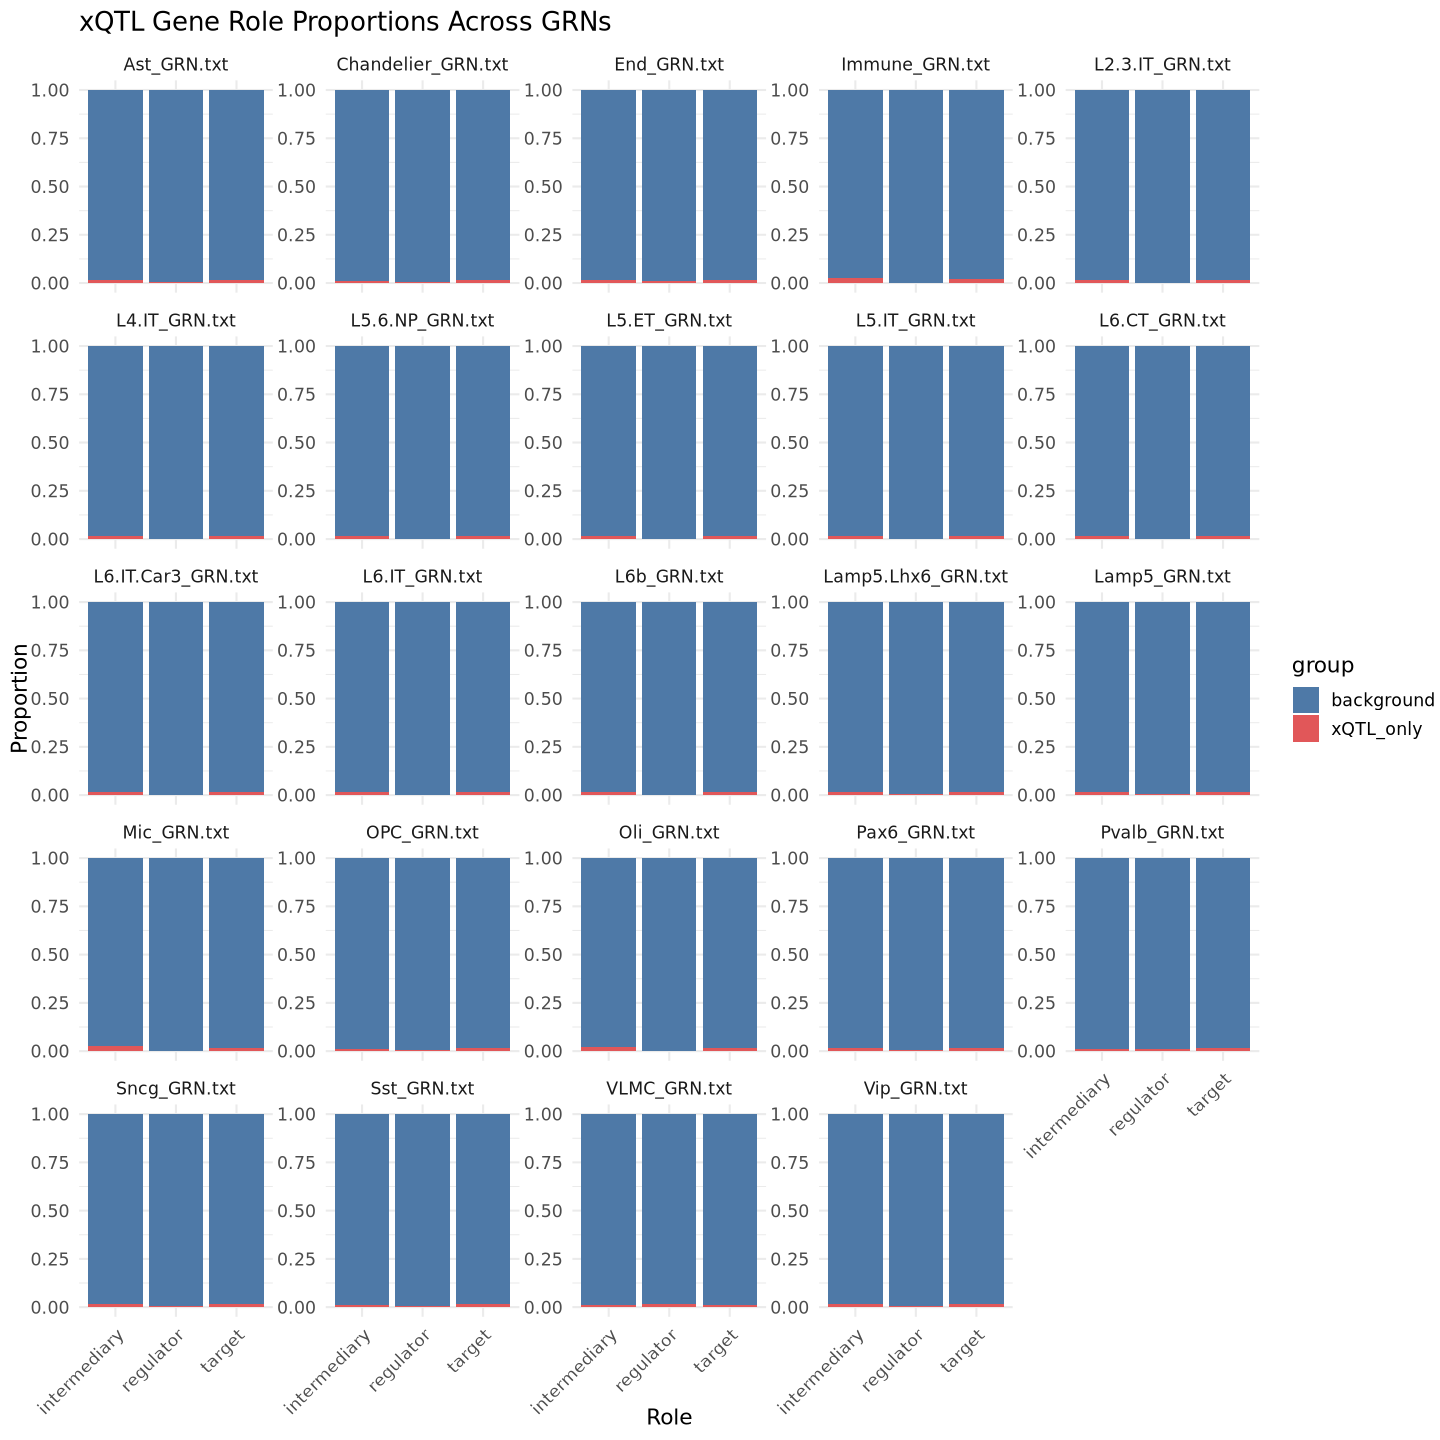

In [75]:
# Visualization: Role distribution per GRN file by group
ggplot(all_roles_filtered, aes(x = role, fill = group)) +
  geom_bar(position = "fill") +
  facet_wrap(~ file, scales = "free_y") +
  labs(title = "xQTL Gene Role Proportions Across GRNs",
       x = "Role", y = "Proportion") +
  scale_fill_manual(values = c("xQTL_only" = "#E15759", "background" = "#4E79A7")) +
  theme_minimal(base_size = 13) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [87]:
all_roles_filtered %>% head

gene    role         group      file       
RXRG...1    RXRG    intermediary background Ast_GRN.txt
NR2F1...2   NR2F1   intermediary background Ast_GRN.txt
IRF1...3    IRF1    intermediary background Ast_GRN.txt
ESR1...4    ESR1    intermediary background Ast_GRN.txt
ZNF143...5  ZNF143  intermediary background Ast_GRN.txt
CREB3L1...6 CREB3L1 intermediary background Ast_GRN.txt

In [93]:
df <- data.frame()
for(i in reg_net_files){
    df <- rbind(df, fread(i) %>% mutate(file = basename(i)))
}

In [239]:
df %>% head

TF      enhancer             promoter           TG     edgeWeight method 
1 RXRG    chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.12987922 scGRNom
2 NR2F1   chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.06547182 scGRNom
3 IRF1    chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.06022639 scGRNom
4 ESR1    chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.06465946 scGRNom
5 ZNF143  chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.04856990 scGRNom
6 CREB3L1 chr1:1019276-1019776 chr1:958584-960584 KLHL17 0.09256433 scGRNom
  celltype Correlation Regulation file       
1 Ast       0.6773105  Activating Ast_GRN.txt
2 Ast      -0.1551904  Repressing Ast_GRN.txt
3 Ast       0.6686182  Activating Ast_GRN.txt
4 Ast       0.5641387  Activating Ast_GRN.txt
5 Ast       0.3650754  Activating Ast_GRN.txt
6 Ast       0.7666757  Activating Ast_GRN.txt

In [240]:
saveRDS(df, 'all_GRN.rds')

### Multigene GRN -YPEL3

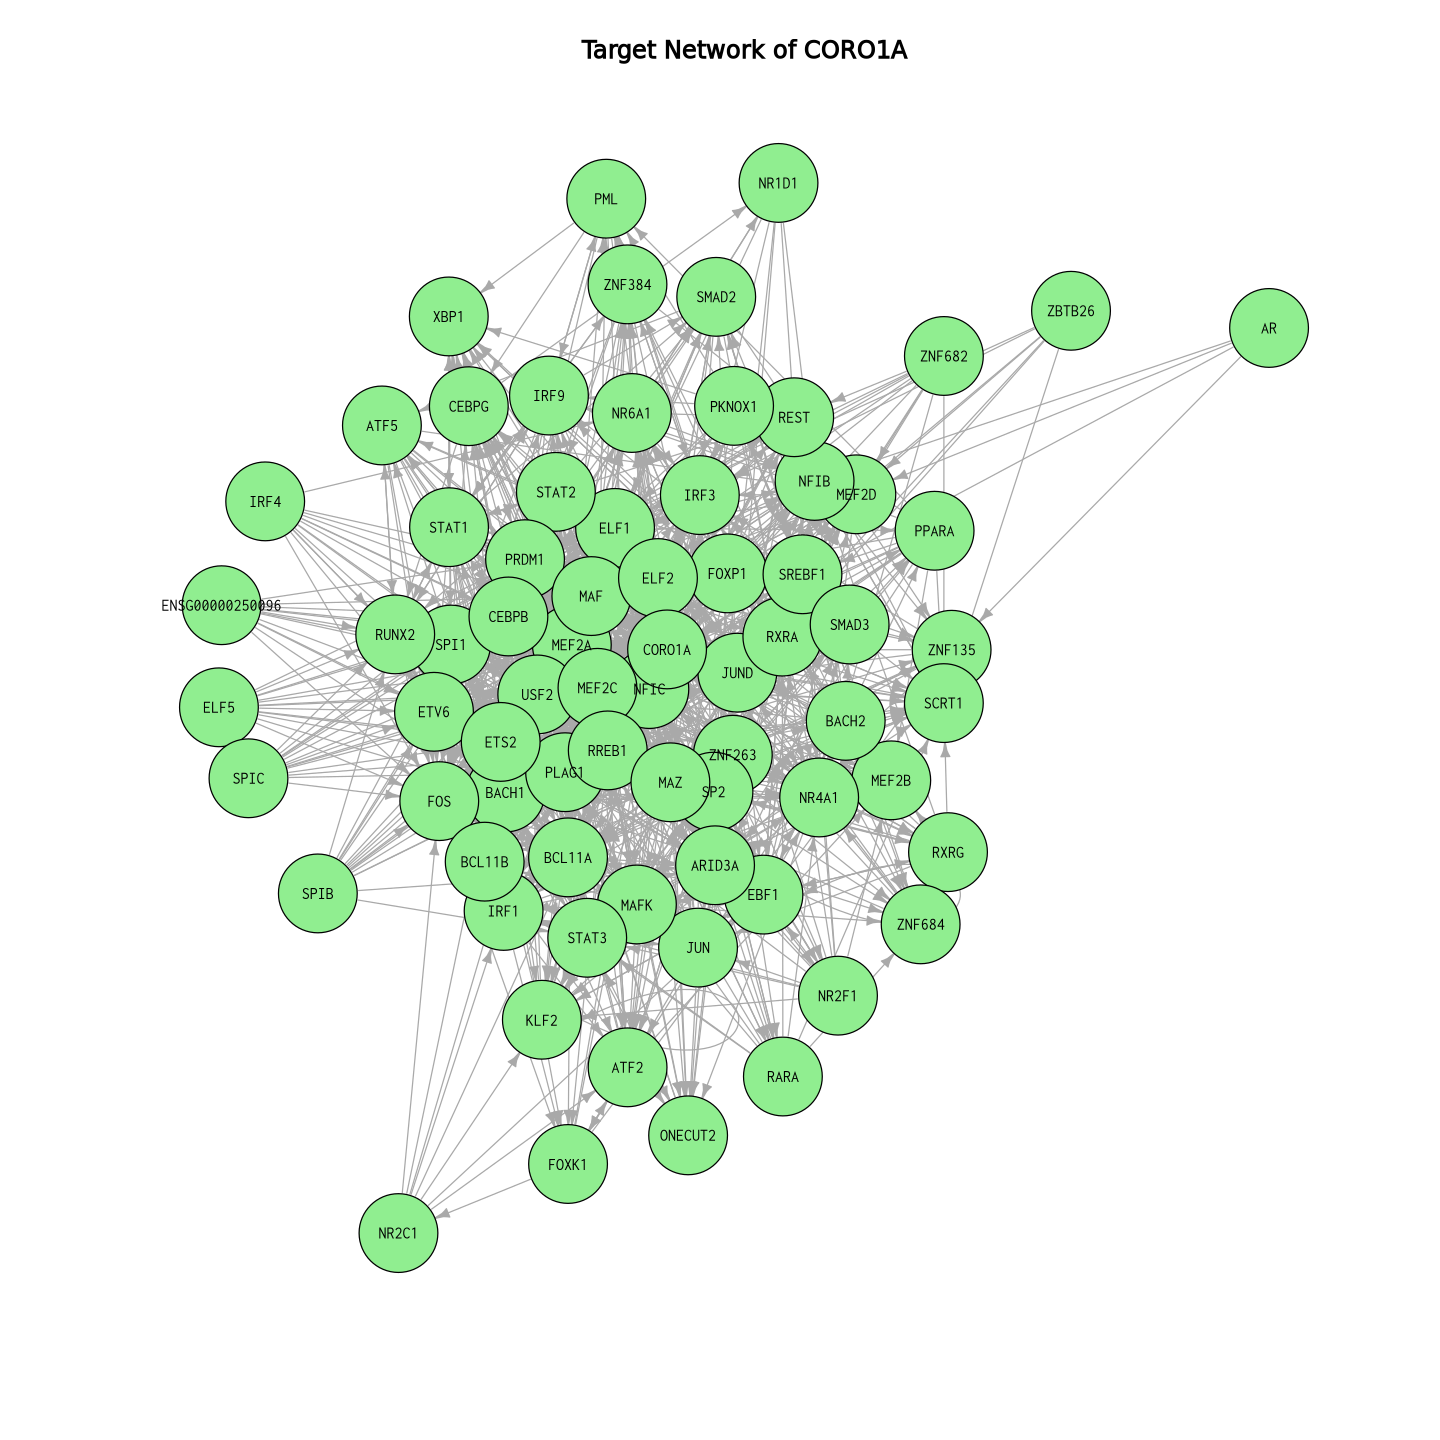

In [70]:

# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)
df <- readRDS('all_GRN.rds')
reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "CORO1A" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg <- induced_subgraph(g, neighbors_g)

plot(subg,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))
coro1a_genes <- names(neighbors_g)

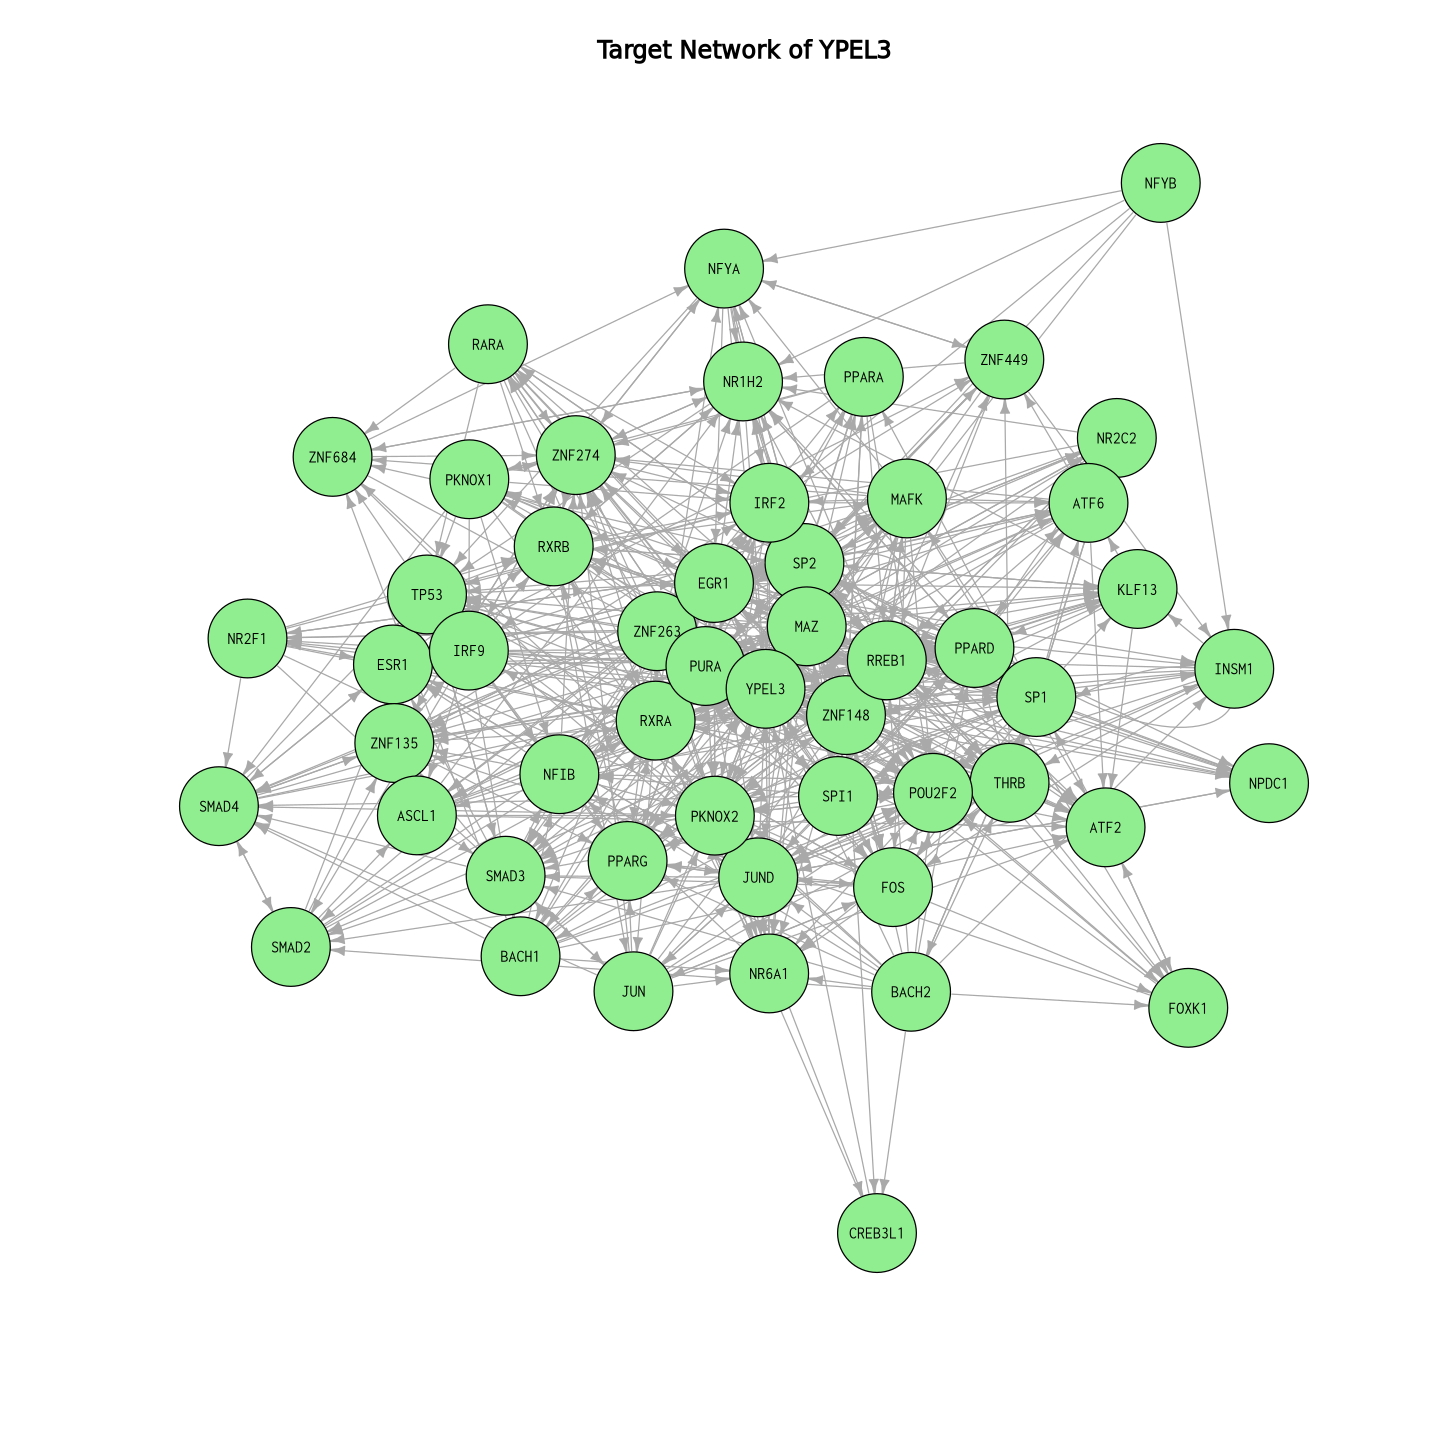

In [139]:

# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)

reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "YPEL3" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg <- induced_subgraph(g, neighbors_g)

plot(subg,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))
ypel3_genes <- names(neighbors_g)

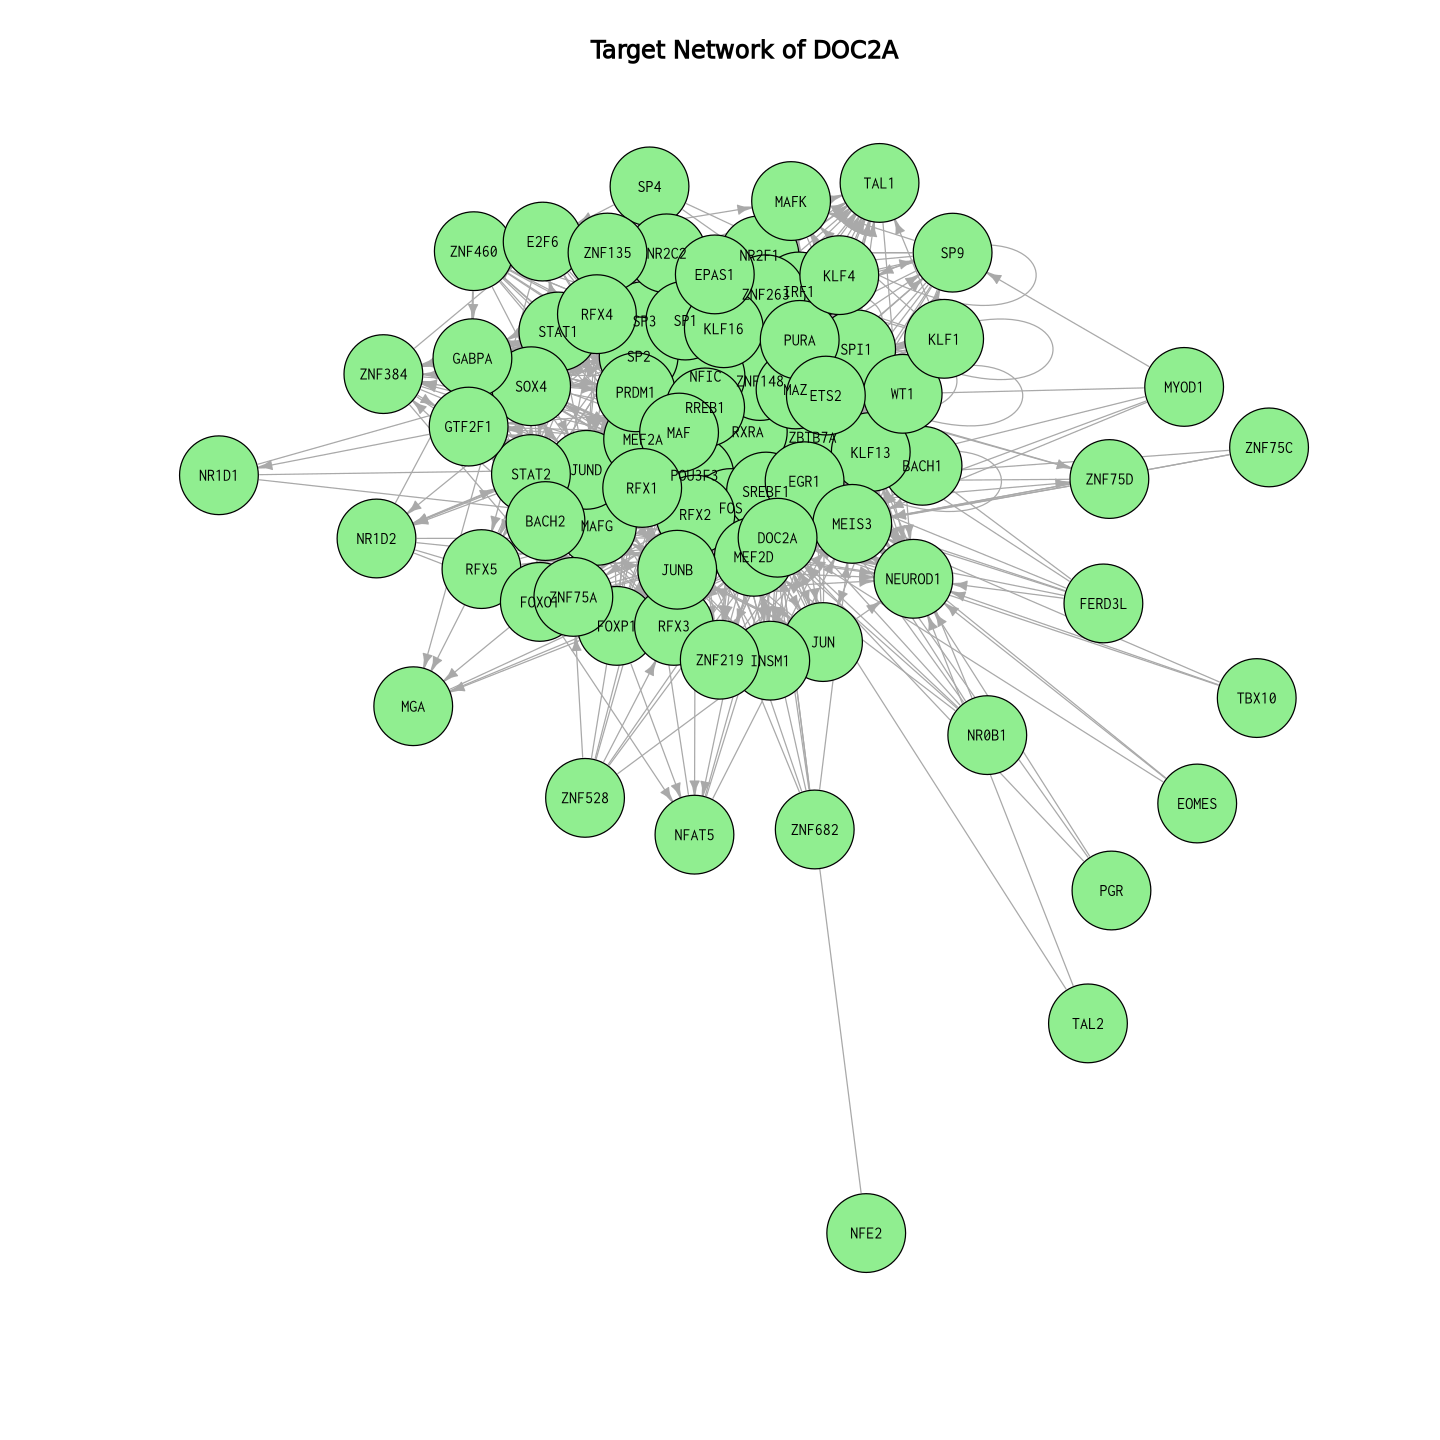

In [140]:

# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)

reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "DOC2A" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg <- induced_subgraph(g, neighbors_g)

plot(subg,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))

doc2a_genes <- names(neighbors_g)

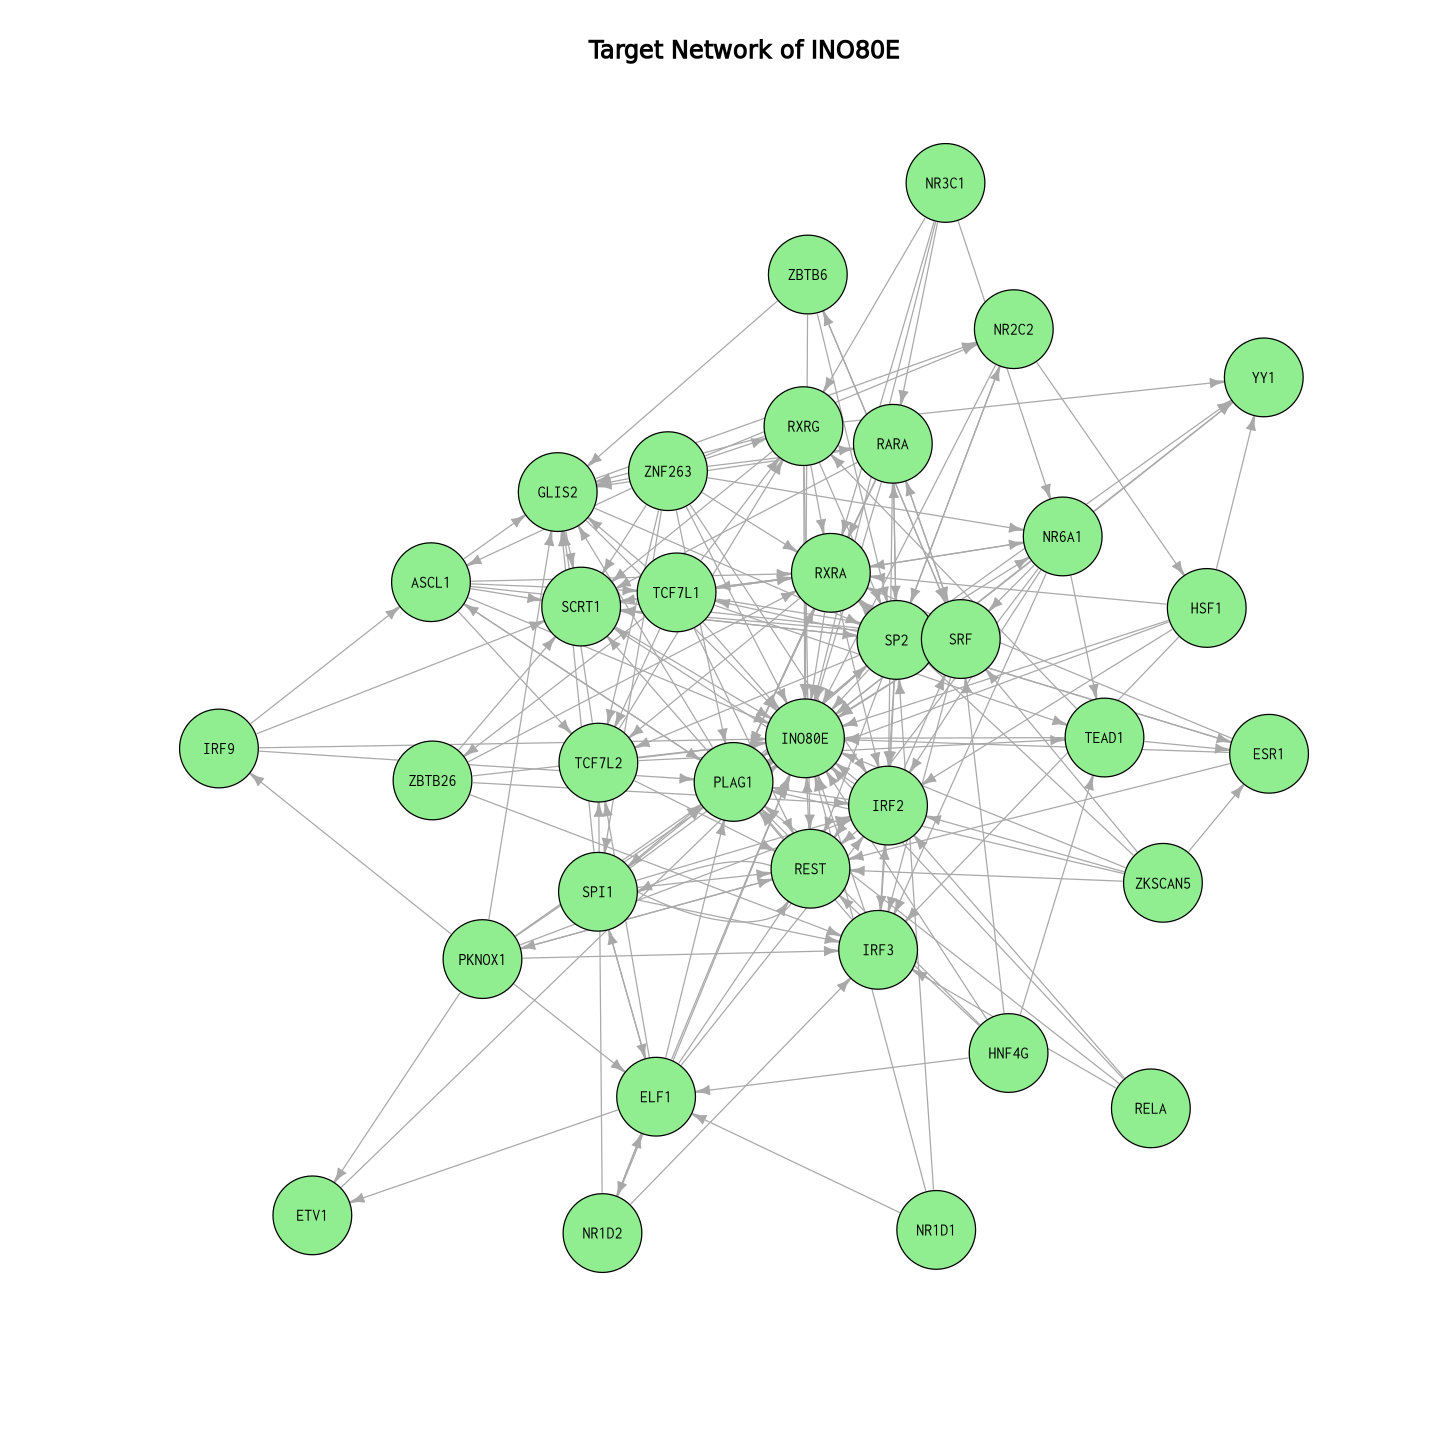

In [141]:

# grn <- read_tsv(reg_net_files[5], show_col_types = FALSE)

reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

focus_gene <- "INO80E" 
neighbors_g <- ego(g, order = 1, nodes = focus_gene, mode = "in")[[1]]
subg <- induced_subgraph(g, neighbors_g)

plot(subg,
     vertex.label.cex = 0.8,
     vertex.label.color = "black",
     vertex.color = "lightgreen",
     edge.arrow.size = 0.3,
     layout = layout_with_fr,
     main = paste("Target Network of", focus_gene))

ino80e_genes <- names(neighbors_g)

In [176]:
multi_gene_list %>% length
valid_genes %>% length
V(g)$name %>% length

[1] 12

[1] 2

[1] 14484

In [211]:
multi_gene_list

[1] "YPEL3"      "INO80E"     "DOC2A"      "MAPK3"      "CORO1A"    
 [6] "BCKDK"      "TLCD3B"     "ZNF267"     "AC093512.2" "PRSS8"     
[11] "TAOK2"      "TMEM219"

In [181]:
# multi_gene_list_name <- gene_ref %>% filter(gene_id %in% multi_gene_list) %>% pull(gene_name)
multi_gene_list_name <- multi_gene_list
valid_genes <- multi_gene_list_name[multi_gene_list_name %in% V(g)$name]

tf_genes <- list()
for (gene in valid_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  tf_genes[[gene]] <- setdiff(names(neighbors_g), gene)
}

In [183]:
tf_genes

$YPEL3
 [1] "NR2F1"   "ESR1"    "CREB3L1" "JUN"     "ATF2"    "JUND"    "BACH1"  
 [8] "RXRA"    "THRB"    "ZNF148"  "MAFK"    "TP53"    "PPARD"   "FOXK1"  
[15] "ZNF263"  "NFYB"    "SP2"     "FOS"     "RARA"    "BACH2"   "RREB1"  
[22] "IRF2"    "SPI1"    "NR2C2"   "KLF13"   "NR1H2"   "RXRB"    "ZNF135" 
[29] "PPARA"   "EGR1"    "NFIB"    "PKNOX2"  "NR6A1"   "PKNOX1"  "ASCL1"  
[36] "PPARG"   "SMAD3"   "ZNF684"  "NFYA"    "SMAD2"   "SMAD4"   "SP1"    
[43] "MAZ"     "IRF9"    "POU2F2"  "ZNF274"  "ATF6"    "ZNF449"  "INSM1"  
[50] "PURA"    "NPDC1"  

$INO80E
 [1] "RXRG"    "ESR1"    "ELF1"    "RXRA"    "TEAD1"   "PLAG1"   "ZBTB26" 
 [8] "ZNF263"  "TCF7L1"  "ZBTB6"   "TCF7L2"  "SP2"     "NR1D1"   "RARA"   
[15] "HNF4G"   "NR1D2"   "IRF3"    "IRF2"    "SPI1"    "NR2C2"   "NR3C1"  
[22] "REST"    "YY1"     "NR6A1"   "PKNOX1"  "ASCL1"   "ZKSCAN5" "HSF1"   
[29] "IRF9"    "SCRT1"   "ETV1"    "SRF"     "GLIS2"   "RELA"   

$DOC2A
 [1] "NR2F1"   "IRF1"    "ZBTB7A"  "ZNF528"  "JUN"     "SP3"     "MAFG"   
 [8] "JUND"    "BACH1"   "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "RFX5"   
[15] "POU3F3"  "ZNF148"  "RFX3"    "STAT2"   "NFIC"    "MAFK"    "SP4"    
[22] "ZNF460"  "SOX4"    "ZNF384"  "E2F6"    "ZNF263"  "SP2"     "ZNF682" 
[29] "FOS"     "PRDM1"   "SREBF1"  "NR1D1"   "RFX2"    "NR1D2"   "BACH2"  
[36] "RREB1"   "SPI1"    "NR2C2"   "KLF13"   "MEF2D"   "ZNF135"  "EGR1"   
[43] "MAF"     "GABPA"   "SP1"     "MAZ"     "JUNB"    "RFX4"    "KLF16"  
[50] "RFX1"    "NEUROD1" "SP9"     "ZNF75D"  "INSM1"   "FOXO1"   "MGA"    
[57] "ZNF75A"  "WT1"     "PURA"    "NR0B1"   "KLF4"    "MEIS3"   "MYOD1"  
[64] "FERD3L"  "TAL1"    "TAL2"    "NFE2"    "ZNF219"  "KLF1"    "GTF2F1" 
[71] "ETS2"    "EPAS1"   "EOMES"   "PGR"     "NFAT5"   "TBX10"   "ZNF75C" 

$MAPK3
 [1] "RXRG"    "NR2F1"   "IRF1"    "KLF15"   "JUN"     "MAFG"    "CEBPG"  
 [8] "ATF4"    "STAT1"   "FOXP1"   "RXRA"    "MEF2A"   "USF2"    "THRB"   
[15] "PBX3"    "NFIC"    "SP4"     "ZNF460"  "ZNF384"  "E2F6"    "ZNF263" 
[22] "SP2"     "MEF2C"   "PRDM1"   "RARG"    "RARA"    "IRF3"    "SPI1"   
[29] "KLF13"   "MEF2D"   "RXRB"    "EGR1"    "NR3C1"   "NFIB"    "PKNOX2" 
[36] "SMAD3"   "SMAD2"   "CEBPA"   "ZNF382"  "SP1"     "MAZ"     "RARB"   
[43] "MITF"    "BHLHE41" "USF1"    "CEBPD"   "ELF2"    "RELA"    "ETV6"   
[50] "ZNF76"   "RUNX1"   "ETS2"    "ELF5"    "SPIB"    "ZNF683"  "ATF5"   
[57] "SPIC"   

$CORO1A
 [1] "RXRG"            "NR2F1"           "IRF1"            "ELF1"           
 [5] "ONECUT2"         "JUN"             "ATF2"            "JUND"           
 [9] "CEBPG"           "BACH1"           "STAT1"           "FOXP1"          
[13] "RXRA"            "MEF2A"           "USF2"            "STAT2"          
[17] "NFIC"            "EBF1"            "MAFK"            "PLAG1"          
[21] "MEF2B"           "FOXK1"           "ZBTB26"          "ZNF384"         
[25] "ZNF263"          "SP2"             "ZNF682"          "XBP1"           
[29] "FOS"             "MEF2C"           "PRDM1"           "SREBF1"         
[33] "NR1D1"           "RARA"            "BACH2"           "IRF3"           
[37] "RREB1"           "SPI1"            "MEF2D"           "ZNF135"         
[41] "PPARA"           "NFIB"            "REST"            "AR"             
[45] "NR6A1"           "MAF"             "PKNOX1"          "SMAD3"          
[49] "ZNF684"          "RUNX2"           "SMAD2"           "MAZ"            
[53] "IRF9"            "SCRT1"           "NR4A1"           "ELF2"           
[57] "STAT3"           "ETV6"            "CEBPB"           "PML"            
[61] "BCL11A"          "NR2C1"           "ETS2"            "KLF2"           
[65] "ELF5"            "ARID3A"          "SPIB"            "BCL11B"         
[69] "ENSG00000250096" "IRF4"            "ATF5"            "SPIC"           

$BCKDK
[1] "ZNF148" "MAZ"    "PURA"  

$ZNF267
 [1] "IRF1"   "ESR1"   "STAT1"  "MZF1"   "SP4"    "SP2"    "PRDM1"  "RREB1" 
 [9] "IRF2"   "NFIB"   "YY1"    "SMAD2"  "IKZF1"  "ZNF75D" "PML"    "ETV3"  
[17] "REL"   

$

In [184]:
tf_genes$YPEL3 %>% .[. %in% multi_gene_list]

character(0)

In [149]:
tf_genes$INO80E %>% .[ . %in% multi_gene_list]

character(0)

In [150]:
tf_genes$DOC2A %>% .[. %in% multi_gene_list]

character(0)

In [151]:
tf_genes$MAPK3 %>% .[. %in% multi_gene_list]

character(0)

In [152]:
tf_genes$CORO1A %>% .[. %in% multi_gene_list]

character(0)

In [172]:
library(UpSetR)

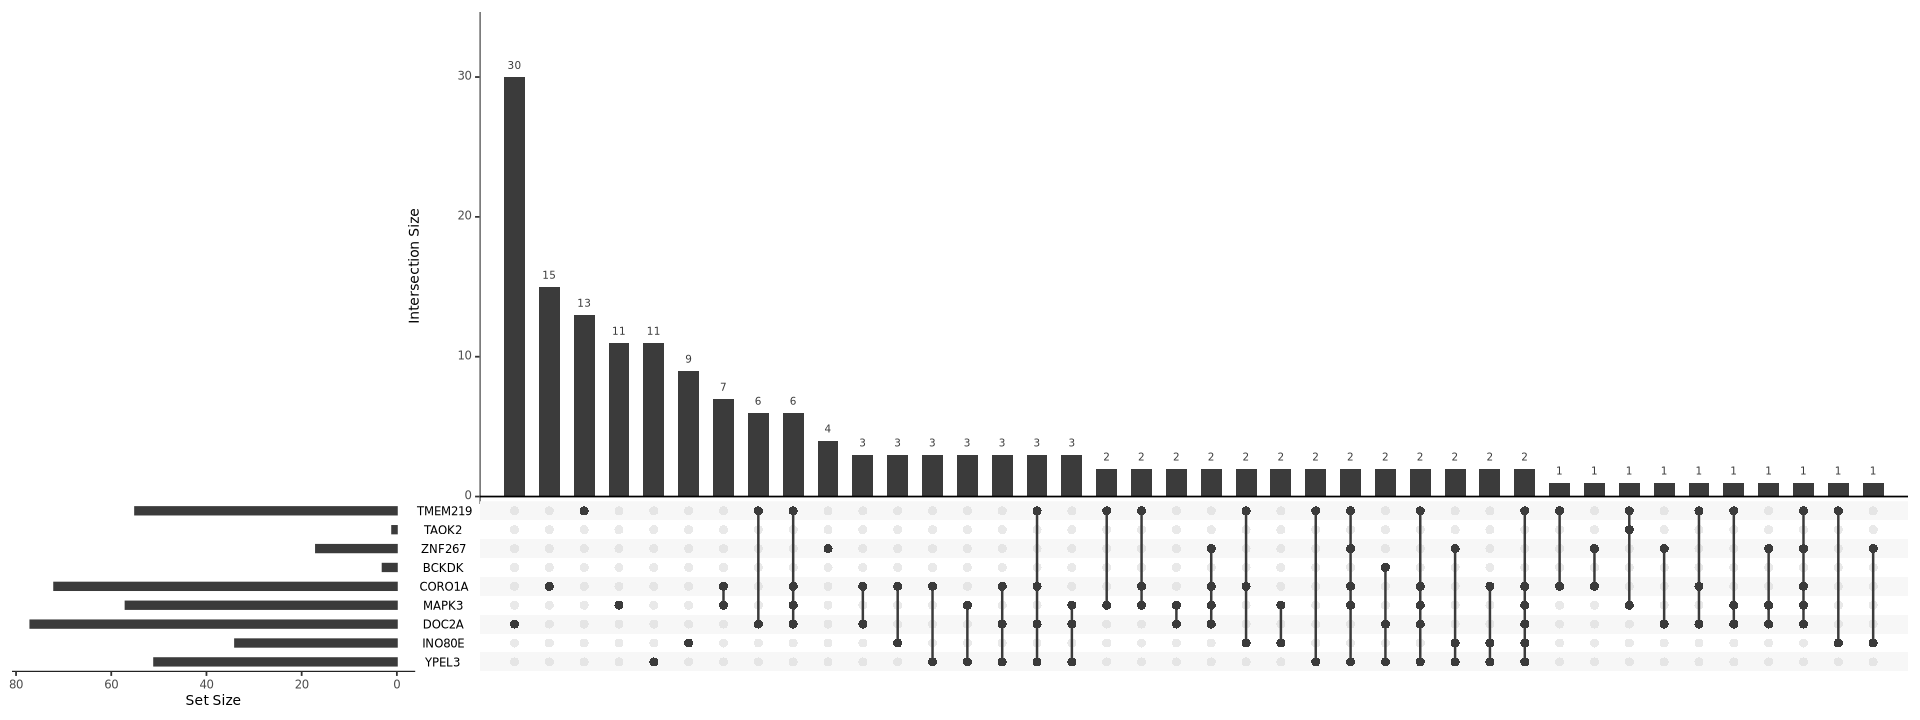

In [186]:
# Convert list to binary presence/absence data frame
gene_matrix <- fromList(tf_genes)

# Create the UpSet plot
upset(gene_matrix, sets = names(tf_genes), keep.order = TRUE, order.by = "freq")

In [195]:
tf_genes %>% str

List of 9
 $ YPEL3  : chr [1:51] "NR2F1" "ESR1" "CREB3L1" "JUN" ...
 $ INO80E : chr [1:34] "RXRG" "ESR1" "ELF1" "RXRA" ...
 $ DOC2A  : chr [1:77] "NR2F1" "IRF1" "ZBTB7A" "ZNF528" ...
 $ MAPK3  : chr [1:57] "RXRG" "NR2F1" "IRF1" "KLF15" ...
 $ CORO1A : chr [1:72] "RXRG" "NR2F1" "IRF1" "ELF1" ...
 $ BCKDK  : chr [1:3] "ZNF148" "MAZ" "PURA"
 $ ZNF267 : chr [1:17] "IRF1" "ESR1" "STAT1" "MZF1" ...
 $ TAOK2  : chr "ATF4"
 $ TMEM219: chr [1:55] "NR2F1" "ELF1" "ONECUT2" "JUN" ...


[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"


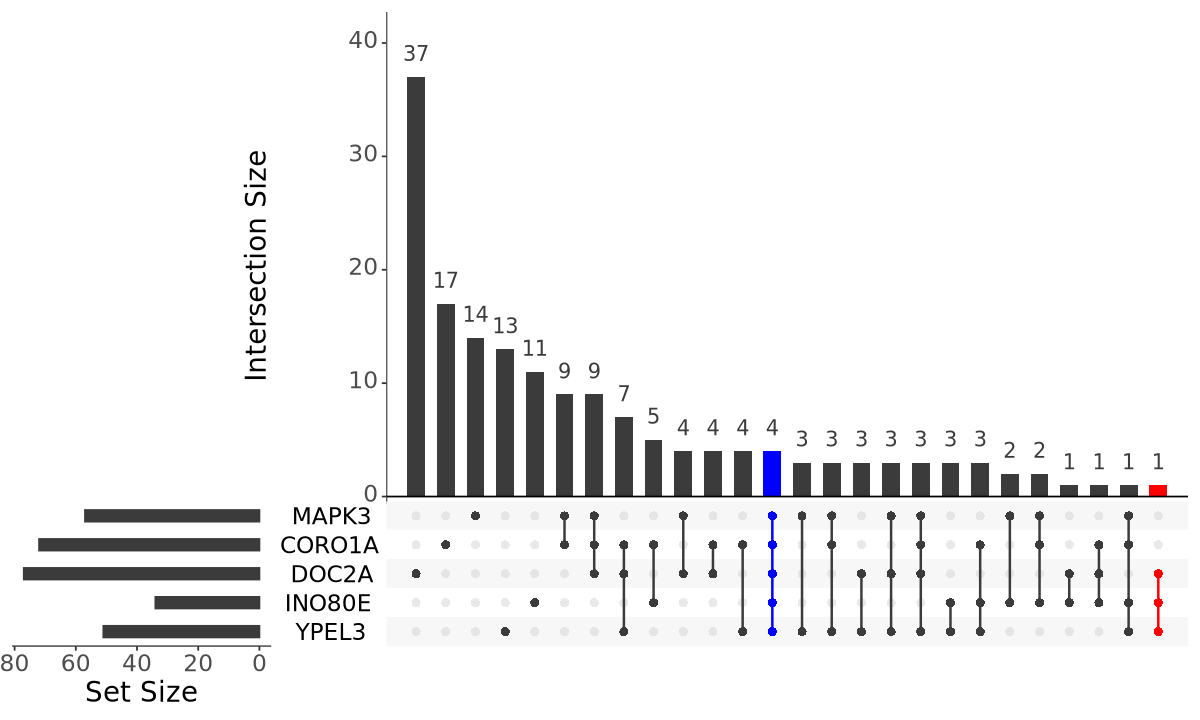

In [210]:
library(UpSetR)

# Build the binary matrix from tf_genes
all_tfs <- unique(unlist(tf_genes))
gene_matrix <- as.data.frame(
  sapply(tf_genes, function(gene_tfs) as.integer(all_tfs %in% gene_tfs))
)
rownames(gene_matrix) <- all_tfs

# Check column names
print(colnames(gene_matrix))  # Should include "YPEL3", "INO80E", "DOC2A"
options(repr.plot.width = 10, repr.plot.height = 6)

# Generate the UpSet plot with highlighted intersections
upset(
  gene_matrix,
  sets = c("YPEL3", "INO80E", "DOC2A", "CORO1A", "MAPK3"),
  keep.order = TRUE,
  order.by = "freq",
  queries = list(
    list(
      query = intersects,
      params = list("YPEL3", "INO80E", "DOC2A"),
      color = "red",
      active = TRUE,
      query.name = "Shared: YPEL3+INO80E+DOC2A"
    ),
    list(
      query = intersects,
      params = list("YPEL3", "INO80E", "DOC2A", "CORO1A", "MAPK3"),
      color = "blue",
      active = TRUE,
      query.name = "Shared: All Five Genes"
    )
  ),
  text.scale = 2
)

In [196]:
# Filter rows where all three genes are present (shared)
rownames(gene_matrix) <- unique(unlist(tf_genes))
shared_rows <- gene_matrix %>%
  filter(YPEL3 == 1, INO80E == 1, DOC2A == 1)
shared_rows

YPEL3 INO80E DOC2A MAPK3 CORO1A BCKDK ZNF267 TAOK2 TMEM219
RXRA   1     1      1     1     1      0     0      0     1      
ZNF263 1     1      1     1     1      0     0      0     1      
SP2    1     1      1     1     1      0     1      0     0      
SPI1   1     1      1     1     1      0     0      0     0      
NR2C2  1     1      1     0     0      0     0      0     0

In [187]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(9)])
names(tf_genes[-c(9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

character(0)

[1] "YPEL3"  "INO80E" "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"  "ZNF267" "TAOK2"

In [188]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2,8:9)])
names(tf_genes[-c(2,8:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

character(0)

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"  "ZNF267"

In [189]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2, 7:9)])
names(tf_genes[-c(2, 7:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "MAZ"

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A" "BCKDK"

In [190]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(2, 6:9)])
names(tf_genes[-c(2, 6:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "NR2F1"  "JUN"    "RXRA"   "ZNF263" "SP2"    "SPI1"   "MAZ"

[1] "YPEL3"  "DOC2A"  "MAPK3"  "CORO1A"

In [191]:
names(tf_genes)
Reduce(intersect, tf_genes[-c(1:2, 6:9)])
names(tf_genes[-c(1:2, 6:9)])

[1] "YPEL3"   "INO80E"  "DOC2A"   "MAPK3"   "CORO1A"  "BCKDK"   "ZNF267" 
[8] "TAOK2"   "TMEM219"

[1] "NR2F1"  "IRF1"   "JUN"    "STAT1"  "FOXP1"  "RXRA"   "MEF2A"  "NFIC"  
 [9] "ZNF384" "ZNF263" "SP2"    "PRDM1"  "SPI1"   "MEF2D"  "MAZ"    "ETS2"

[1] "DOC2A"  "MAPK3"  "CORO1A"

In [185]:
retest_genes <- Reduce(intersect, tf_genes[3:4])
retest_in_tf_genes <- list()
for (gene in retest_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  retest_in_tf_genes[[gene]] <- setdiff(names(neighbors_g), gene)
}
retest_in_tf_genes

$RXRA
  [1] "RXRG"            "NR2F1"           "ESR1"            "CREB3L1"        
  [5] "ZBTB7A"          "KLF15"           "SP3"             "NFE2L1"         
  [9] "MAFG"            "BACH1"           "USF2"            "SCRT2"          
 [13] "THRB"            "BCL6"            "POU3F3"          "ZNF148"         
 [17] "NFIC"            "MZF1"            "EBF1"            "PLAG1"          
 [21] "ZNF460"          "PPARD"           "ZBTB26"          "E2F6"           
 [25] "KLF9"            "ZNF263"          "TCF7L1"          "SP2"            
 [29] "XBP1"            "HSF4"            "RFX2"            "NFIX"           
 [33] "RARA"            "RREB1"           "NFE2L2"          "ESR2"           
 [37] "RXRB"            "PPARA"           "EGR1"            "NR3C1"          
 [41] "NR6A1"           "MAF"             "ASCL1"           "ZKSCAN5"        
 [45] "PPARG"           "GABPA"           "SMAD2"           "SMAD4"          
 [49] "NFKB1"           "SP1"             "MAZ"             "HSF1"           
 [53] "CREB3"           "GLIS3"           "HSF2"            "SCRT1"          
 [57] "ZNF740"          "KLF16"           "ATF6"            "ZNF16"          
 [61] "NEUROD1"         "SOX2"            "ZNF449"          "KLF5"           
 [65] "INSM1"           "TCF12"           "SMAD5"           "KLF6"           
 [69] "ZNF281"          "MXD4"            "TFCP2L1"         "PLAGL1"         
 [73] "ZFY"             "MSX2"            "BSX"             "LHX9"           
 [77] "PRRX2"           "SHOX2"           "RAX2"            "ISX"            
 [81] "SHOX"            "ZFX"             "DLX3"            "DLX2"           
 [85] "TFAP2C"          "EN1"             "ENSG00000229544" "GBX1"           
 [89] "RFX7"            "PATZ1"           "HOXA4"           "PRRX1"          
 [93] "WT1"             "PURA"            "ZNF350"          "MECP2"          
 [97] "TFAP2B"          "SMAD1"           "KLF4"            "DLX4"           
[101] "MYOG"            "ASCL2"           "MYF5"            "LMO2"           
[105] "MAFA"            "NHLH2"           "NHLH1"           "LYL1"           
[109] "CTCFL"           "KLF1"            "UBTF"            "SP6"            
[113] "SP5"             "ZIC4"            "TFAP2D"          "PTF1A"          

$ZNF263
[1] "ELK4"   "TBP"    "GMEB2"  "ARID3A"

$SP2
 [1] "RXRG"   "NR2F1"  "ESR1"   "ZNF24"  "ATF2"   "STAT1"  "FOXP1"  "MEF2A" 
 [9] "THRB"   "PBX3"   "ZNF148" "ZIC1"   "EBF1"   "PLAG1"  "SP4"    "CTCF"  
[17] "ZNF460" "SOX4"   "PPARD"  "ZBTB6"  "NFYB"   "MEF2C"  "ZNF282" "NR1D1" 
[25] "RARA"   "NR2C2"  "KLF13"  "NR1H2"  "RXRB"   "EGR1"   "PPARG"  "NFYA"  
[33] "SP1"    "MAZ"    "SCRT1"  "GLIS2"  "PAX6"   "MTF1"   "IKZF1"  "ZNF449"
[41] "ZBTB17"

$NR1D1
[1] "CEBPG"  "CEBPB"  "HCFC1"  "GTF2F1"

$NR1D2
[1] "ELF1"    "SP3"     "MEF2A"   "ZNF148"  "RREB1"   "POU2F2"  "TFEC"   
[8] "SMARCC2"

$SPI1
 [1] "IRF1"   "ELF1"   "ZBTB7A" "SP3"    "CREM"   "STAT1"  "FOXP1"  "PBX3"  
 [9] "ZNF148" "MZF1"   "MAFK"   "ZNF263" "SP2"    "TCF4"   "PRDM1"  "RUNX2" 
[17] "SP1"    "MAZ"    "MITF"   "KLF16"  "KLF5"   "INSM1"  "KLF6"   "ZNF281"
[25] "ZFY"    "ZFX"    "PATZ1"  "PURA"   "KLF4"   "BCL11A" "RUNX1"  "KLF1"  
[33] "ETS2"   "KLF7"   "SP6"    "KLF2"   "TFAP2D" "REL"    "SPIB"   "BCL11B"
[41] "SPIC"   "NR2E1"  "MYCL1" 

$NR2C2
 [1] "ZNF148"  "ZNF263"  "SP2"     "RREB1"   "SP1"     "MAZ"     "KLF16"  
 [8] "GLIS2"   "SOX2"    "SP9"     "KLF5"    "ZNF281"  "FOXO1"   "ZFX"    
[15] "PATZ1"   "PURA"    "SMAD1"   "RAD21"   "LMO2"    "SP8"     "SP7"    
[22] "GTF2F1"  "SP6"     "SP5"     "CREB3L2" "SOX17"   "SOX18"

In [ ]:
retest_in_tf_genes$RXRA %>% .[. %in% retest_genes]

In [ ]:
retest_in_tf_genes$ZNF263 %>% .[ . %in% retest_genes]

In [ ]:
retest_in_tf_genes$SP2 %>% .[. %in% retest_genes]

In [ ]:
retest_in_tf_genes$SPI1 %>% .[. %in% retest_genes]

In [ ]:
retest_in_tf_genes$NR2C2 %>% .[. %in% retest_genes]

(ZNF263 + SP2) -> SPI1 + RXRA --> c('YPEL3', 'INO80E', 'DOC2A', 'MAPK3', 'CORO1A') ## seems 'BCKDK''ZNF267' are not in this bundle

NR2C2  <->  (ZNF263 + SP2) -> SPI1 + RXRA --> c('YPEL3', 'INO80E', 'DOC2A') ## seems 'BCKDK''ZNF267' are not in this bundle, and those three are closer to each other

In [275]:
library(igraph)
library(dplyr)

# Define all relevant nodes
focus_gene <- c("YPEL3", "INO80E", "DOC2A")
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)
# Extract subgraph with only those nodes
subg <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set edge colors to highlight direction (optional)
E(subg)$color <- "gray"
V(subg)$color <- ifelse(V(subg)$name %in% focus_gene, "red", "lightblue")

# Plot minimal network
pdf('./figs/GRN_YPEL3_INO80E_DOC2A.pdf', width = 5, height = 5, family = "sans")

plot(subg,
     vertex.label.cex = 1,
     vertex.label.family = "sans",  # Set label fontplot(subg,
     vertex.label.cex = 1,
     vertex.label.color = "black",
     vertex.color = V(subg)$color,
     vertex.size = 25,
     edge.arrow.size = 0.5,
     layout = layout_with_fr(subg),
     main = "Key Regulatory Pathway to YPEL3 / INO80E / DOC2A")
dev.off()

pdf 
  2

In [155]:
multi_gene_list

[1] "ENSG00000090238" "ENSG00000169592" "ENSG00000149927" "ENSG00000102879"
 [5] "ENSG00000149930" "ENSG00000149932" "ENSG00000102882" "ENSG00000103507"
 [9] "ENSG00000149926" "ENSG00000185947" "ENSG00000285043" "ENSG00000052344"

pdf 
  3

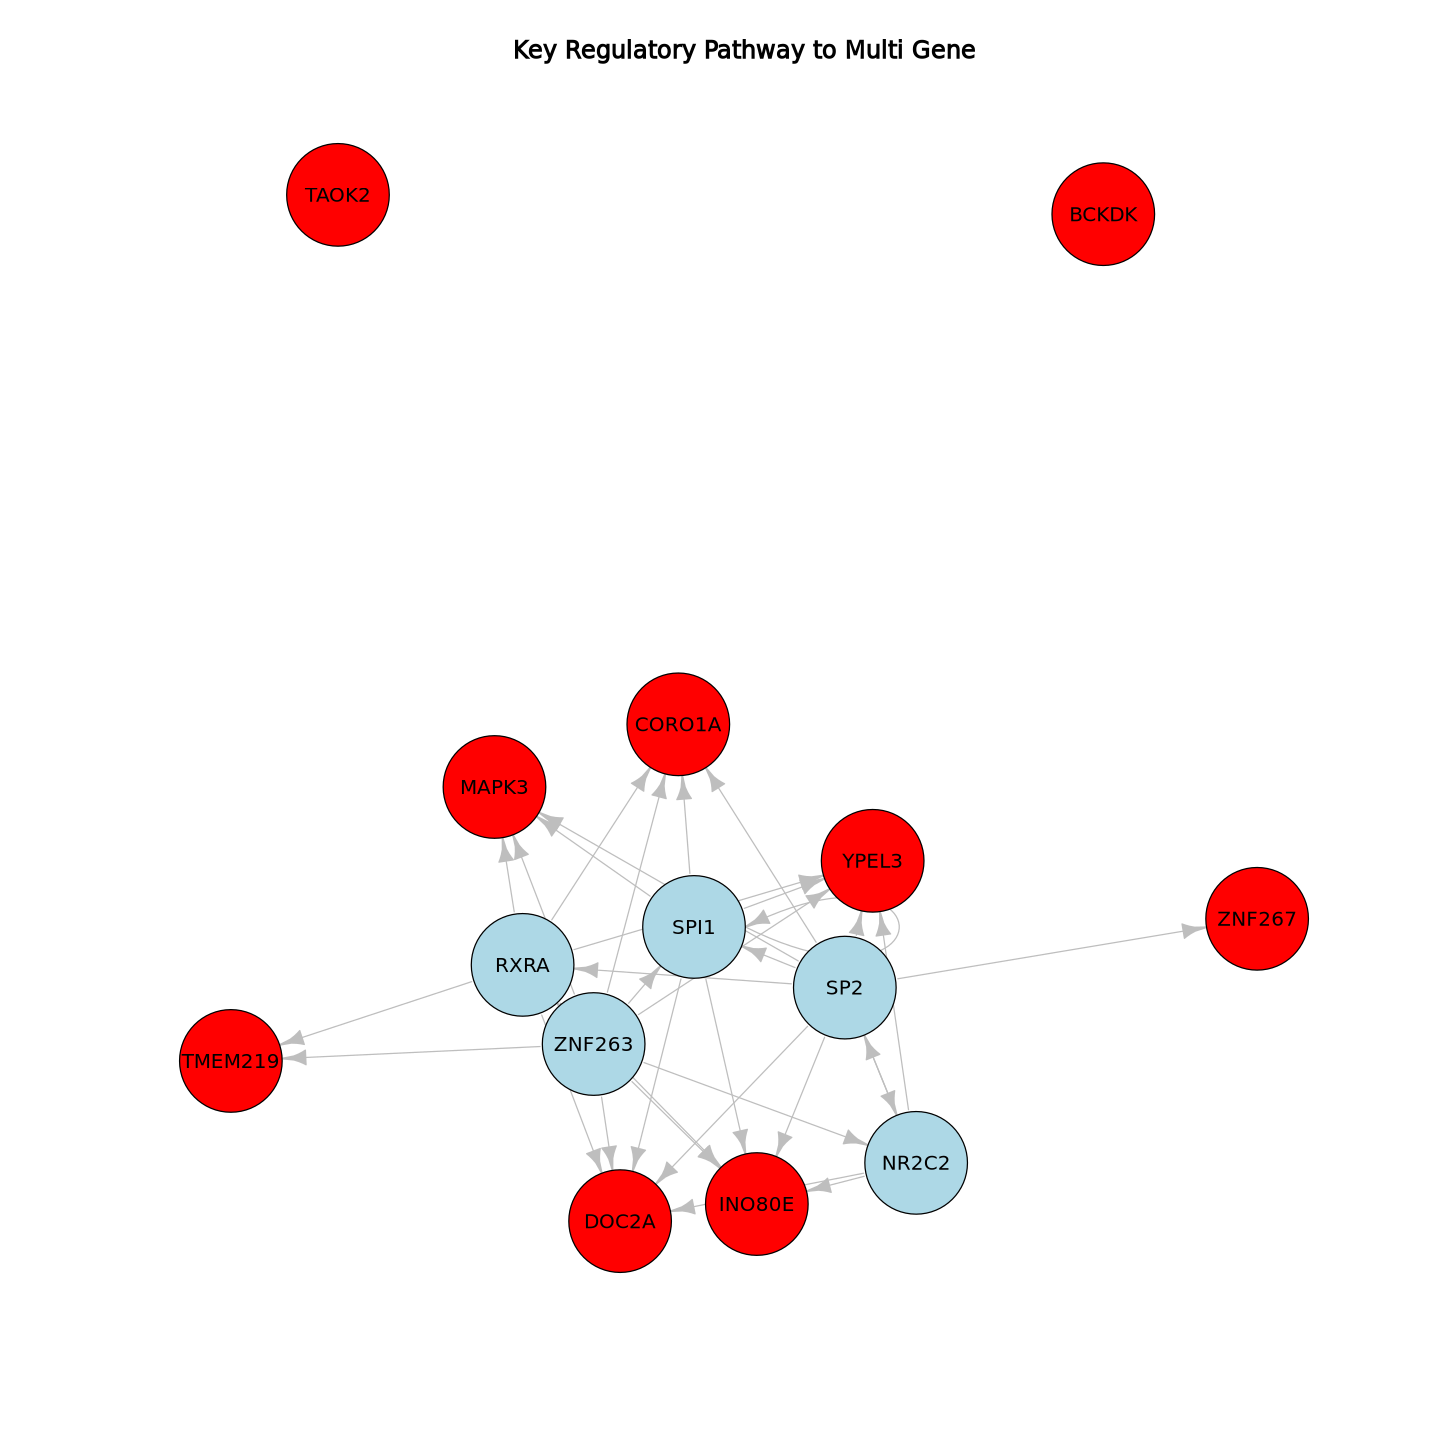

In [156]:
library(igraph)
library(dplyr)

# Define all relevant nodes
focus_gene <- multi_gene_list_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

reg_net <- df %>% dplyr::select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)
# Extract subgraph with only those nodes
subg <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set edge colors to highlight direction (optional)
E(subg)$color <- "gray"
V(subg)$color <- ifelse(V(subg)$name %in% focus_gene, "red", "lightblue")
# Use sans font (e.g., Arial) for cleaner output
# pdf('./figs/GRN_multigene.pdf', width = 10, height = 10, family = "sans")

plot(subg,
     vertex.label.cex = 1,
     vertex.label.family = "sans",  # Set label font
     vertex.label.color = "black",
     vertex.color = V(subg)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     layout = layout_with_fr(subg),
     main = "Key Regulatory Pathway to Multi Gene")

dev.off()

pdf 
  3

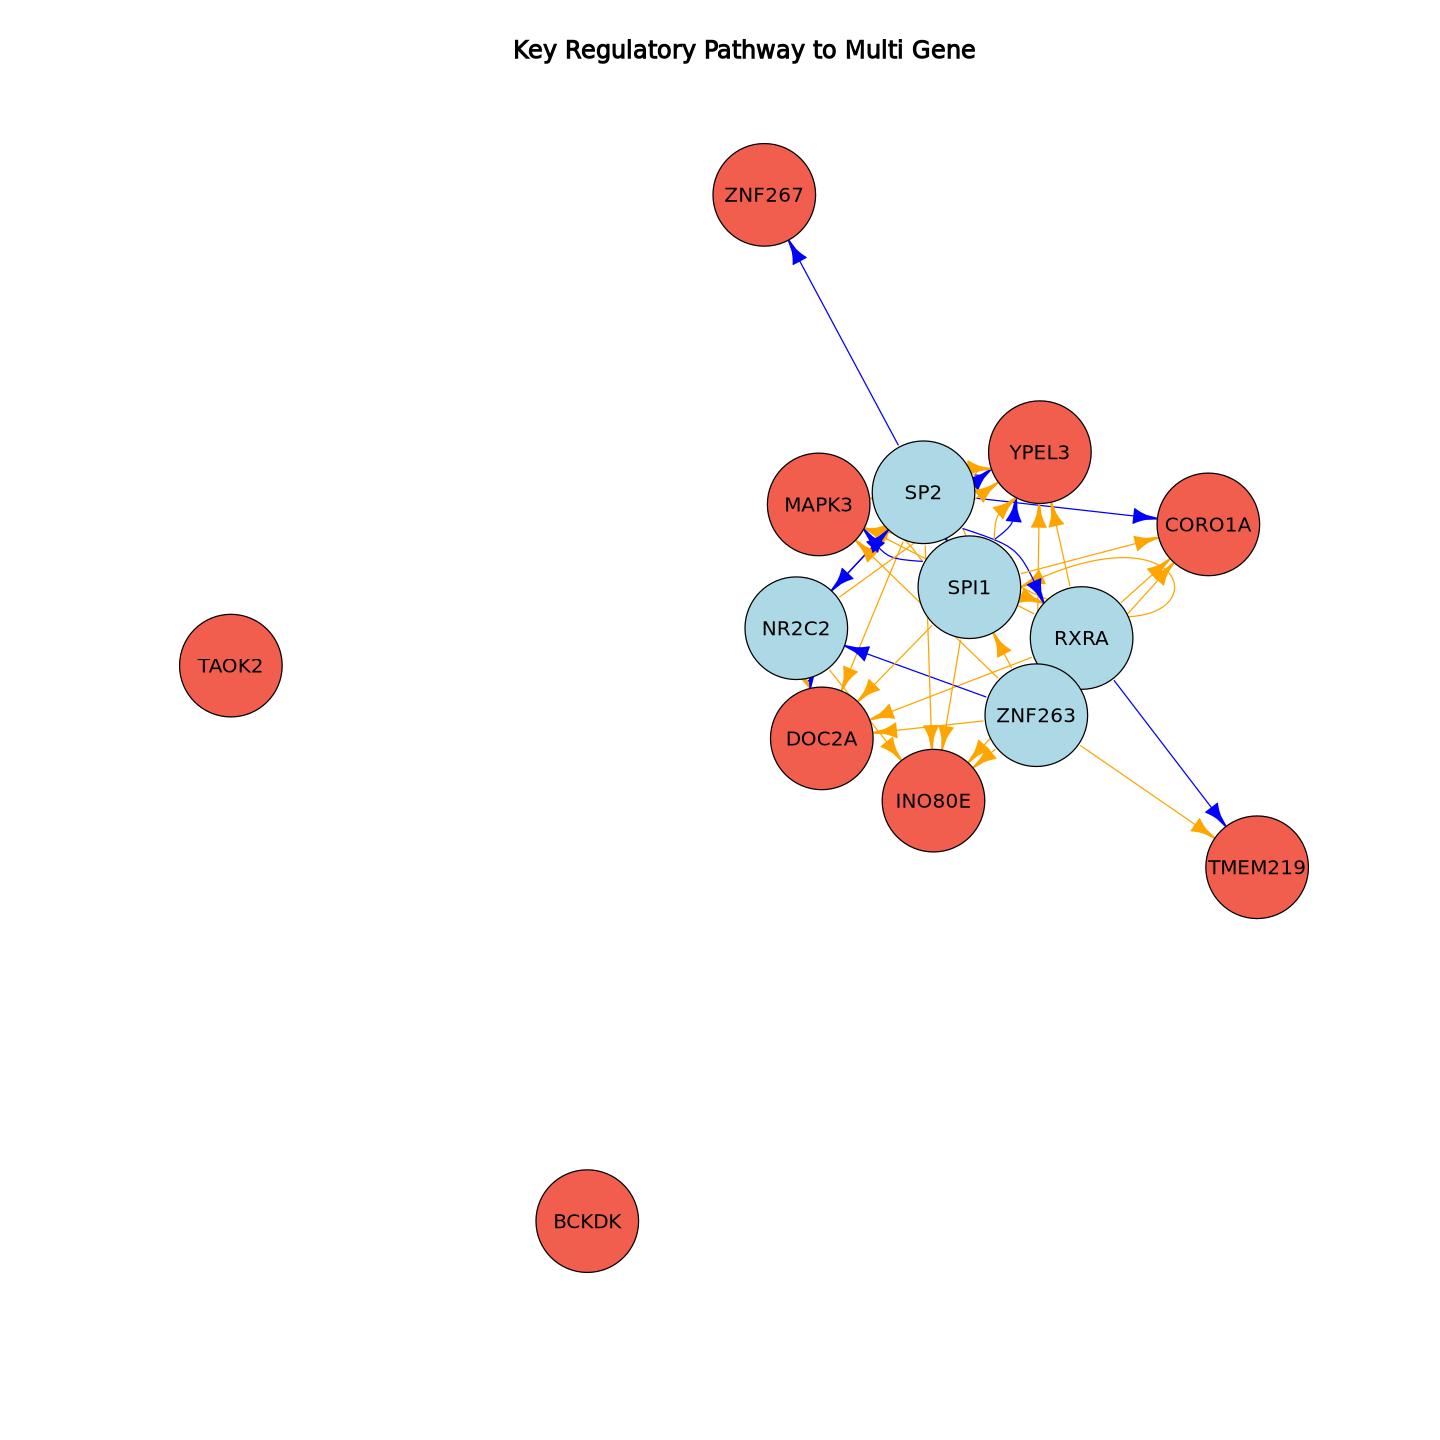

In [165]:
library(igraph)
library(dplyr)

# Define nodes of interest
focus_gene <- multi_gene_list_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

# Create full network with edge attributes
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Filter subgraph with selected nodes
subg <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set vertex color (focus genes in red)
V(subg)$color <- ifelse(V(subg)$name %in% focus_gene, '#F15E4E', "lightblue")

# Set edge color by regulation type
E(subg)$color <- ifelse(E(subg)$Regulation == "Repressing", "blue",
                        ifelse(E(subg)$Regulation == "Activating", "orange", "gray"))

# Optional: adjust edge width by weight or use dashed lines for repressors
# E(subg)$lty <- ifelse(E(subg)$Regulation == "Repressing", 2, 1)

# Plot the graph
# pdf('./figs/GRN_multigene.pdf', width = 9.5, height = 16, family = "sans")

plot(subg,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     edge.color = E(subg)$color,
     layout = layout_with_fr(subg),
     main = "Key Regulatory Pathway to Multi Gene")
dev.off()

In [137]:
gene_df <- fread('multi_gene_share_contexts.txt')

In [138]:
# Prepare graph
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Define genes of interest
focus_gene <- gene_df$gene_name
core_nodes <- c("NR2C2", "ZNF263", "SP2", "SPI1", "RXRA", focus_gene)

# Subgraph
subg <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

In [139]:
# Set vertex color
V(subg)$color <- ifelse(V(subg)$name %in% focus_gene, '#F15E4E', "lightblue")

# Match dot size to n_all or other column
gene_size_map <- gene_df %>% dplyr::select(gene_name, n_count_sQTL1) %>% deframe()

null device 
          1

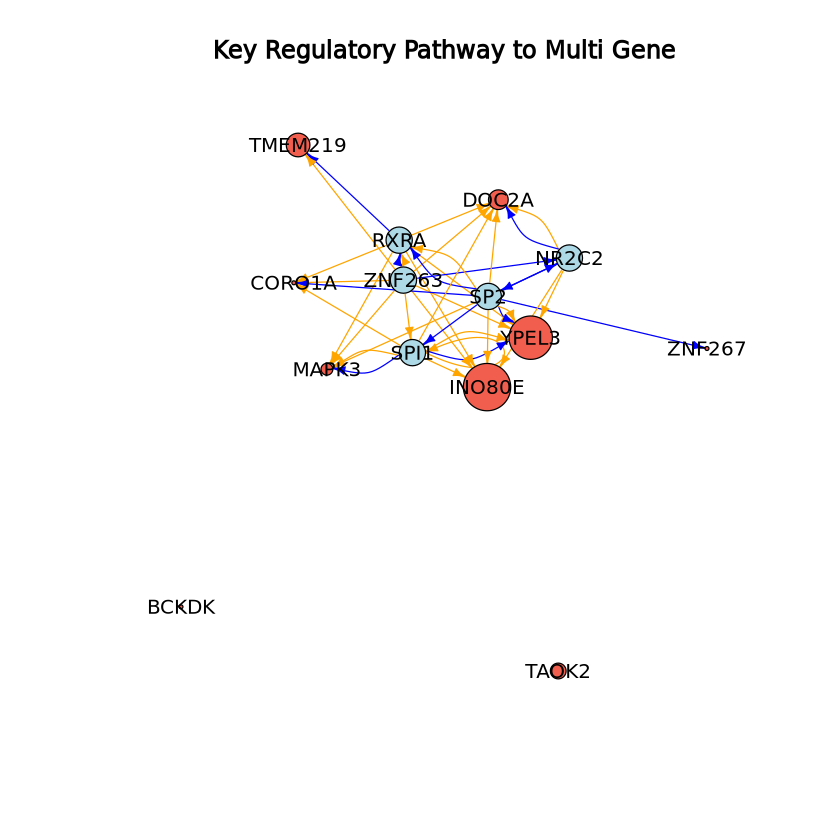

In [140]:
V(subg)$size <- ifelse(V(subg)$name %in% names(gene_size_map),
                       gene_size_map[V(subg)$name] * 1.5, 10)  # adjust scale as needed

# Edge color by regulation
E(subg)$color <- ifelse(E(subg)$Regulation == "Repressing", "blue",
                        ifelse(E(subg)$Regulation == "Activating", "orange", "gray"))

# Plot
# pdf('./figs/GRN_multigene.pdf', width = 10, height = 16, family = "sans")

plot(subg,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg)$color,
     vertex.size = V(subg)$size,
     edge.arrow.size = 0.5,
     edge.color = E(subg)$color,
     layout = layout_with_fr(subg),
     main = "Key Regulatory Pathway to Multi Gene")
dev.off()

In [141]:
cb <- fread('/data/analysis_result/ColocBoost/export/summary/ad_xqtl_colocboost_export_filtered.bed.gz')

In [144]:
cb %>% filter(gene_ID %in% gene_df$gene_ID)

#chr start    end      a1  a2  variant_ID         gene_ID        
1   16   29648903 29648905 C   T   chr16:29648905:T:C ENSG00000149930
2   16   29648903 29648905 C   T   chr16:29648905:T:C ENSG00000149932
3   16   29649894 29649896 T   C   chr16:29649896:C:T ENSG00000149930
4   16   29649894 29649896 T   C   chr16:29649896:C:T ENSG00000149932
5   16   29913099 29913101 T   A   chr16:29913101:A:T ENSG00000149932
6   16   29913099 29913101 T   A   chr16:29913101:A:T ENSG00000149932
7   16   29913582 29913584 G   A   chr16:29913584:A:G ENSG00000149932
8   16   29913582 29913584 G   A   chr16:29913584:A:G ENSG00000149932
9   16   29914122 29914124 T   C   chr16:29914124:C:T ENSG00000149932
10  16   29914122 29914124 T   C   chr16:29914124:C:T ENSG00000149932
11  16   29916379 29916381 A   G   chr16:29916381:G:A ENSG00000149932
12  16   29916379 29916381 A   G   chr16:29916381:G:A ENSG00000149932
13  16   29920741 29920743 T   C   chr16:29920743:C:T ENSG00000149932
14  16   29920741 29920743 T   C   chr16:29920743:C:T ENSG00000149932
15  16   29921368 29921370 C   T   chr16:29921370:T:C ENSG00000149932
16  16   29921368 29921370 C   T   chr16:29921370:T:C ENSG00000149932
17  16   29925331 29925333 G   A   chr16:29925333:A:G ENSG00000149932
18  16   29925331 29925333 G   A   chr16:29925333:A:G ENSG00000149932
19  16   29926329 29926331 A   G   chr16:29926331:G:A ENSG00000149932
20  16   29926329 29926331 A   G   chr16:29926331:G:A ENSG00000149932
21  16   29927497 29927499 G   A   chr16:29927499:A:G ENSG00000149932
22  16   29927497 29927499 G   A   chr16:29927499:A:G ENSG00000149932
23  16   29927970 29927972 C   T   chr16:29927972:T:C ENSG00000149932
24  16   29927970 29927972 C   T   chr16:29927972:T:C ENSG00000149932
25  16   29928554 29928556 G   A   chr16:29928556:A:G ENSG00000149932
26  16   29928554 29928556 G   A   chr16:29928556:A:G ENSG00000149932
27  16   29932044 29932046 C   T   chr16:29932046:T:C ENSG00000149932
28  16   29932044 29932046 C   T   chr16:29932046:T:C ENSG00000149932
29  16   29932136 29932138 A   C   chr16:29932138:C:A ENSG00000149932
30  16   29932136 29932138 A   C   chr16:29932138:C:A ENSG00000149932
... ...  ...      ...      ... ... ...                ...            
833 16   30102801 30102803 T   C   chr16:30102803:C:T ENSG00000090238
834 16   30102801 30102803 T   C   chr16:30102803:C:T ENSG00000090238
835 16   30102801 30102803 T   C   chr16:30102803:C:T ENSG00000102882
836 16   30102801 30102803 T   C   chr16:30102803:C:T ENSG00000103507
837 16   30102801 30102803 T   C   chr16:30102803:C:T ENSG00000169592
838 16   30105930 30105932 A   G   chr16:30105932:G:A ENSG00000149927
839 16   30105930 30105932 A   G   chr16:30105932:G:A ENSG00000169592
840 16   30105930 30105932 A   G   chr16:30105932:G:A ENSG00000185947
841 16   30107022 30107024 C   T   chr16:30107024:T:C ENSG00000102882
842 16   30107022 30107024 C   T   chr16:30107024:T:C ENSG00000103507
843 16   30107022 30107024 C   T   chr16:30107024:T:C ENSG00000149926
844 16   31106375 31106377 T   C   chr16:31106377:C:T ENSG00000052344
845 16   31111248 31111250 T   C   chr16:31111250:C:T ENSG00000052344
846 16   31111248 31111250 T   C   chr16:31111250:C:T ENSG00000052344
847 16   31114998 31115000 A   C   chr16:31115000:C:A ENSG00000052344
848 16   31114998 31115000 A   C   chr16:31115000:C:A ENSG00000052344
849 16   31120927 31120929 G   A   chr16:31120929:A:G ENSG00000052344
850 16   31120927 31120929 G   A   chr16:31120929:A:G ENSG00000052344
851 16   31121339 31121341 A   G   chr16:31121341:G:A ENSG00000052344
852 16   31121339 31121341 A   G   chr16:31121341:G:A ENSG00000052344
853 16   31121777 31121779 A   G   chr16:31121779:G:A ENSG00000052344
854 16   31121777 31121779 A   G   chr16:31121779:G:A ENSG00000052344
855 16   31122126 31122128 T   C   chr16:31122128:C:T ENSG00000052344
856 16   31122126 31122128 T   C   chr16:31122128:C:T ENSG00000052344
857 16   31122736 31122738 A   G   chr16:31122738:G:A ENSG00000052344
858 16   31122

### Multigene GRN - STX4

In [124]:
df <- readRDS('all_GRN.rds')
reg_net <- df %>% select(source = TF, target = TG) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)


multi_gene_list_name <- c('STX4', 'KAT8', 'PRSS36')
valid_genes <- multi_gene_list_name[multi_gene_list_name %in% V(g)$name]

tf_genes <- list()
for (gene in valid_genes) {
  neighbors_g <- ego(g, order = 1, nodes = gene, mode = "in")[[1]]
  tf_genes[[gene]] <- setdiff(names(neighbors_g), gene)
}

In [129]:
Reduce(intersect, tf_genes)

[1] "IRF1"   "ESR1"   "FOXP1"  "MEF2A"  "PBX3"   "MAFK"   "ZNF460" "MEF2C" 
 [9] "SREBF1" "RARG"   "ZNF140" "ZNF135" "PKNOX1" "ZNF740"

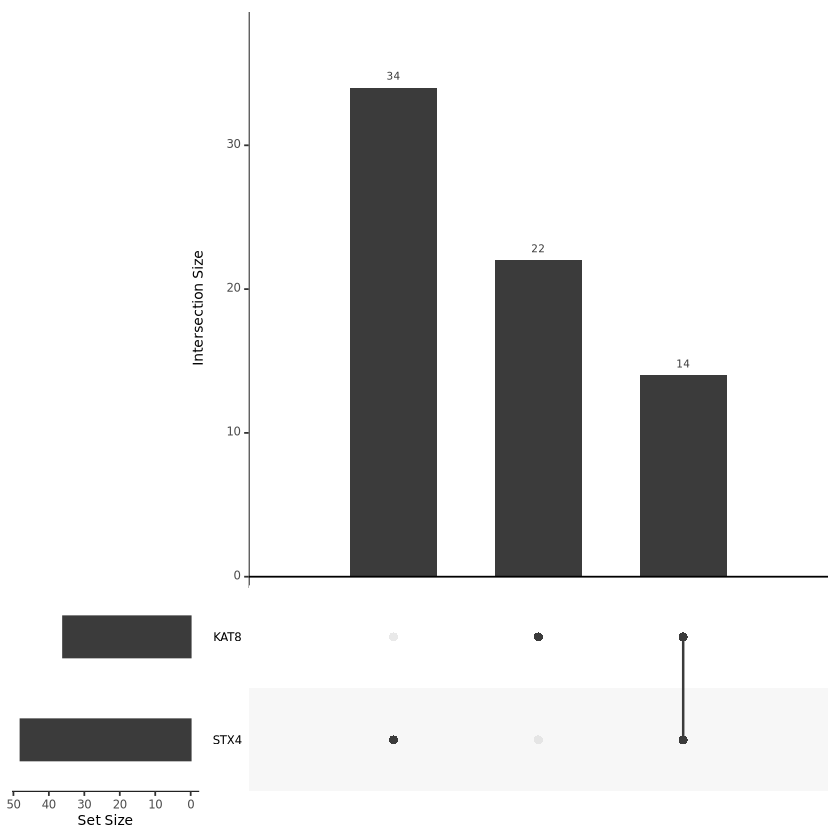

In [126]:
# Convert list to binary presence/absence data frame
gene_matrix <- fromList(tf_genes)

# Create the UpSet plot
upset(gene_matrix, sets = names(tf_genes), order.by = "freq")

null device 
          1

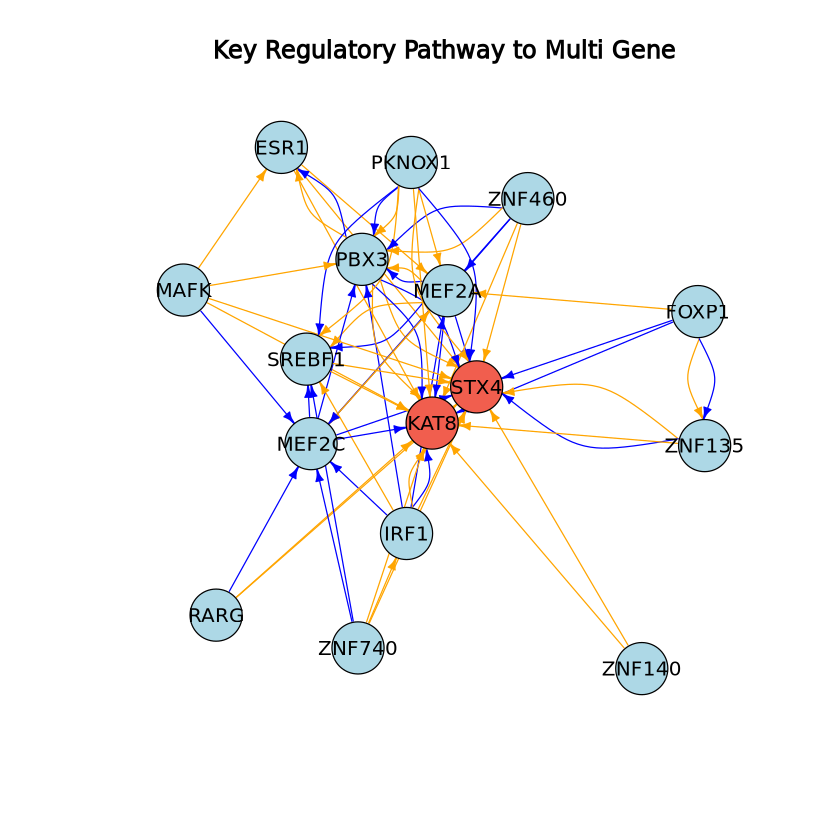

In [136]:
library(igraph)
library(dplyr)

# Define nodes of interest
focus_gene <- multi_gene_list_name
core_nodes <- c(Reduce(intersect, tf_genes), focus_gene)

# Create full network with edge attributes
reg_net <- df %>% dplyr::select(source = TF, target = TG, Regulation) %>% distinct()
g <- graph_from_data_frame(reg_net, directed = TRUE)

# Filter subgraph with selected nodes
subg <- induced_subgraph(g, vids = V(g)[name %in% core_nodes])

# Set vertex color (focus genes in red)
V(subg)$color <- ifelse(V(subg)$name %in% focus_gene, '#F15E4E', "lightblue")

# Set edge color by regulation type
E(subg)$color <- ifelse(E(subg)$Regulation == "Repressing", "blue",
                        ifelse(E(subg)$Regulation == "Activating", "orange", "gray"))

# Optional: adjust edge width by weight or use dashed lines for repressors
# E(subg)$lty <- ifelse(E(subg)$Regulation == "Repressing", 2, 1)

# Plot the graph
# pdf('./figs/GRN_multigene_STX4.pdf', width = 9.5, height = 16, family = "sans")

plot(subg,
     vertex.label.cex = 1,
     vertex.label.family = "sans",
     vertex.label.color = "black",
     vertex.color = V(subg)$color,
     vertex.size = 20,
     edge.arrow.size = 0.5,
     edge.color = E(subg)$color,
     layout = layout_with_fr(subg),
     main = "Key Regulatory Pathway to Multi Gene")
dev.off()

## Multi Gene trans function

In [8]:
progm1_all <- readLines('Top50_genes_Program1.txt')

In [65]:
progm1_all_bp_ego <- enrichGO(
  gene          = progm1_all,
  OrgDb         = org.Hs.eg.db,
  keyType       = "SYMBOL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [68]:
progm1_all_bp_ego %>% head

ID         Description                                    GeneRatio
GO:2001259 GO:2001259 positive regulation of cation channel activity 6/385    
GO:0006406 GO:0006406 mRNA export from nucleus                       7/385    
GO:0006405 GO:0006405 RNA export from nucleus                        8/385    
GO:0051168 GO:0051168 nuclear export                                 11/385   
GO:0006644 GO:0006644 phospholipid metabolic process                 18/385   
GO:0009060 GO:0009060 aerobic respiration                            12/385   
           BgRatio   pvalue       p.adjust  qvalue   
GO:2001259 49/18870  0.0004624001 0.3333622 0.3175203
GO:0006406 70/18870  0.0005534691 0.3333622 0.3175203
GO:0006405 92/18870  0.0005844065 0.3333622 0.3175203
GO:0051168 168/18870 0.0006858634 0.3333622 0.3175203
GO:0006644 375/18870 0.0007437289 0.3333622 0.3175203
GO:0009060 197/18870 0.0007552532 0.3333622 0.3175203
           geneID                                                                                                          
GO:2001259 CTSS/NIPSNAP2/CRACR2A/ANTKMT/STIMATE/SCN1B                                                                      
GO:0006406 HNRNPA2B1/THOC5/CHTOP/NSUN2/SUPT6H/UPF2/SMG7                                                                    
GO:0006405 HNRNPA2B1/THOC5/CHTOP/NSUN2/NOL6/SUPT6H/UPF2/SMG7                                                               
GO:0051168 STRADB/HNRNPA2B1/THOC5/CHTOP/NSUN2/NOL6/RITA1/SUPT6H/RANBP2/UPF2/SMG7                                           
GO:0006644 GPX4/PLCH2/PIGS/PLCB1/ETNK2/PROCA1/INPP5D/CEPT1/PGP/PIP4K2C/HMGCS1/FDPS/FDFT1/INPP5J/P3R3URF/PIK3R3/PTPMT1/ITPKA
GO:0009060 NIPSNAP2/ANTKMT/NDUFA9/NDUFA7/SDHAF2/UQCC3/ARL2/NDUFB9/NDUFS1/IDH3B/UQCRC1/ACO2                                 
           Count
GO:2001259  6   
GO:0006406  7   
GO:0006405  8   
GO:0051168 11   
GO:0006644 18   
GO:0009060 12

### program1 GO

#### split

In [69]:
progm1 <- fread('Top50_genes_Program1_split.txt')
progm1 %>% head

Mic_V1  Exc_V1  Inh_V1     Ast_V1  Oli_V1 OPC_V1 DLPFC_V1 AC_V1   PCC_V1
1 MAP2K2  ZBTB37  B3GNT5     ADCK5   UQCC3  RANBP2 BCKDK    ARHGEF1 FHAD1 
2 HLA-DMA SMIM12  AL162231.1 EIF5A   MAGEF1 BIN1   FBXO10   DTX3    TPM3  
3 CPLX1   TMED7   MTHFS      GNG3    FUCA1  TET3   COLQ     PENK    HERC2 
4 TTYH1   PGBD5   MCM7       BTN3A1  PRR7   KIF1A  ZFC3H1   COG1    FGF22 
5 KLHDC4  FAM229A RILPL2     SDHAF2  CMTM1  SAP18  TMEM151A QRICH1  CADPS2
6 TPGS2   FSCN1   FBXO21     ZFYVE19 GSTT2B GCFC2  PKD1L3   SLC26A2 PEX6

In [86]:
# Initialize empty data frame
progm1_df <- data.frame()

# Loop through each context (column) in progm1
for(context in colnames(progm1)){
    message(context)
  # Perform GO enrichment and store results with context label
  res <- enrichGO(
    gene          = progm1[[context]],  # use [[ ]] to access column by name
    OrgDb         = org.Hs.eg.db,
    keyType       = "SYMBOL",
    ont           = "ALL",
    pAdjustMethod = "BH",
    pvalueCutoff  = 1,
    qvalueCutoff  = 1
  ) %>% 
    as.data.frame() %>% 
    mutate(context = context)  # add context info
  
  # Append to cumulative results
  progm1_df <- rbind(progm1_df, res)
}

Mic_V1

Exc_V1

Inh_V1

Ast_V1

Oli_V1

OPC_V1

DLPFC_V1

AC_V1

PCC_V1



In [100]:
progm1_df %>% filter(qvalue < 0.05,ONTOLOGY == 'BP') %>% arrange(qvalue)


ONTOLOGY ID        
GO:00028241 BP       GO:0002824
GO:00028211 BP       GO:0002821
GO:0046037  BP       GO:0046037
GO:00067211 BP       GO:0006721
GO:00028222 BP       GO:0002822
GO:0001916  BP       GO:0001916
GO:00091671 BP       GO:0009167
GO:00028192 BP       GO:0002819
GO:00091261 BP       GO:0009126
GO:00466342 BP       GO:0046634
GO:0001914  BP       GO:0001914
GO:00027081 BP       GO:0002708
GO:0002420  BP       GO:0002420
GO:0002855  BP       GO:0002855
GO:00067201 BP       GO:0006720
GO:0002423  BP       GO:0002423
GO:1905165  BP       GO:1905165
GO:00091612 BP       GO:0009161
GO:0001913  BP       GO:0001913
GO:00066951 BP       GO:0006695
GO:19026531 BP       GO:1902653
GO:19026521 BP       GO:1902652
GO:00027052 BP       GO:0002705
GO:1904350  BP       GO:1904350
GO:00161261 BP       GO:0016126
GO:0001912  BP       GO:0001912
GO:00027111 BP       GO:0002711
GO:00466352 BP       GO:0046635
GO:0002836  BP       GO:0002836
GO:0002839  BP       GO:0002839
GO:0016114  BP       GO:0016114
GO:00508621 BP       GO:0050862
GO:0071468  BP       GO:0071468
GO:0031343  BP       GO:0031343
GO:00091232 BP       GO:0009123
GO:00466314 BP       GO:0046631
GO:00027063 BP       GO:0002706
GO:00508712 BP       GO:0050871
GO:0006144  BP       GO:0006144
GO:1905146  BP       GO:1905146
GO:0002837  BP       GO:0002837
GO:00028341 BP       GO:0002834
GO:0007039  BP       GO:0007039
GO:00019101 BP       GO:0001910
GO:00027091 BP       GO:0002709
GO:00060663 BP       GO:0006066
GO:00024604 BP       GO:0002460
GO:00508572 BP       GO:0050857
GO:0071467  BP       GO:0071467
GO:00026976 BP       GO:0002697
GO:0002418  BP       GO:0002418
GO:0008299  BP       GO:0008299
GO:00104471 BP       GO:0010447
GO:0045954  BP       GO:0045954
GO:00313411 BP       GO:0031341
GO:00027034 BP       GO:0002703
GO:0002717  BP       GO:0002717
GO:00603172 BP       GO:0060317
            Description                                                                                                                                     
GO:00028241 positive regulation of adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains
GO:00028211 positive regulation of adaptive immune response                                                                                                 
GO:0046037  GMP metabolic process                                                                                                                           
GO:00067211 terpenoid metabolic process                                                                                                                     
GO:00028222 regulation of adaptive immune response based on somatic recombination of immune receptors built from immunoglobulin superfamily domains         
GO:0001916  positive regulation of T cell mediated cytotoxicity                                                                                             
GO:00091671 purine ribonucleoside monophosphate metabolic process                                                                                           
GO:00028192 regulation of adaptive immune response                                                                                                          
GO:00091261 purine nucleoside monophosphate metabolic process                                                                                               
GO:00466342 regulation of alpha-beta T cell activation                                                                                                      
GO:0001914  regulation of T cell mediated cytotoxicity                                                                                                      
GO:00027081 positive regulation of lymphocyte mediated immunity                                                                                             
GO:0002420  natural killer cell mediated cytotoxicity directed against tumor cell t

In [147]:
progm1_df %>% filter(qvalue < 0.05,ONTOLOGY == 'MF') %>% arrange(qvalue)


ONTOLOGY ID         Description                GeneRatio BgRatio  
GO:19016813 MF       GO:1901681 sulfur compound binding    5/44      275/18496
GO:0004659  MF       GO:0004659 prenyltransferase activity 2/44      17/18496 
            pvalue       p.adjust   qvalue     geneID                       
GO:19016813 0.0004735447 0.06397159 0.04682736 COLQ/PRMT8/LRP1/ATP13A2/RTN4R
GO:0004659  0.0007353056 0.06397159 0.04682736 FDPS/FDFT1                   
            Count context 
GO:19016813 5     DLPFC_V1
GO:0004659  2     DLPFC_V1

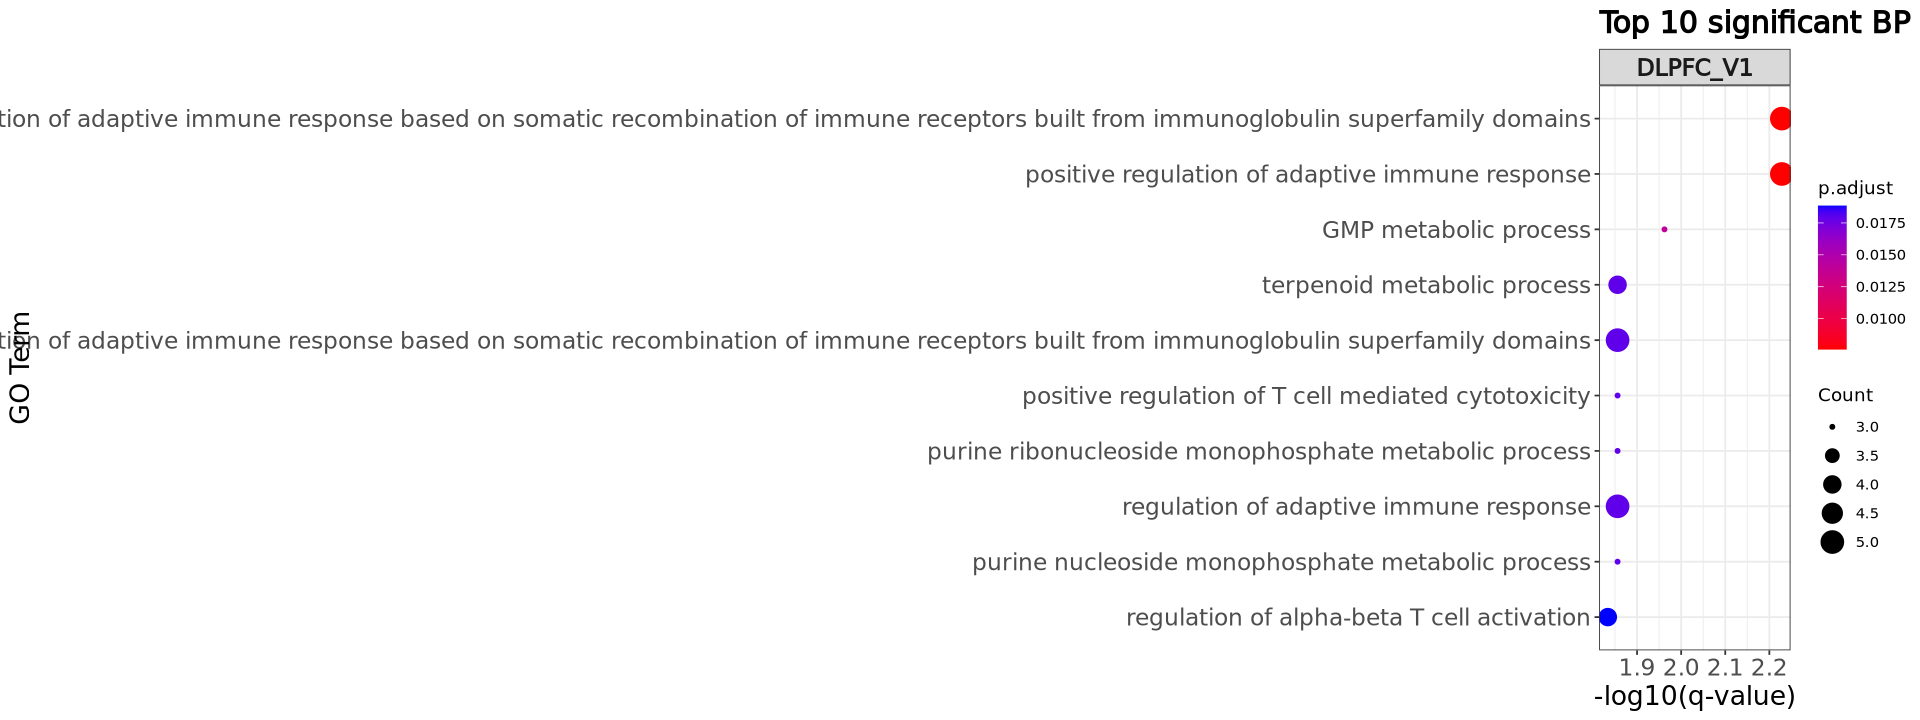

In [159]:
library(ggplot2)
library(dplyr)

# Filter, group by context, and take top 10 terms per context
df <- progm1_df %>%
  filter(qvalue < 0.05, ONTOLOGY == "BP") %>%
  group_by(context) %>%
  slice_min(qvalue, n = 10) %>%
  ungroup() %>%
  arrange(context, qvalue) %>%
  mutate(Description = factor(Description, levels = rev(unique(Description))))  # keep order

options(repr.plot.width = 16, repr.plot.height = 6)


ggplot(df, aes(x = -log10(qvalue), y = Description, size = Count, color = p.adjust)) +
  geom_point() +
  scale_color_gradient(low = "red", high = "blue") +
  facet_wrap(~ context, scales = "free_y") +
  labs(
    title = "Top 10 significant BP GO terms per context (q < 0.1)",
    x = "-log10(q-value)",
    y = "GO Term"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(face = "bold", size = 14),
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold")
  )

In [106]:
fwrite(progm1_df, 'GO.Top50_genes_Program1_split.txt', sep = '\t')

#### another top split

In [81]:
progm1_cor <- fread('Top50_Cor_genes_Program1_split.txt')


In [103]:
# Initialize empty data frame
progm1_cor_df <- data.frame()

# Loop through each context (column) in progm1
for(context in colnames(progm1_cor)){
    message(context)
  # Perform GO enrichment and store results with context label
  res_cor <- enrichGO(
    gene          = progm1_cor[[context]],  # use [[ ]] to access column by name
    OrgDb         = org.Hs.eg.db,
    keyType       = "SYMBOL",
    ont           = "ALL",
    pAdjustMethod = "BH",
    pvalueCutoff  = 1,
    qvalueCutoff  = 1
  ) %>% 
    as.data.frame() %>% 
    mutate(context = context)  # add context info
  
  # Append to cumulative results
  progm1_cor_df <- rbind(progm1_cor_df, res_cor)
}

Mic_V1

Exc_V1

Inh_V1

Ast_V1

Oli_V1

OPC_V1

DLPFC_V1

AC_V1

PCC_V1



In [83]:
progm1_cor_df %>% filter(qvalue < 0.05) %>% arrange(qvalue)


ID         Description                                           
GO:1904350  GO:1904350 regulation of protein catabolic process in the vacuole
GO:0007039  GO:0007039 protein catabolic process in the vacuole              
GO:0071425  GO:0071425 hematopoietic stem cell proliferation                 
GO:0072595  GO:0072595 maintenance of protein localization in organelle      
GO:00720893 GO:0072089 stem cell proliferation                               
            GeneRatio BgRatio   pvalue       p.adjust    qvalue     
GO:1904350  3/48      13/18870  4.339535e-06 0.006409494 0.005431271
GO:0007039  3/48      24/18870  3.011233e-05 0.022237953 0.018843977
GO:0071425  3/41      36/18870  6.467181e-05 0.047052170 0.038836071
GO:0072595  3/41      41/18870  9.582927e-05 0.047052170 0.038836071
GO:00720893 4/41      125/18870 1.537188e-04 0.050317303 0.041531057
            geneID                 Count context 
GO:1904350  LRP1/ATP13A2/CD81      3     DLPFC_V1
GO:0007039  LRP1/ATP13A2/CD81      3     DLPFC_V1
GO:0071425  ARIH2/ERCC2/RUNX1      3     Oli_V1  
GO:0072595  INSIG1/ARL2/TAF3       3     Oli_V1  
GO:00720893 ARIH2/GJA1/ERCC2/RUNX1 4     Oli_V1

In [107]:
fwrite(progm1_cor_df, 'GO.Top50_Cor_genes_Program1_split.txt', sep = '\t')

### program1 KEGG

#### split

In [161]:
progm1 <- fread('multi_gene/Top50_genes_Program1_split.txt')
progm1 %>% head

Mic_V1  Exc_V1  Inh_V1     Ast_V1  Oli_V1 OPC_V1 DLPFC_V1 AC_V1   PCC_V1
1 MAP2K2  ZBTB37  B3GNT5     ADCK5   UQCC3  RANBP2 BCKDK    ARHGEF1 FHAD1 
2 HLA-DMA SMIM12  AL162231.1 EIF5A   MAGEF1 BIN1   FBXO10   DTX3    TPM3  
3 CPLX1   TMED7   MTHFS      GNG3    FUCA1  TET3   COLQ     PENK    HERC2 
4 TTYH1   PGBD5   MCM7       BTN3A1  PRR7   KIF1A  ZFC3H1   COG1    FGF22 
5 KLHDC4  FAM229A RILPL2     SDHAF2  CMTM1  SAP18  TMEM151A QRICH1  CADPS2
6 TPGS2   FSCN1   FBXO21     ZFYVE19 GSTT2B GCFC2  PKD1L3   SLC26A2 PEX6

In [162]:
library(clusterProfiler)
library(org.Hs.eg.db)

# Initialize empty data frame
progm1_kegg_df <- data.frame()

# Loop through each context (column) in progm1
for (context in colnames(progm1)) {
  message("Processing: ", context)
  
  # Convert gene symbols to Entrez IDs
  genes_entrez <- bitr(
    progm1[[context]],
    fromType = "SYMBOL",
    toType = "ENTREZID",
    OrgDb = org.Hs.eg.db
  ) %>% pull(ENTREZID)
  
  # Skip if no mapped genes
  if (length(genes_entrez) == 0) next
  
  # Perform KEGG enrichment
  res_kegg <- enrichKEGG(
    gene          = genes_entrez,
    organism      = 'hsa',
    keyType       = "kegg",
    pAdjustMethod = "BH",
    pvalueCutoff  = 1,
    qvalueCutoff  = 1
  ) %>%
    as.data.frame() %>%
    mutate(context = context)  # label with context

  # Append results
  progm1_kegg_df <- rbind(progm1_kegg_df, res_kegg)
}

Processing: Mic_V1

'select()' returned 1:1 mapping between keys and columns

Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

Processing: Exc_V1

'select()' returned 1:1 mapping between keys and columns

Processing: Inh_V1

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(progm1[[context]], fromType = "SYMBOL", toType = "ENTREZID", :
"2% of input gene IDs are fail to map..."
Processing: Ast_V1

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(progm1[[context]], fromType = "SYMBOL", toType = "ENTREZID", :
"6.12% of input gene IDs are fail to map..."
Processing: Oli_V1

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(progm1[[context]], fromType = "SYMBOL", toType = "ENTREZID", :
"2% of input gene IDs are fail to map..."
Processing: OPC_V1

'select()' returned 1:1 mapping between keys and

In [165]:
progm1_kegg_df

category                            
hsa05219  Human Diseases                      
hsa04216  Cellular Processes                  
hsa03050  Genetic Information Processing      
hsa04140  Cellular Processes                  
hsa05164  Human Diseases                      
hsa04978  Organismal Systems                  
hsa05223  Human Diseases                      
hsa03040  Genetic Information Processing      
hsa05022  Human Diseases                      
hsa00604  Metabolism                          
hsa04722  Organismal Systems                  
hsa05135  Human Diseases                      
hsa05017  Human Diseases                      
hsa04218  Cellular Processes                  
hsa04150  Environmental Information Processing
hsa04217  Cellular Processes                  
hsa04514  Environmental Information Processing
hsa05310  Human Diseases                      
hsa05010  Human Diseases                      
hsa05216  Human Diseases                      
hsa05330  Human Diseases                      
hsa05169  Human Diseases                      
hsa04015  Environmental Information Processing
hsa04940  Human Diseases                      
hsa04962  Organismal Systems                  
hsa05332  Human Diseases                      
hsa00860  Metabolism                          
hsa00514  Metabolism                          
hsa05166  Human Diseases                      
hsa04672  Organismal Systems                  
...       ...                                 
hsa050173 Human Diseases                      
hsa052244 Human Diseases                      
hsa052264 Human Diseases                      
hsa012401 Metabolism                          
hsa041506 Environmental Information Processing
hsa041453 Cellular Processes                  
hsa051605 Human Diseases                      
hsa051614 Human Diseases                      
hsa041404 Cellular Processes                  
hsa041411 Genetic Information Processing      
hsa051646 Human Diseases                      
hsa051685 Human Diseases                      
hsa046212 Organismal Systems                  
hsa051674 Human Diseases                      
hsa048142 Cellular Processes                  
hsa052032 Human Diseases                      
hsa040154 Environmental Information Processing
hsa051704 Human Diseases                      
hsa054175 Human Diseases                      
hsa051635 Human Diseases                      
hsa048106 Cellular Processes                  
hsa048203 NA                                  
hsa051714 Human Diseases                      
hsa051323 Human Diseases                      
hsa041446 Cellular Processes                  
hsa051315 Human Diseases                      
hsa050125 Human Diseases                      
hsa050205 Human Diseases                      
hsa040104 Environmental Information Processing
hsa050164 Human Diseases                      
          subcategory                          ID      
hsa05219  Cancer: specific types               hsa05219
hsa04216  Cell growth and death                hsa04216
hsa03050  Folding, sorting and degradation     hsa03050
hsa04140  Transport and catabolism             hsa04140
hsa05164  Infectious disease: viral            hsa05164
hsa04978  Digestive system                     hsa04978
hsa05223  Cancer: specific types               hsa05223
hsa03040  Transcription                        hsa03040
hsa05022  Neurodegenerative disease            hsa05022
hsa00604  Glycan biosynthesis and metabolism   hsa00604
hsa04722  Nervous system                       hsa04722
hsa05135  Infectious disease: bacterial        hsa05135
hsa05017  Neurodegenerative disease            hsa05017
hsa04218  Cell growth and death                hsa04218
hsa04150  Signal transduction                  hsa04150
hsa04217  Cell growth and death                hsa04217
hsa04514  Signaling molecules and interaction  hsa04514
hsa05310  Immune disease                       hsa05310
hsa05010  Neurodegenerative dise

In [169]:
library(ggplot2)
library(dplyr)

# Filter, group by context, and take top 10 terms per context
df <- progm1_kegg_df %>%
  filter(qvalue < 0.1) %>%
  group_by(context) %>%
  slice_min(qvalue, n = 10) %>%
  ungroup() %>%
  arrange(context, qvalue) %>%
  mutate(Description = factor(Description, levels = rev(unique(Description))))  # keep order

options(repr.plot.width = 16, repr.plot.height = 6)


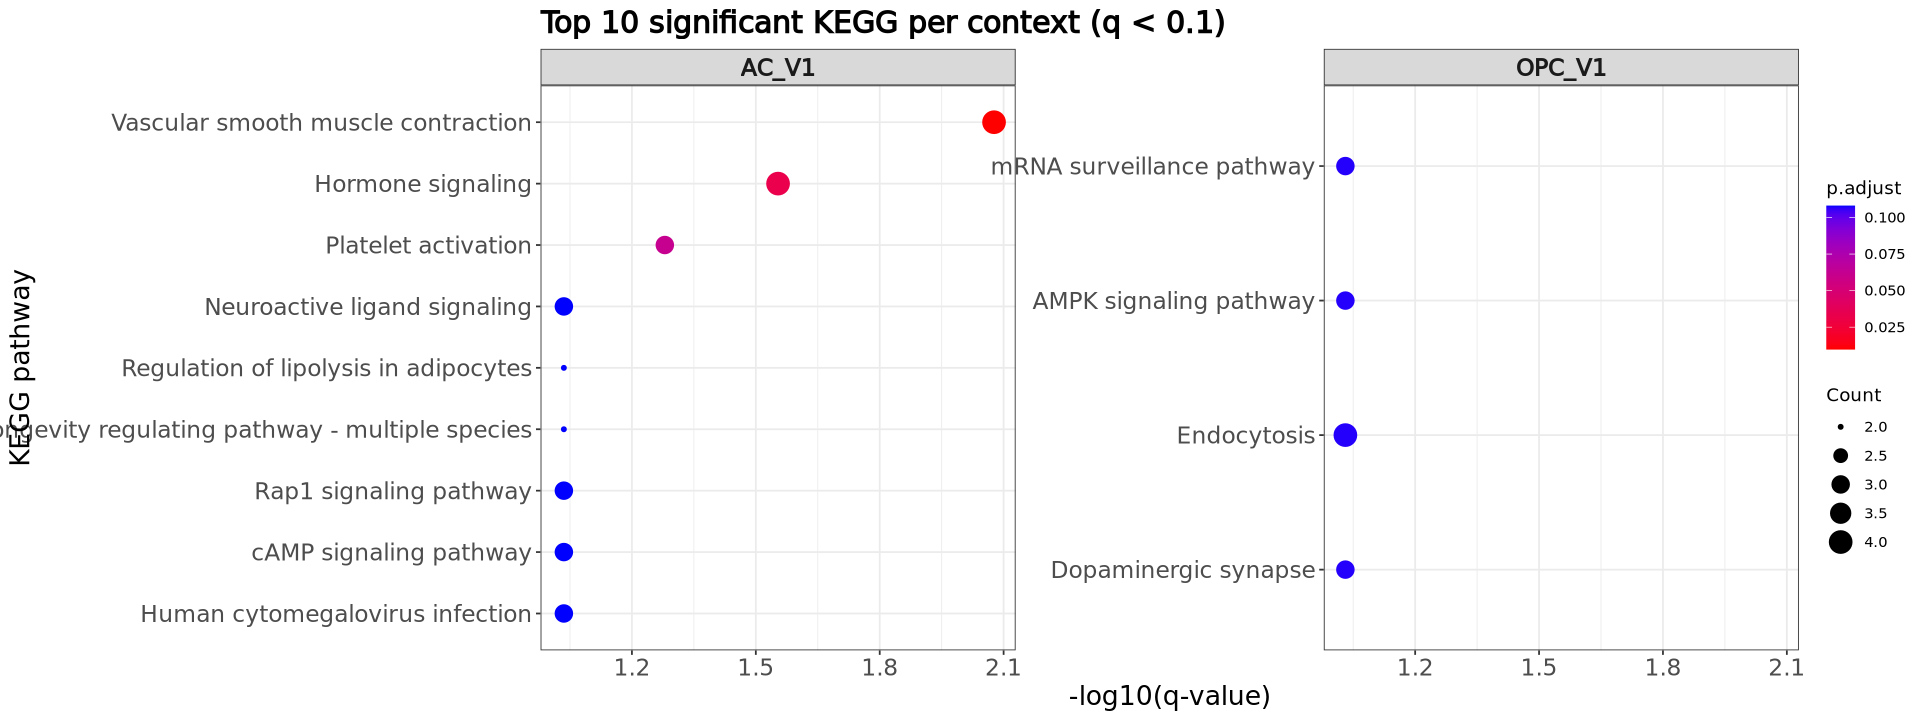

In [171]:


ggplot(df, aes(x = -log10(qvalue), y = Description, size = Count, color = p.adjust)) +
  geom_point() +
  scale_color_gradient(low = "red", high = "blue") +
  facet_wrap(~ context, scales = "free_y") +
  labs(
    title = "Top 10 significant KEGG per context (q < 0.1)",
    x = "-log10(q-value)",
    y = "KEGG pathway"
  ) +
  theme_bw() +
  theme(
    strip.text = element_text(face = "bold", size = 14),
    axis.text.y = element_text(size = 14),
    axis.text.x = element_text(size = 14),
    axis.title = element_text(size = 16),
    plot.title = element_text(size = 18, face = "bold")
  )

In [106]:
fwrite(progm1_df, 'GO.Top50_genes_Program1_split.txt', sep = '\t')

### program2 GO

#### split

In [112]:
progm2 <- fread('Top50_genes_Program2_split.txt')
progm2 %>% head

Mic_V2 Exc_V2 Inh_V2 Ast_V2  Oli_V2   OPC_V2
1 AP1G2  SSU72  PTHLH  CALY    GABRD    EEF1A2
2 ZBTB43 PPIA   PI4K2B RTL6    C1QTNF4  RTKN  
3 IKBKE  SH2D5  MCAT   ZDHHC23 LY6E     CEBPD 
4 LRRC4  MIA3   ESYT3  TAGLN3  EBNA1BP2 PDIA6 
5 ENTPD6 ZNF106 ROR2   TARBP2  ZNF804B  NOSIP 
6 WDR73  UQCRB  REEP5  LTBR    EFNA1    FABP5

In [113]:
# Initialize empty data frame
progm2_df <- data.frame()

# Loop through each context (column) in progm1
for(context in colnames(progm2)){
    message(context)
  # Perform GO enrichment and store results with context label
  res <- enrichGO(
    gene          = progm2[[context]],  # use [[ ]] to access column by name
    OrgDb         = org.Hs.eg.db,
    keyType       = "SYMBOL",
    ont           = "ALL",
    pAdjustMethod = "BH",
    pvalueCutoff  = 1,
    qvalueCutoff  = 1
  ) %>% 
    as.data.frame() %>% 
    mutate(context = context)  # add context info
  
  # Append to cumulative results
  progm2_df <- rbind(progm2_df, res)
}

Mic_V2

Exc_V2

Inh_V2

Ast_V2

Oli_V2

OPC_V2



In [120]:
progm2_df %>% filter(qvalue < 0.05,ONTOLOGY == 'BP') %>% arrange(qvalue)


ONTOLOGY ID        
GO:01060271 BP       GO:0106027
GO:00609962 BP       GO:0060996
GO:00991751 BP       GO:0099175
GO:00163583 BP       GO:0016358
GO:00508073 BP       GO:0050807
GO:1905383  BP       GO:1905383
GO:00609971 BP       GO:0060997
GO:00508033 BP       GO:0050803
GO:00606122 BP       GO:0060612
GO:00609981 BP       GO:0060998
GO:0040018  BP       GO:0040018
GO:0032096  BP       GO:0032096
GO:0032099  BP       GO:0032099
GO:0032105  BP       GO:0032105
GO:0032108  BP       GO:0032108
GO:0033210  BP       GO:0033210
GO:00109763 BP       GO:0010976
GO:0042559  BP       GO:0042559
GO:0035264  BP       GO:0035264
GO:0040014  BP       GO:0040014
GO:0032095  BP       GO:0032095
GO:1904925  BP       GO:1904925
            Description                                                                                  
GO:01060271 neuron projection organization                                                               
GO:00609962 dendritic spine development                                                                  
GO:00991751 regulation of postsynapse organization                                                       
GO:00163583 dendrite development                                                                         
GO:00508073 regulation of synapse organization                                                           
GO:1905383  protein localization to presynapse                                                           
GO:00609971 dendritic spine morphogenesis                                                                
GO:00508033 regulation of synapse structure or activity                                                  
GO:00606122 adipose tissue development                                                                   
GO:00609981 regulation of dendritic spine development                                                    
GO:0040018  positive regulation of multicellular organism growth                                         
GO:0032096  negative regulation of response to food                                                      
GO:0032099  negative regulation of appetite                                                              
GO:0032105  negative regulation of response to extracellular stimulus                                    
GO:0032108  negative regulation of response to nutrient levels                                           
GO:0033210  leptin-mediated signaling pathway                                                            
GO:00109763 positive regulation of neuron projection development                                         
GO:0042559  pteridine-containing compound biosynthetic process                                           
GO:0035264  multicellular organism growth                                                                
GO:0040014  regulation of multicellular organism growth                                                  
GO:0032095  regulation of response to food                                                               
GO:1904925  positive regulation of autophagy of mitochondrion in response to mitochondrial depolarization
            GeneRatio BgRatio   pvalue       p.adjust   qvalue    
GO:01060271 4/46      91/18870  7.073369e-05 0.03729628 0.03141501
GO:00609962 4/46      95/18870  8.365735e-05 0.03729628 0.03141501
GO:00991751 4/46      103/18870 1.145424e-04 0.03729628 0.03141501
GO:00163583 5/46      233/18870 2.494742e-04 0.03729628 0.03141501
GO:00508073 5/46      244/18870 3.086070e-04 0.03729628 0.03141501
GO:1905383  2/46      11/18870  3.153078e-04 0.03729628 0.03141501
GO:00609971 3/46      56/18870  3.432937e-04 0.03729628 0.03141501
GO:00508033 5/46      250/18870 3.450457e-04 0.03729628 0.03141501
GO:00606122 3/46      57/18870  3.617486e-04 0.03729628 0.03141501
GO:00609981 3/46      57/18870  3.617486e-04 0.03729628 0.03141501
GO:0040018  3/48      31/18870  6.604359e-05 0.04972069 0.04345005
GO:0032096  2/48      10/18870  2.

In [115]:
fwrite(progm2_df, 'GO.Top50_genes_Program2_split.txt', sep = '\t')

#### another top split

In [116]:
progm2_cor <- fread('Top50_Cor_genes_Program2_split.txt')


In [117]:
# Initialize empty data frame
progm2_cor_df <- data.frame()

# Loop through each context (column) in progm1
for(context in colnames(progm2_cor)){
    message(context)
  # Perform GO enrichment and store results with context label
  res_cor <- enrichGO(
    gene          = progm2_cor[[context]],  # use [[ ]] to access column by name
    OrgDb         = org.Hs.eg.db,
    keyType       = "SYMBOL",
    ont           = "ALL",
    pAdjustMethod = "BH",
    pvalueCutoff  = 1,
    qvalueCutoff  = 1
  ) %>% 
    as.data.frame() %>% 
    mutate(context = context)  # add context info
  
  # Append to cumulative results
  progm2_cor_df <- rbind(progm2_cor_df, res_cor)
}

Mic_V2

Exc_V2

Inh_V2

Ast_V2

Oli_V2

OPC_V2



In [118]:
progm2_cor_df %>% filter(qvalue < 0.05) %>% arrange(qvalue)


ONTOLOGY ID        
GO:00226261 CC       GO:0022626
GO:00443911 CC       GO:0044391
GO:00037351 MF       GO:0003735
GO:00226262 CC       GO:0022626
GO:00226252 CC       GO:0022625
GO:00058401 CC       GO:0005840
GO:0035035  MF       GO:0035035
GO:00021811 BP       GO:0002181
GO:00050852 MF       GO:0005085
GO:00443912 CC       GO:0044391
GO:0022627  CC       GO:0022627
GO:00159342 CC       GO:0015934
GO:00058402 CC       GO:0005840
GO:0031209  CC       GO:0031209
GO:00226251 CC       GO:0022625
GO:0035580  CC       GO:0035580
GO:00312522 CC       GO:0031252
GO:00037352 MF       GO:0003735
GO:00306954 MF       GO:0030695
GO:00605894 MF       GO:0060589
GO:00159351 CC       GO:0015935
GO:00331781 CC       GO:0033178
GO:0055105  MF       GO:0055105
GO:00312561 CC       GO:0031256
GO:0005940  CC       GO:0005940
GO:0031105  CC       GO:0031105
GO:0032156  CC       GO:0032156
GO:00321531 CC       GO:0032153
GO:0042809  MF       GO:0042809
GO:0034315  BP       GO:0034315
GO:0070064  MF       GO:0070064
GO:00021812 BP       GO:0002181
GO:0042788  CC       GO:0042788
GO:00986871 CC       GO:0098687
GO:00159341 CC       GO:0015934
GO:0034358  CC       GO:0034358
GO:1990777  CC       GO:1990777
GO:00059251 CC       GO:0005925
GO:00300551 CC       GO:0030055
GO:0032994  CC       GO:0032994
GO:0070847  CC       GO:0070847
GO:00427881 CC       GO:0042788
GO:0001772  CC       GO:0001772
GO:00058741 CC       GO:0005874
GO:0044389  MF       GO:0044389
GO:0051125  BP       GO:0051125
GO:00164691 CC       GO:0016469
GO:0042581  CC       GO:0042581
GO:0005788  CC       GO:0005788
GO:00347741 CC       GO:0034774
GO:1904724  CC       GO:1904724
GO:00602051 CC       GO:0060205
GO:00319831 CC       GO:0031983
            Description                                                    
GO:00226261 cytosolic ribosome                                             
GO:00443911 ribosomal subunit                                              
GO:00037351 structural constituent of ribosome                             
GO:00226262 cytosolic ribosome                                             
GO:00226252 cytosolic large ribosomal subunit                              
GO:00058401 ribosome                                                       
GO:0035035  histone acetyltransferase binding                              
GO:00021811 cytoplasmic translation                                        
GO:00050852 guanyl-nucleotide exchange factor activity                     
GO:00443912 ribosomal subunit                                              
GO:0022627  cytosolic small ribosomal subunit                              
GO:00159342 large ribosomal subunit                                        
GO:00058402 ribosome                                                       
GO:0031209  SCAR complex                                                   
GO:00226251 cytosolic large ribosomal subunit                              
GO:0035580  specific granule lumen                                         
GO:00312522 cell leading edge                                              
GO:00037352 structural constituent of ribosome                             
GO:00306954 GTPase regulator activity                                      
GO:00605894 nucleoside-triphosphatase regulator activity                   
GO:00159351 small ribosomal subunit                                        
GO:00331781 proton-transporting two-sector ATPase complex, catalytic domain
GO:0055105  ubiquitin-protein transferase inhibitor activity               
GO:00312561 leading edge membrane                                          
GO:0005940  septin ring                                                    
GO:0031105  septin complex                                                 
GO:0032156  septin cytoskeleton                                            
GO:00321531 cell division site                                             
GO:0042809  nuclear vitamin D receptor binding                             
GO:0

In [119]:
fwrite(progm2_cor_df, 'GO.Top50_Cor_genes_Program2_split.txt', sep = '\t')

### check gene expression
we are wondering why CORO1A was picked by cTWAS, wondering if that gene has a higher expression correlation with others

In [297]:
mic_exp <- fread('/data/eQTL/ROSMAP/DLPFC_Mic/analysis_ready/phenotype_preprocessing/phenotype_by_chrom/Mic.log2cpm.bed.chr11.bed.gz')

In [299]:
mic_exp %>% filter(ID == 'ENSG00000066336')

#chr  start    end      ID              MAP15387421 MAP22868024 MAP46246604
1 chr11 47378546 47378547 ENSG00000066336 0.3710662   -1.778669   0.7291951  
  MAP50104134 MAP50104846 MAP50106442 ... SM-CTEMS  SM-CTEMU SM-CTEMW  
1 -0.7291951  -0.9848335  1.054258    ... -0.168891 1.650584 -0.3964614
  SM-CTEMY   SM-CTEN2 SM-CTEN5  SM-CTEN7 SM-CTEND   SM-CTENF  SM-CTENG  
1 -0.1808688 0.661588 -1.525803 2.454256 -0.4480493 0.1509692 -0.3271831

In [300]:
spi1_fmp <- readRDS('/data/analysis_result/single_context/ROSMAP_eQTL/export/ROSMAP_eQTL.ENSG00000066336.cis_results_db.export.rds')

In [302]:
spi1_fmp[[1]] %>% names

[1] "Mic_DeJager_eQTL_ENSG00000066336"   "Ast_DeJager_eQTL_ENSG00000066336"  
[3] "Inh_DeJager_eQTL_ENSG00000066336"   "DLPFC_DeJager_eQTL_ENSG00000066336"
[5] "PCC_DeJager_eQTL_ENSG00000066336"   "AC_DeJager_eQTL_ENSG00000066336"   
[7] "Mic_Kellis_eQTL_ENSG00000066336"    "Mic_mega_eQTL_ENSG00000066336"

In [305]:
spi1_fmp[[1]][['Mic_DeJager_eQTL_ENSG00000066336']][['top_loci']]

variant_id betahat sebetahat maf pip cs_coverage_0.95 cs_coverage_0.7
     cs_coverage_0.5

In [308]:
spi1_fmp[[1]][['Mic_Kellis_eQTL_ENSG00000066336']][['top_loci']]

NULL

In [309]:
spi1_fmp[[1]][['Mic_mega_eQTL_ENSG00000066336']][['top_loci']]

NULL